# Data Analysis - Velib Project in <a href="https://cran.r-project.org/"><img src="https://cran.r-project.org/Rlogo.svg" style="max-width: 40px; display: inline" alt="R"/></a>
---

_Authors:_ J. Chevallier (<small>INSA Toulouse</small>), O. Roustant (<small>INSA Toulouse</small>).

We consider the [velib](https://www.velib-metropole.fr/donnees-open-data-gbfs-du-service-velib-metropole) data set, related to the bike sharing system of Paris. The data are loading profiles of the bike stations over one week, collected every hour, from the period Monday 2nd Sept. - Sunday 7th Sept., 2014. The loading profile of a station, or simply loading, is defined as the ratio of number of available bikes divided by the number of bike docks. A loading of 1 means that the station is fully loaded, i.e. all bikes are available. A loading of 0 means that the station is empty, all bikes have been rent.

From the viewpoint of data analysis, the individuals are the stations. The variables are the 168 time steps (hours in the week). **The aim is to detect clusters in the data, corresponding to common customer usages.** This clustering should then be used to predict the loading profile.

---

The aim of this tutorial is to reproduce the study we carried out in [Python](https://plmlab.math.cnrs.fr/wikistat/Exploration/-/blob/master/Velib/PT_velib_Python.ipynb) on R.

As before, you can find suggested corrections in the "solutions" file. Try to find the answers yourself first! (that's how we make progress). Unfortunately, in `R` the magic `%load` command does not work, so you will have to retrieve the solutions manually.

In [1]:
rm(list = ls())  

In [3]:
install.packages(c("reshape2", "gridExtra", "dplyr", "FactoMineR", "factoextra", "car", "ggpubr", "cluster", "mclust", "cvms", "ggmap"))



The downloaded binary packages are in
	/var/folders/ly/m98ht2fd6vxc389_9v6rrfd80000gn/T//Rtmp8vI0QK/downloaded_packages


In [1]:
library(ggplot2)
library(reshape2)
library(gridExtra)
library(dplyr)
library(FactoMineR)
library(factoextra)
library(car)
library(ggpubr)
library(repr)
library(cluster)
library(mclust)
library(cvms)
library(ggmap)


Attaching package: 'dplyr'


The following object is masked from 'package:gridExtra':

    combine


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


Welcome! Want to learn more? See two factoextra-related books at https://goo.gl/ve3WBa

Loading required package: carData


Attaching package: 'car'


The following object is masked from 'package:dplyr':

    recode


Package 'mclust' version 6.1.1
Type 'citation("mclust")' for citing this R package in publications.


Attaching package: 'cvms'


The following object is masked from 'package:ggpubr':

    font


ℹ Google's Terms of Service: <https://mapsplatform.google.com>
  Stadia Maps' Terms of Service: <https://stadiamaps.com/terms-of-service/>
  OpenStreetMap's Tile Usage Policy: <https://operations.osmfoundation.org/policies/tiles/>
ℹ Please cite ggmap if you use it! Use `citation("ggmap")` for details.


## Charger les données

In [2]:
# direct loading from stored data on PLMlab
load('data/velib.RData')
summary(velib)

# alternative: load the data from package funFEM, where you have more information (help page)
#library(funFEM)
#data(velib)
#help("velib")

         Length Class      Mode     
data      181   data.frame list     
position    2   data.frame list     
dates     181   -none-     character
bonus    1189   -none-     numeric  
names    1189   -none-     character

In [3]:
# data preparation
loading = as.matrix(velib$data)
colnames(loading) = 1:ncol(loading)
rownames(loading) = velib$names

stations = 1:nrow(loading)
coord = velib$position[stations,]
coord$bonus = velib$bonus[stations]

# select exactly 7 days of data (we remove the first 13 dates)
dates = 14:181
loading = loading[stations, dates]
colnames(loading) = 1:length(dates)
#loading=as.data.frame(loading)

head(loading)
head(coord)



,1,2,3,4,5,6,7,8,9,10,⋯,159,160,161,162,163,164,165,166,167,168
EURYALE DEHAYNIN,0.03846154,0.03846154,0.07692308,0.03846154,0.03846154,0.03846154,0.03846154,0.03846154,0.10714286,0.00000000,⋯,0.29629630,0.11111111,0.1111111,0.14814815,0.30769231,0.07692308,0.11538462,0.07692308,0.1538462,0.1538462
LEMERCIER,0.47826087,0.47826087,0.47826087,0.43478261,0.43478261,0.43478261,0.43478261,0.43478261,0.26086957,0.04347826,⋯,0.04347826,0.00000000,0.2173913,0.13043478,0.04545455,0.17391304,0.17391304,0.17391304,0.2608696,0.3913043
MEZIERES RENNES,0.21818182,0.14545455,0.12727273,0.10909091,0.10909091,0.10909091,0.09090909,0.09090909,0.05454545,0.10909091,⋯,0.25925926,0.25925926,0.2037037,0.12962963,0.14814815,0.29629630,0.31481481,0.37037037,0.3703704,0.4074074
FARMAN,0.95238095,0.95238095,0.95238095,0.95238095,0.95238095,0.95238095,0.95238095,1.00000000,1.00000000,1.00000000,⋯,1.00000000,1.00000000,0.9047619,0.85714286,0.85714286,0.85714286,0.76190476,0.76190476,0.7619048,0.7619048
QUAI DE LA RAPEE,0.92753623,0.81159420,0.73913043,0.72463768,0.72463768,0.72463768,0.72463768,0.72463768,0.75362319,0.97101449,⋯,0.22727273,0.45454545,0.5909091,0.83333333,1.00000000,0.81818182,0.63636364,0.71212121,0.6212121,0.5757576
CHOISY POINT D'IVRY,0.16666667,0.16666667,0.16666667,0.16666667,0.16666667,0.16666667,0.16666667,0.16666667,0.08333333,0.00000000,⋯,0.34782609,0.08695652,0.1153846,0.08695652,0.13043478,0.08695652,0.08695652,0.43478261,0.3913043,0.5217391


,longitude,latitude,bonus
,<dbl>,<dbl>,<dbl>
19117,2.377389,48.88630,0
17111,2.317591,48.89002,0
6103,2.330447,48.85030,0
15042,2.271396,48.83373,0
12003,2.366897,48.84589,0
13038,2.363335,48.82191,0


##### <span style="color:purple"> Nous avons chargé les données et les avons divisées en deux jeux des données : loading et coord. Selon les deux tableaux que je montre :</span>

- Tableau ''loading'': Ce tableau affiche les données sur l'utilisation des vélos aux stations à un moment donné (7 jours sélectionnés). Chaque ligne correspond à une station et chaque colonne correspond à une heure précise d'un jour de la semaine. Les valeurs dans le tableau peuvent représenter le taux de vélos disponibles à la station.
- Tableau ''coord'': Ce tableau contient des informations sur les coordonnées géographiques des stations de vélos, ainsi que des informations sur le terrain à chaque station (indiqué par la colonne bonus). La colonne bonus reflète si la station est située sur une colline ou non, avec 1 indiquant que la station est sur une colline et 0 indiquant qu'elle ne l'est pas.

In [4]:

cat('missing data\n')
loading_missing_value <- colSums(is.na(loading))  
cat('--- Loading ---\n')
cat(sum(loading_missing_value), '\n') 

coord_missing_value <- colSums(is.na(coord)) 
cat('--- Coord ---\n')
cat(sum(coord_missing_value), '\n')  
cat('---------------------------------\n')

cat('duplicate data\n')
cat('--- Loading ---\n')
loading_duplicates <- sum(duplicated(loading))  
cat(loading_duplicates, '\n')

cat('--- Coord ---\n')
coord_duplicates <- sum(duplicated(coord))  
cat(coord_duplicates, '\n')


missing data
--- Loading ---
0 
--- Coord ---
0 
---------------------------------
duplicate data
--- Loading ---
0 
--- Coord ---
0 


Ici, nous pouvons voir qu'il n'y a aucune donnée manquante ou en double.

In [5]:
coord_1 <- coord
station_names = rownames(loading)
coord_1$Station = station_names
last_col_name = names(coord_1)[ncol(coord_1)]
last_col = coord_1[, last_col_name]
coord_1 = coord_1[, -ncol(coord_1)]
coord_1 = cbind(last_col, coord_1)
colnames(coord_1)[1] = "Station"


In [6]:
loading_1=as.data.frame(loading)
data <- cbind(coord_1, loading_1)

data$bonus <- factor(data$bonus,levels = c("0", "1"))
head(data)



,Station,longitude,latitude,bonus,1,2,3,4,5,6,⋯,159,160,161,162,163,164,165,166,167,168
,<chr>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
19117,EURYALE DEHAYNIN,2.377389,48.88630,0,0.03846154,0.03846154,0.07692308,0.03846154,0.03846154,0.03846154,⋯,0.29629630,0.11111111,0.1111111,0.14814815,0.30769231,0.07692308,0.11538462,0.07692308,0.1538462,0.1538462
17111,LEMERCIER,2.317591,48.89002,0,0.47826087,0.47826087,0.47826087,0.43478261,0.43478261,0.43478261,⋯,0.04347826,0.00000000,0.2173913,0.13043478,0.04545455,0.17391304,0.17391304,0.17391304,0.2608696,0.3913043
6103,MEZIERES RENNES,2.330447,48.85030,0,0.21818182,0.14545455,0.12727273,0.10909091,0.10909091,0.10909091,⋯,0.25925926,0.25925926,0.2037037,0.12962963,0.14814815,0.29629630,0.31481481,0.37037037,0.3703704,0.4074074
15042,FARMAN,2.271396,48.83373,0,0.95238095,0.95238095,0.95238095,0.95238095,0.95238095,0.95238095,⋯,1.00000000,1.00000000,0.9047619,0.85714286,0.85714286,0.85714286,0.76190476,0.76190476,0.7619048,0.7619048
12003,QUAI DE LA RAPEE,2.366897,48.84589,0,0.92753623,0.81159420,0.73913043,0.72463768,0.72463768,0.72463768,⋯,0.22727273,0.45454545,0.5909091,0.83333333,1.00000000,0.81818182,0.63636364,0.71212121,0.6212121,0.5757576
13038,CHOISY POINT D'IVRY,2.363335,48.82191,0,0.16666667,0.16666667,0.16666667,0.16666667,0.16666667,0.16666667,⋯,0.34782609,0.08695652,0.1153846,0.08695652,0.13043478,0.08695652,0.08695652,0.43478261,0.3913043,0.5217391



Ici, on a fusionné les deux tableaux "coord" et "loading" dans le même ordre pour faciliter le codage ultérieur.

## Distribution des valeurs dans l'ensemble des données

No id variables; using all as measure variables



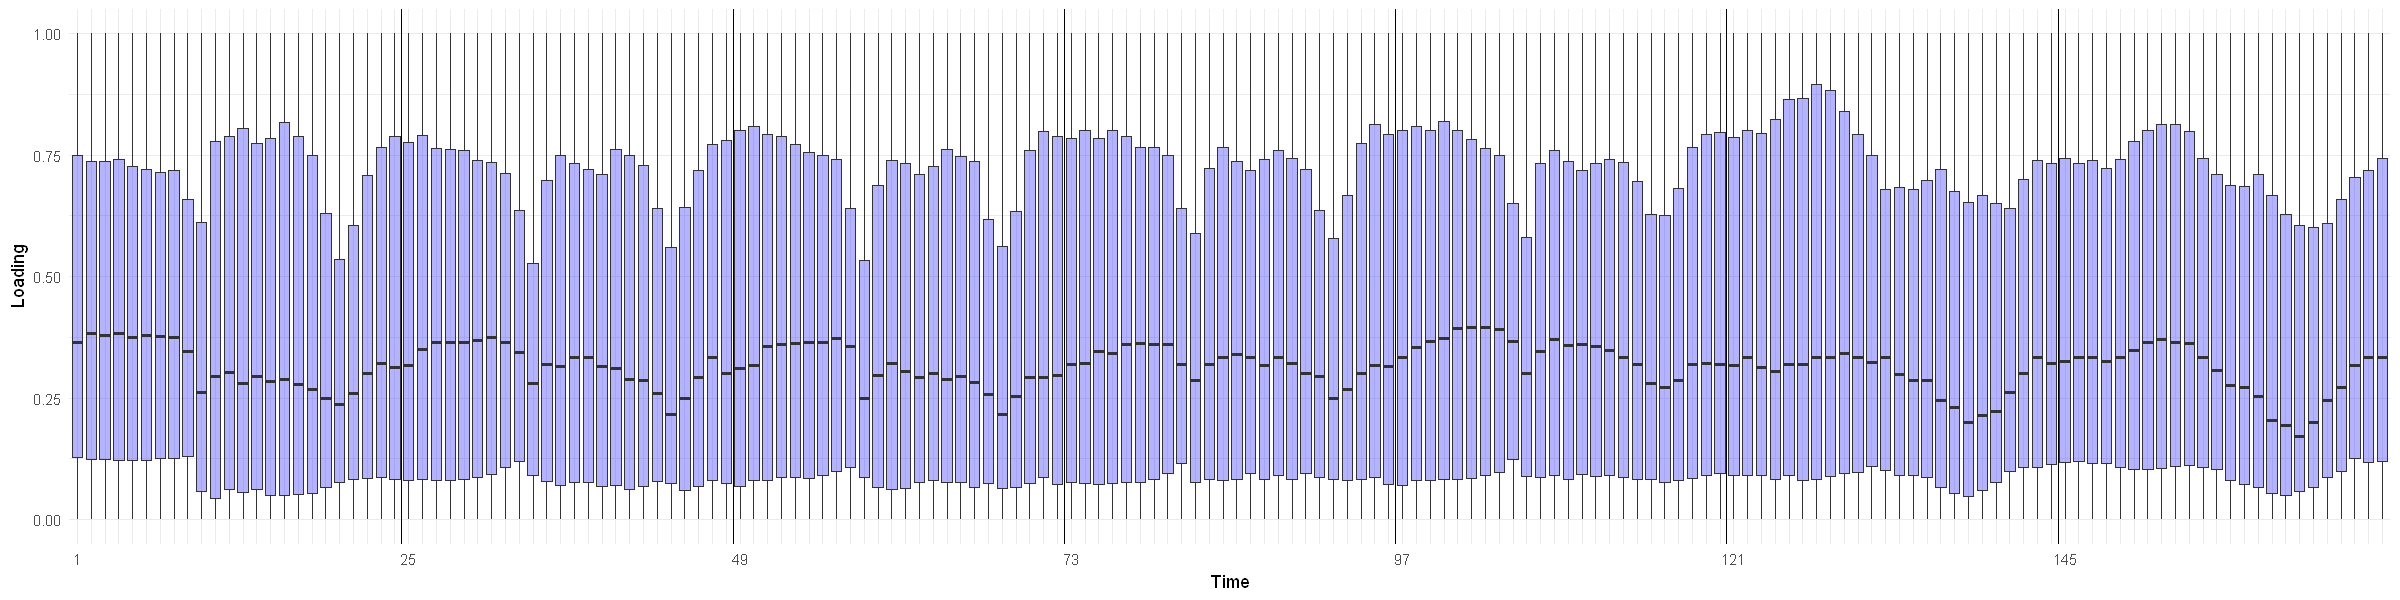

In [8]:
loading_frame <- as.data.frame(loading)
loading_frame <- loading_frame[data$bonus == 0, ]
df = melt(loading_frame)
options(repr.plot.width = 20, repr.plot.height = 5)

labels <- as.character(1:ncol(loading))
labels[-c(1, 25, 49, 73, 97, 121, 145)] <- ""  


ggplot(df, aes(x = variable, y = value)) +
  geom_boxplot(fill = "blue", alpha = 0.3) +
  geom_vline(xintercept = c(24.5, 48.5, 72.5, 96.5, 120.5, 144.5), color = "black", linetype = "solid") +
  scale_x_discrete(labels = labels) +  
  labs(x = "Time", y = "Loading") +  
  theme_minimal()



### Voici le diagramme boxplot des variables selon 168 intervalles de temps par semaine ( 1 intervalle = 1 heure ). 
#### 1. Pour la dynamique à chaque heure de la journée.
1.1 Pour les jours de la semaine, la plage horaire du matin tôt (de minuit à 7 heures) montre peu de variation de charge entre les heures, ce qui indique que pendant cette période, la location et le retour de vélos aux stations ne se produisent pas beaucoup. En revanche, pendant les heures de midi et du soir, il y a beaucoup de fluctuations dans certaines stations de pointe, ce qui indique qu'il y a beaucoup de locations ou de retours de vélos, montrant que c'est une période où les gens ont un besoin élevé et constant d'utiliser des vélos.

1.2 Pour le week-end, on observe des fluctuations tout au long de la journée, à tout moment, sauf à 6 et 7 heures du matin.
#### 2. L'amplitude de chaque colonne
Les colonnes s'étendent généralement de très proches de 0 à environ 0,85, ce qui montre qu'à tout moment, il y a toujours des stations presque vides mais en même temps, il y a aussi de nombreuses stations avec encore beaucoup de vélos.
#### 3. Commentaire sur la médiane
3.1 Pendant les jours de la semaine, de minuit à 8 heures du matin, la médiane montre une tendance à augmenter, ce qui signifie que le nombre de stations contenant plus de vélos augmente, ce qui indique que les gens commencent à retourner les vélos progressivement. Cependant, la médiane diminue fortement à partir de 10 heures et au-delà, atteignant un niveau beaucoup plus bas que le matin, ce qui signifie que les gens utilisent beaucoup de vélos, entraînant une diminution du nombre de vélos dans les stations.

3.2 Pendant les week-ends, on remarque que la médiane est beaucoup plus basse que les autres moments de la journée pendant la plage horaire de 17 heures à 20 heures, ce qui indique que les gens commencent généralement à sortir et à utiliser des vélos pendant ces heures de fin de semaine.


## Chargement moyen

[1] "--- Average fill rate ---"
[1] 0.3816218
[1] ""
[1] "--- Least crowded station, on average ---"
 HORNET (BAGNOLET) 
        0.01613284 
[1] ""
[1] "--- Fullest station, on average ---"
 INSURRECTION AOUT 1944 (IVRY) 
                     0.9193723 


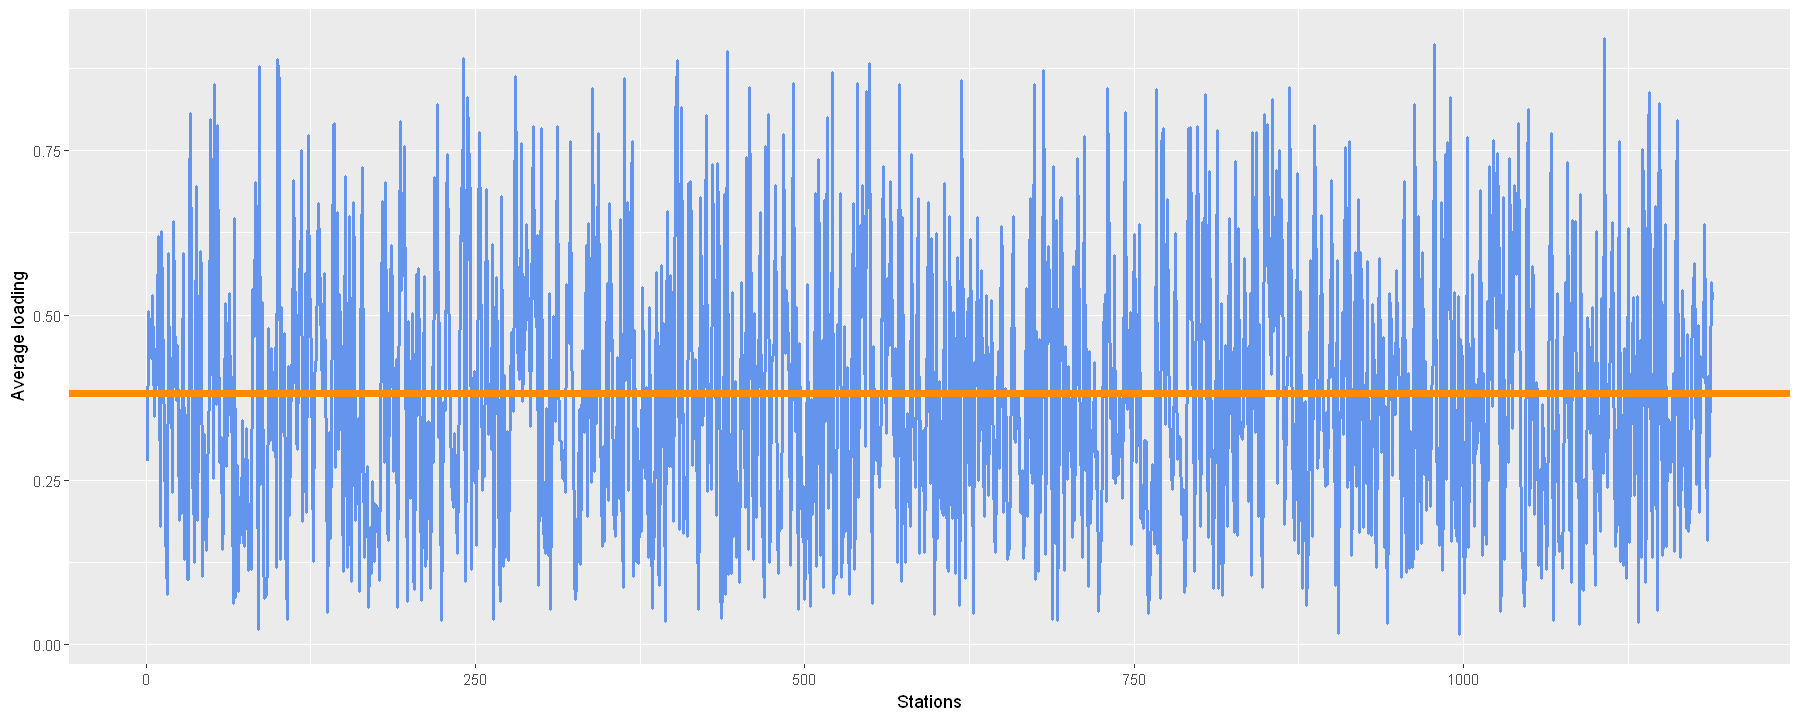

In [9]:

print('--- Average fill rate ---')
print(mean(loading))

# --- #
print('')

print('--- Least crowded station, on average ---')
i = which.min(rowMeans(loading)) 
print(rowMeans(loading)[i])

# --- #
print('')

print('--- Fullest station, on average ---')
i = which.max(rowMeans(loading))
print(rowMeans(loading)[i])
options(repr.plot.width = 15, repr.plot.height = 6)

df = data.frame(stations = c(1:nrow(loading)), mean = rowMeans(loading))
ggplot(df, aes(x = stations, y= mean)) + 
    geom_line(color = 'cornflowerblue', linewidth=1) +
    geom_hline(yintercept = mean(loading), color = 'darkorange', linewidth=2) +
    labs(x = "Stations", y = "Average loading")

##### <span style="color:purple"> A partir des calculs et du graphique, nous pouvons déterminer :</span>

- Le taux d'occupation moyen de toutes les différentes stations est différent.
- Le taux d'occupation moyen de toutes les gares routières est de 38,16%.
- La station moyenne la moins occupée est « HORNET (BAGNOLET) » avec un taux d'occupation moyen de 1,61%.
- La station moyenne la plus fréquentée est « INSURRECTION AOUT 1944 (IVRY) » avec un taux d'occupation moyen de 91,94%.

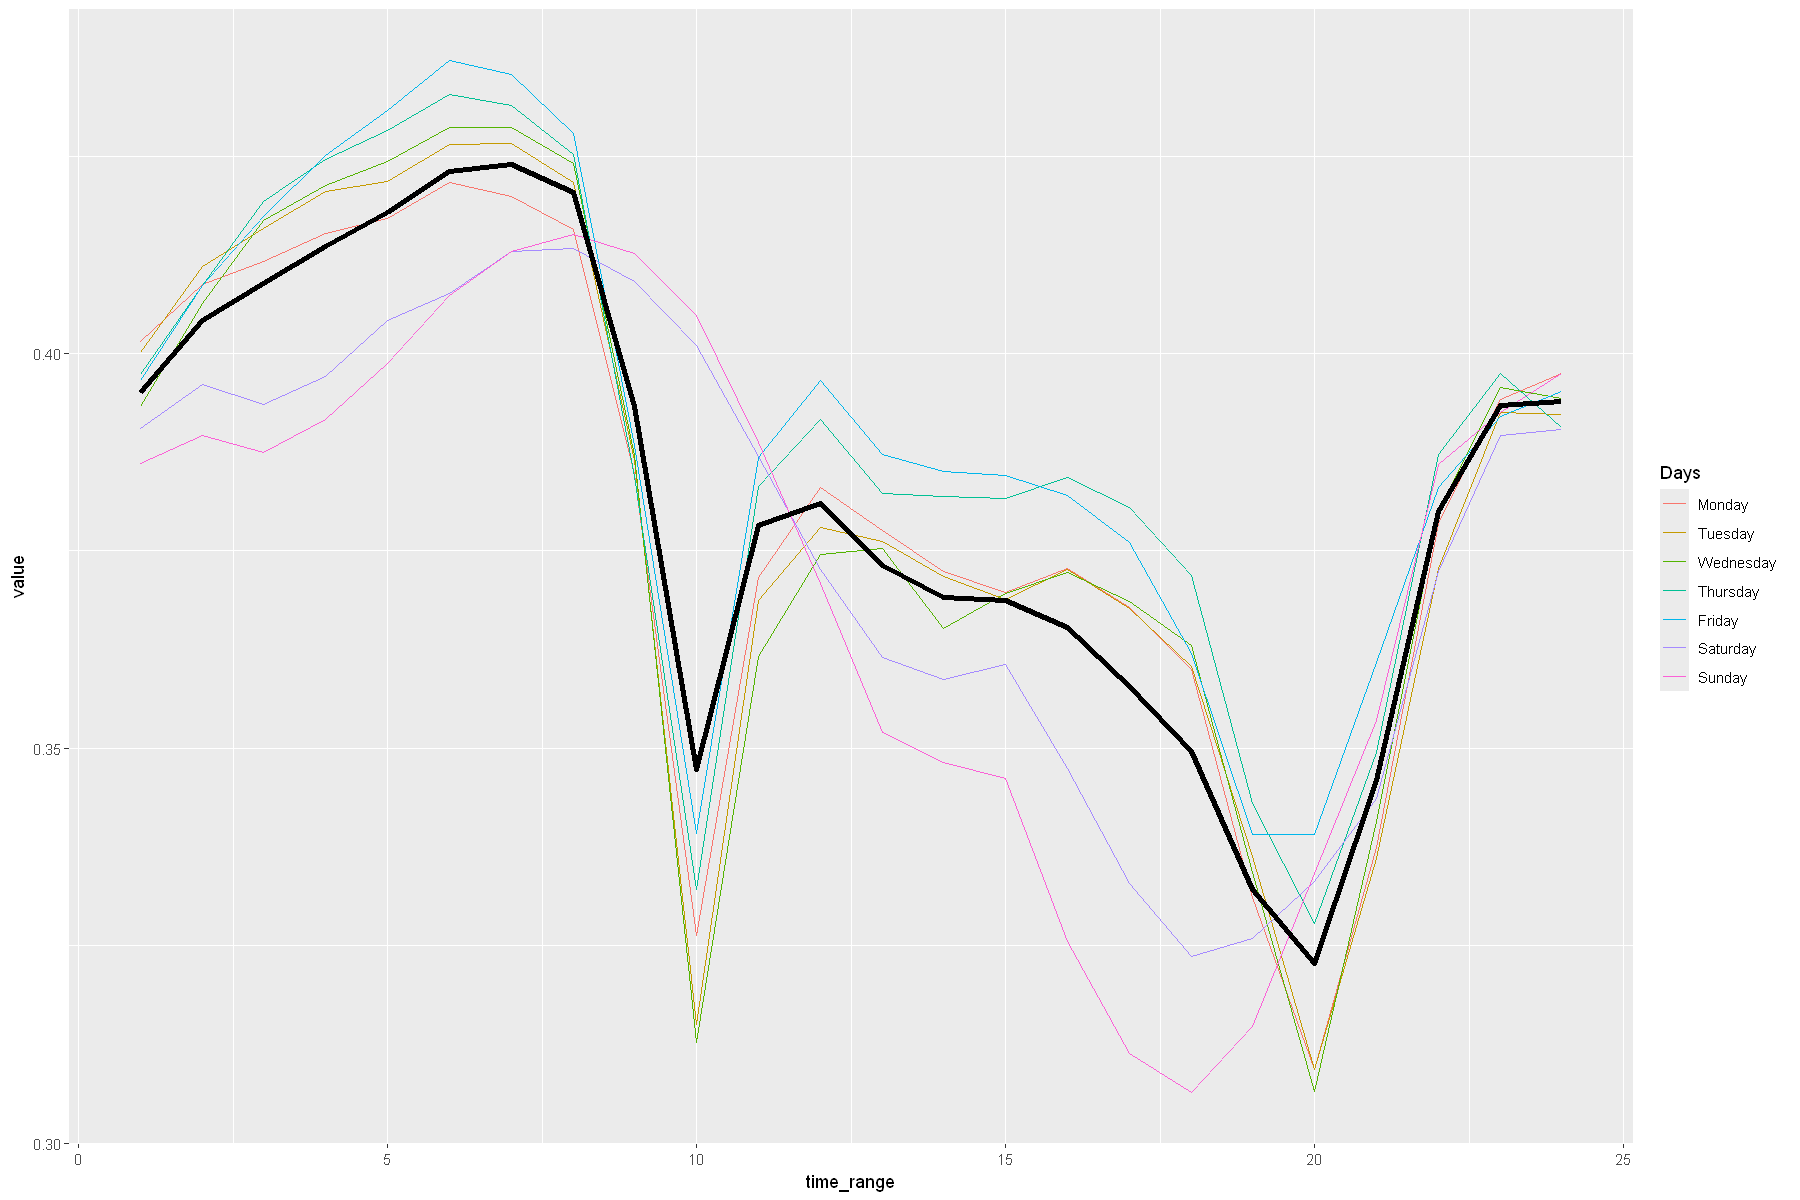

In [10]:
mean_per_hour_per_day = colMeans(loading)
mean_per_hour_per_day = matrix(mean_per_hour_per_day, nrow = 24)
mean_per_hour         = rowMeans(mean_per_hour_per_day)

# --- #

mean_per_hour_per_day            = as.data.frame(mean_per_hour_per_day)
colnames(mean_per_hour_per_day)  = list("Monday", "Tuesday", "Wednesday","Thursday", "Friday", "Saturday", "Sunday")
mean_per_hour_per_day$time_range = c(1:24)
mean_per_hour_per_day            = melt(mean_per_hour_per_day, id='time_range', variable.name='Days')

mean_per_hour            = as.data.frame(mean_per_hour)
colnames(mean_per_hour)  = list("Weekly")
mean_per_hour$time_range = c(1:24)

# --- #

options(repr.plot.width = 15, repr.plot.height = 10)

ggplot() + 
    geom_line(data=mean_per_hour_per_day, aes(x=time_range, y=value, color=Days)) + 
    geom_line(data=mean_per_hour, aes(x=time_range, y=Weekly), linewidth = 1.5)

##### <span style="color:purple"> Nous dessinons un graphique du taux moyen de disponibilité des vélos par heure et par jour de la semaine. D'après le graphique, nous constatons que :</span>

- Le taux moyen de disponibilité des vélos par heure semble similaire du lundi au vendredi, à l'exception des week-ends.
- Du lundi au vendredi, le taux le plus bas est à 20 heures, ce qui signifie que le nombre de locations de vélos est le plus élevé à ce moment-là, puis il augmente progressivement jusqu'à 7 heures du matin pour atteindre un pic. Ensuite, il diminue jusqu'à 10 heures du matin, puis augmente à nouveau jusqu'à midi avant de diminuer jusqu'à 20 heures.
- Pendant les deux jours du week-end, le taux le plus bas est à 18 heures, puis il augmente progressivement jusqu'à 8 heures du matin pour atteindre un pic. Ensuite, il diminue progressivement jusqu'à 18 heures (avec une légère augmentation à 15 heures).

## PCA

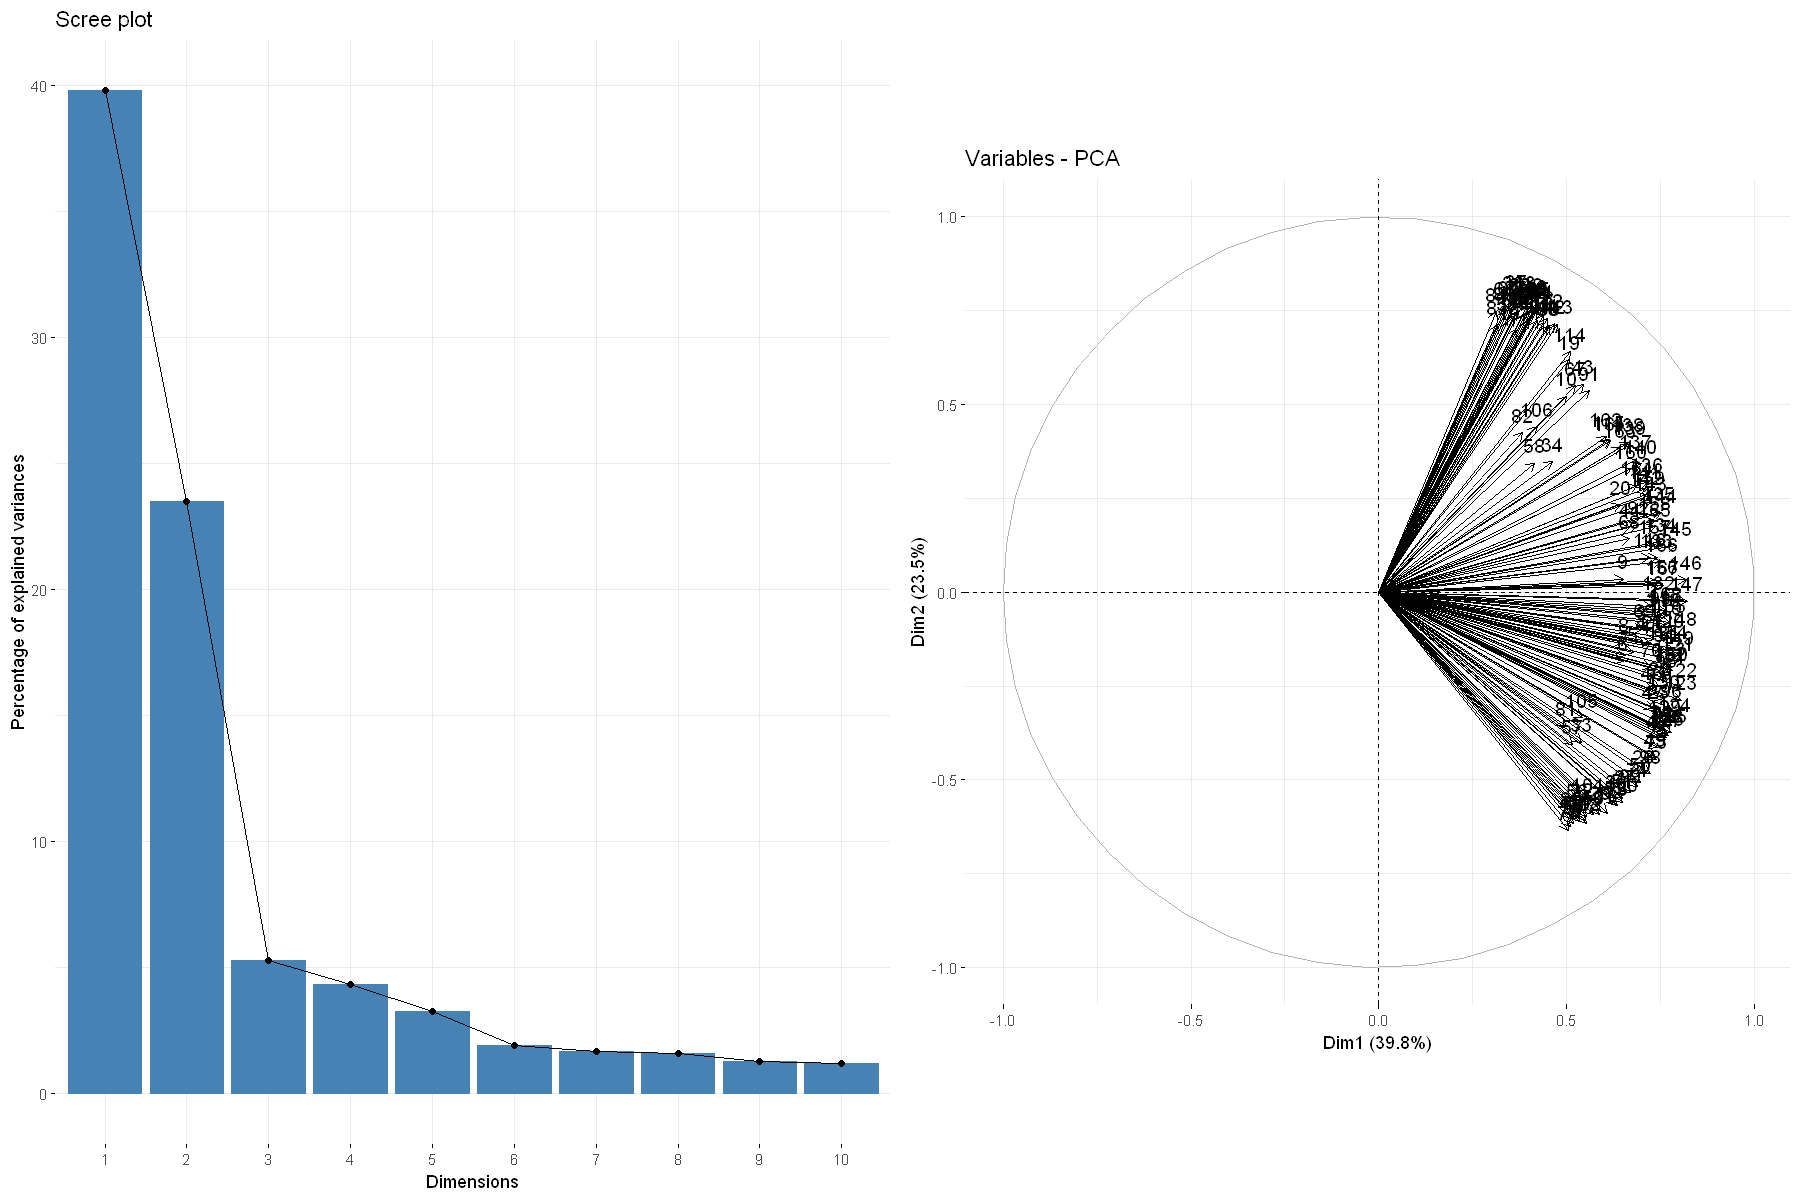

In [11]:
data_scale = data
data_scale[,-c(1,2,3,4)] = scale(data[,-c(1,2,3,4)], scale=TRUE, center=T)
pca = PCA(data_scale[,-c(2,3)],quali.sup=c(1,2), scale.unit = TRUE, graph=FALSE)

# Visualisation of explained variance and variables
grid.arrange(
    fviz_eig(pca), 
    fviz_pca_var(pca,axes=c(1,2)),
    ncol=2
)



On constate qu'à partir de la sixième composante, la variance n'évolue plus significativement, donc on peut conserver les cinq premières composantes. De même, on peut également sélectionner les deux premières composantes avec environ 63 % de la variance être conservées.

Warning message:
"Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead."


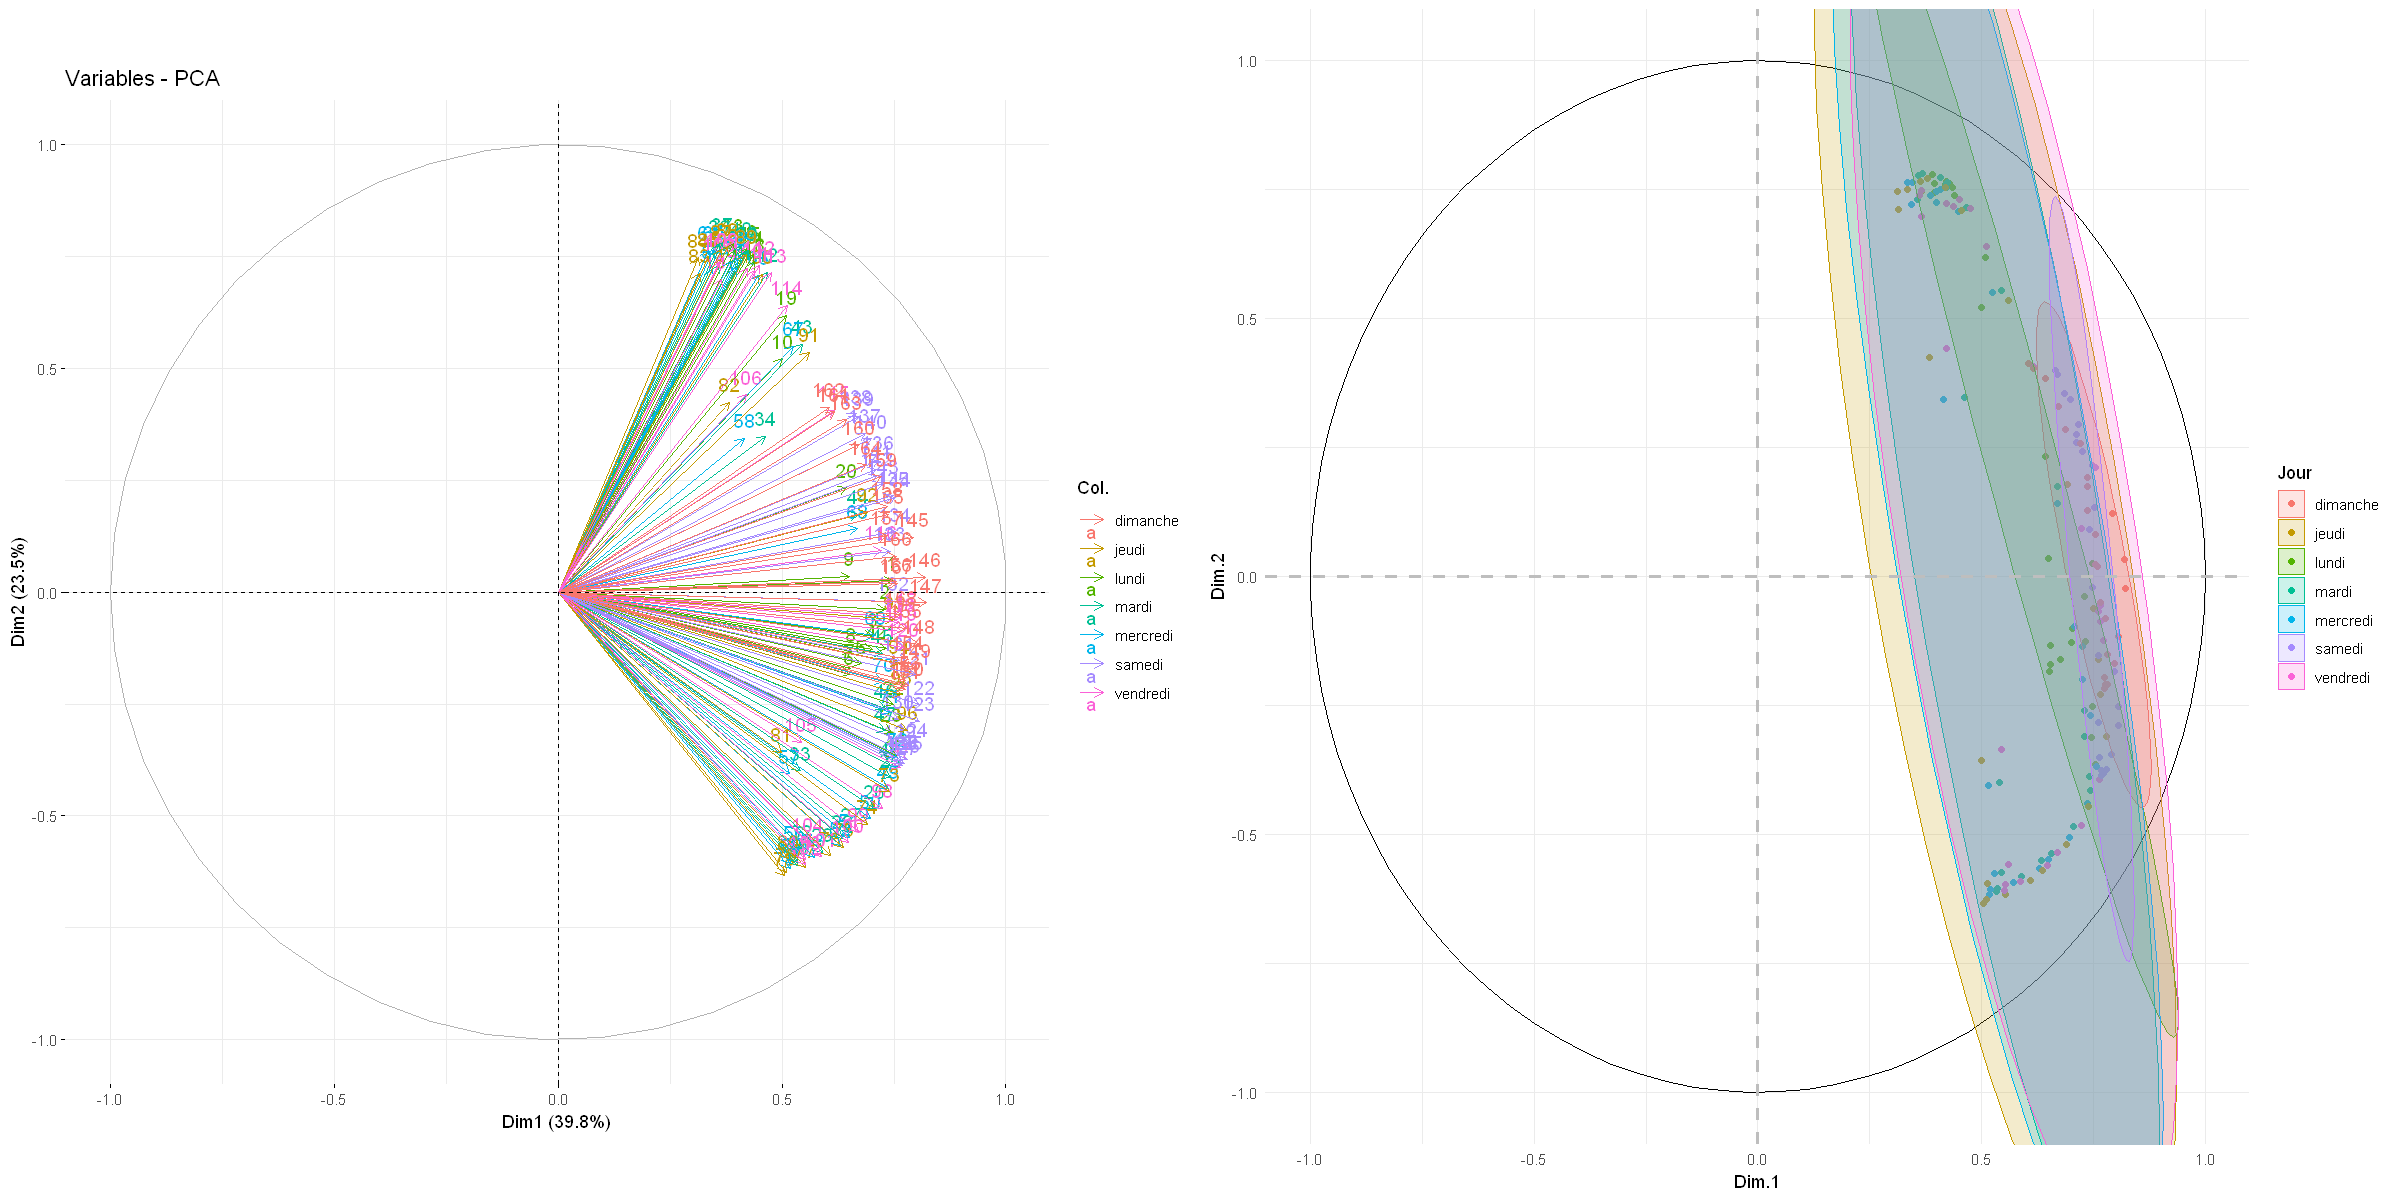

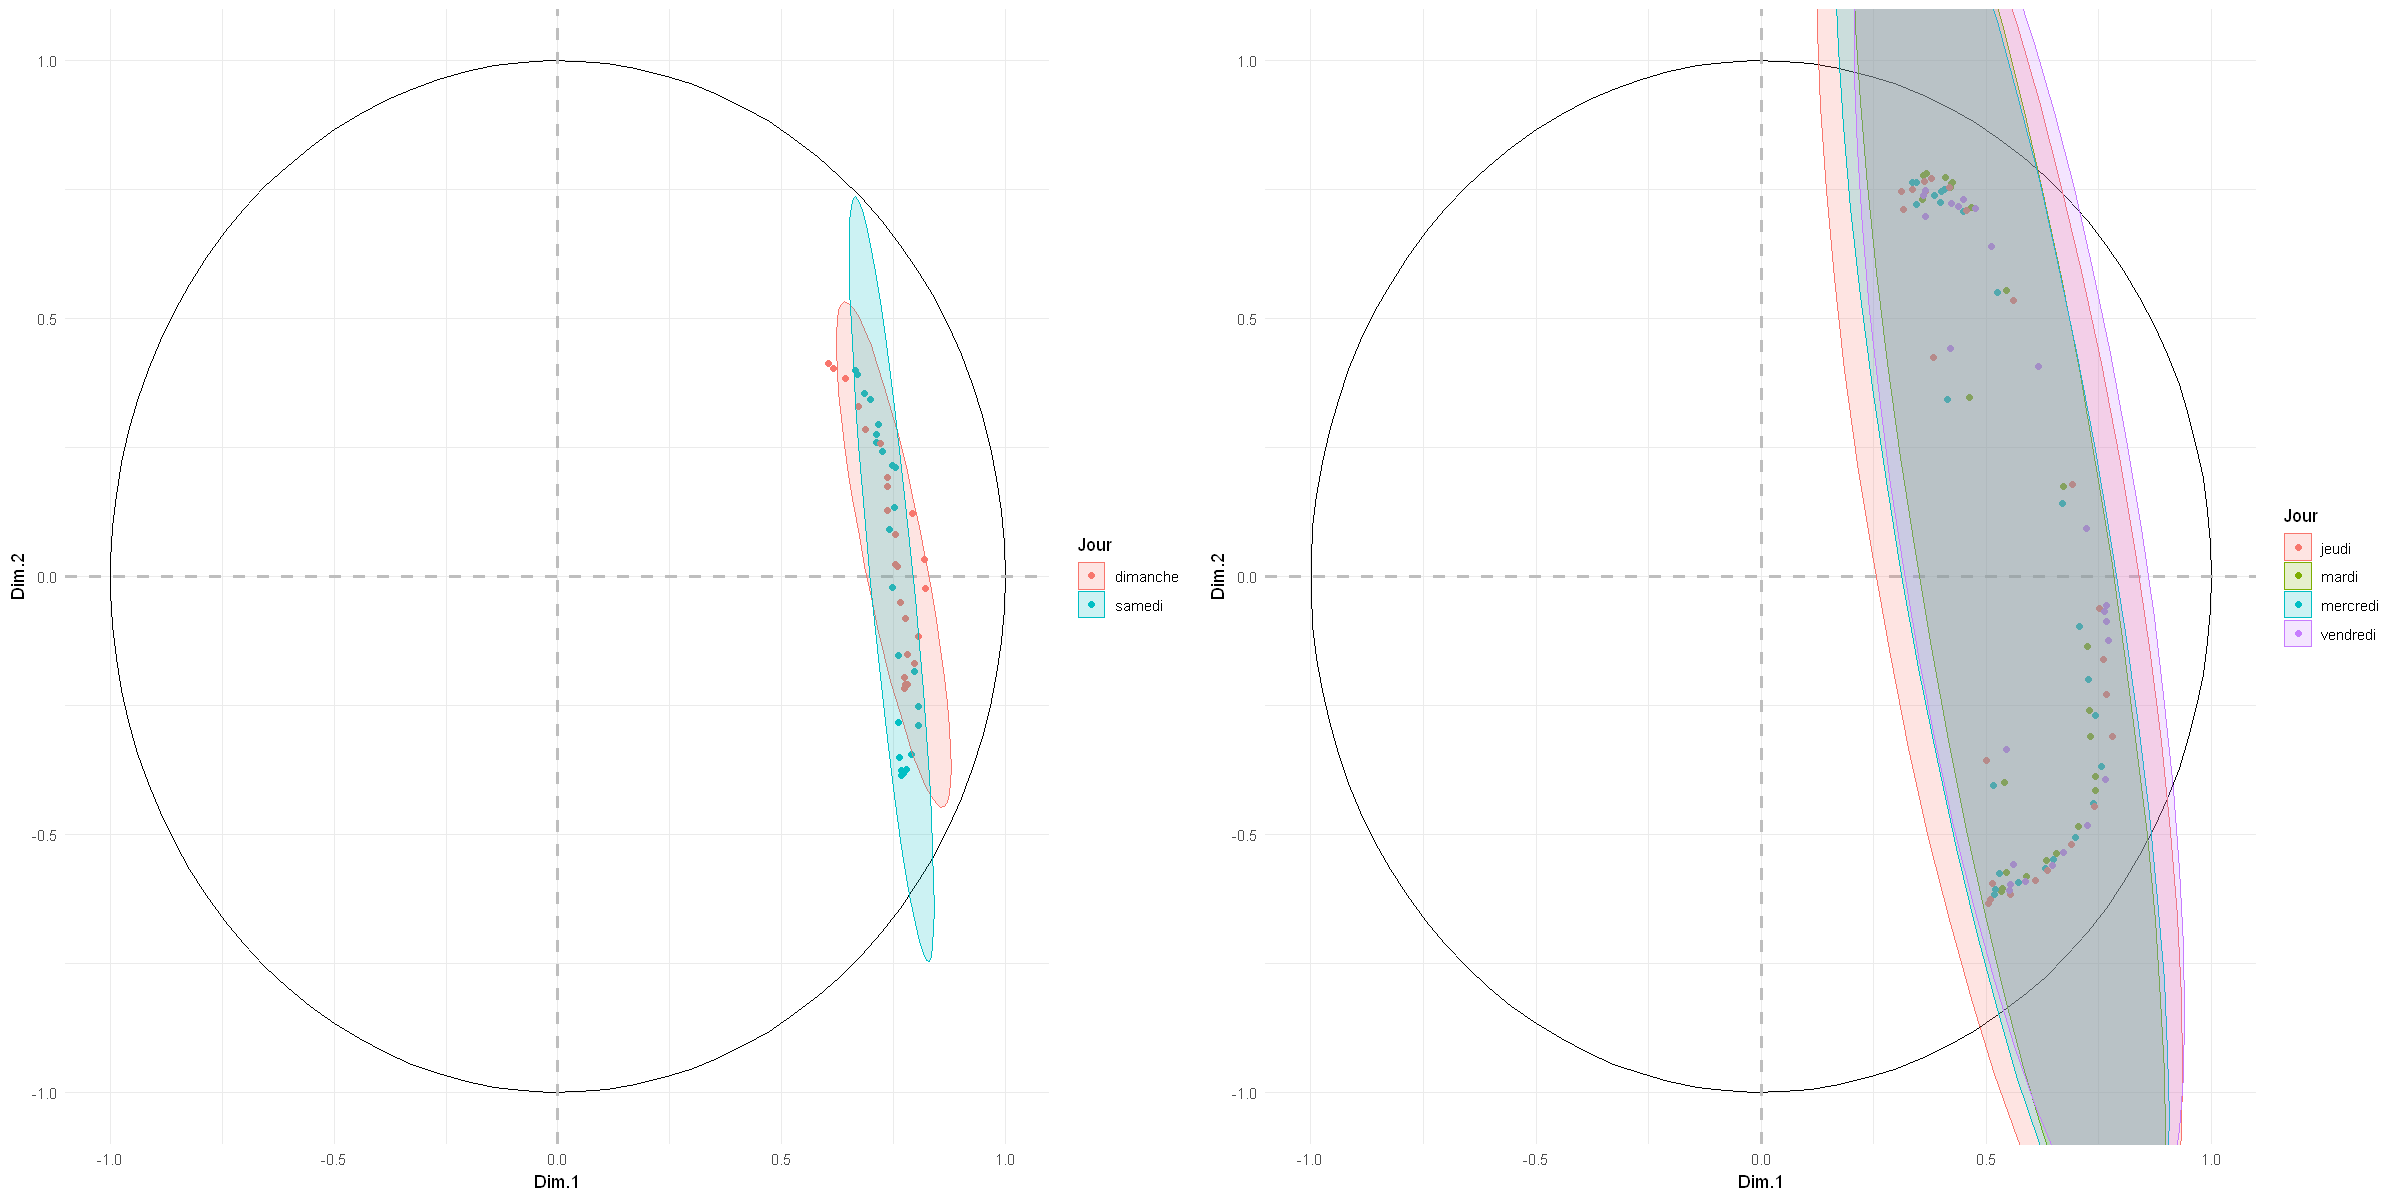

In [12]:



variable_names <- colnames(data)


variable_groups <- rep(c("lundi", "mardi", "mercredi", "jeudi", "vendredi", "samedi", "dimanche"), each = 24)


pca_vars <- get_pca_var(pca)


pca_df <- as.data.frame(pca_vars$coord)


pca_df$Jour <- variable_groups


circle_data <- data.frame(x = cos(seq(0, 2 * pi, length.out = 100)),
                          y = sin(seq(0, 2 * pi, length.out = 100)))


options(repr.plot.width=20, repr.plot.height=10)


grid.arrange(
  fviz_pca_var(pca, axes = c(1, 2), col.var = variable_groups),
  ggplot(pca_df, aes(x = Dim.1, y = Dim.2, color = Jour)) +
    geom_point() +
    geom_path(data = circle_data, aes(x, y), color = "black", size = 0.1) +    
    stat_ellipse(level = 0.95, geom = "polygon", aes(fill = Jour), alpha = 0.2) +
    geom_hline(yintercept = 0, linetype = "dashed", color = "gray", size = 1) + 
    geom_vline(xintercept = 0, linetype = "dashed", color = "gray", size = 1) +  
    theme_minimal() +
    coord_cartesian(xlim = c(-1, 1), ylim = c(-1, 1)),
  ncol = 2
)


pca_df_filtered <- pca_df[pca_df$Jour %in% c("samedi", "dimanche"), ]


pca_df_filtered2 <- pca_df[pca_df$Jour %in% c( "mardi", "mercredi", "jeudi", "vendredi"), ]


grid.arrange(
  ggplot(pca_df_filtered, aes(x = Dim.1, y = Dim.2, color = Jour)) +
    geom_point() +
    geom_path(data = circle_data, aes(x, y), color = "black", size = 0.1) +
    geom_hline(yintercept = 0, linetype = "dashed", color = "gray", size = 1) +  
    geom_vline(xintercept = 0, linetype = "dashed", color = "gray", size = 1) +  
    stat_ellipse(level = 0.95, geom = "polygon", aes(fill = Jour), alpha = 0.2) +
    theme_minimal() +
    coord_cartesian(xlim = c(-1, 1), ylim = c(-1, 1)),
  ggplot(pca_df_filtered2, aes(x = Dim.1, y = Dim.2, color = Jour)) +
    geom_point() +
    geom_path(data = circle_data, aes(x, y), color = "black", size = 0.1) +
    geom_hline(yintercept = 0, linetype = "dashed", color = "gray", size = 1) +  
    geom_vline(xintercept = 0, linetype = "dashed", color = "gray", size = 1) +  
    stat_ellipse(level = 0.95, geom = "polygon", aes(fill = Jour), alpha = 0.2) +
    theme_minimal() +
    coord_cartesian(xlim = c(-1, 1), ylim = c(-1, 1)),
  ncol = 2
)


- Tout d'abord, la plupart des flèches sont proches du cercle, indiquant que la plupart des variables sont proches de leurs projections sur les deux premières composantes principales. Concernant la première composante principale : les abscisses de toutes les variables sont positives, allant de 0,5 à 0,7. Ainsi, la première composante contribue à environ 60 % de la charge totale sur la semaine.
- Ici, nous représentons les variables temporelles dans l'espace des deux premières composantes principales de l'ACP. En regardant les deux graphiques ci-dessous, nous avons divisé les points en deux groupes avec des répartitions similaires. Par conséquent, on peut dire que les "loadings" du samedi et du dimanche semblent similaires entre eux. De même, le « loadings» du mardi au vendredi semble similaire.

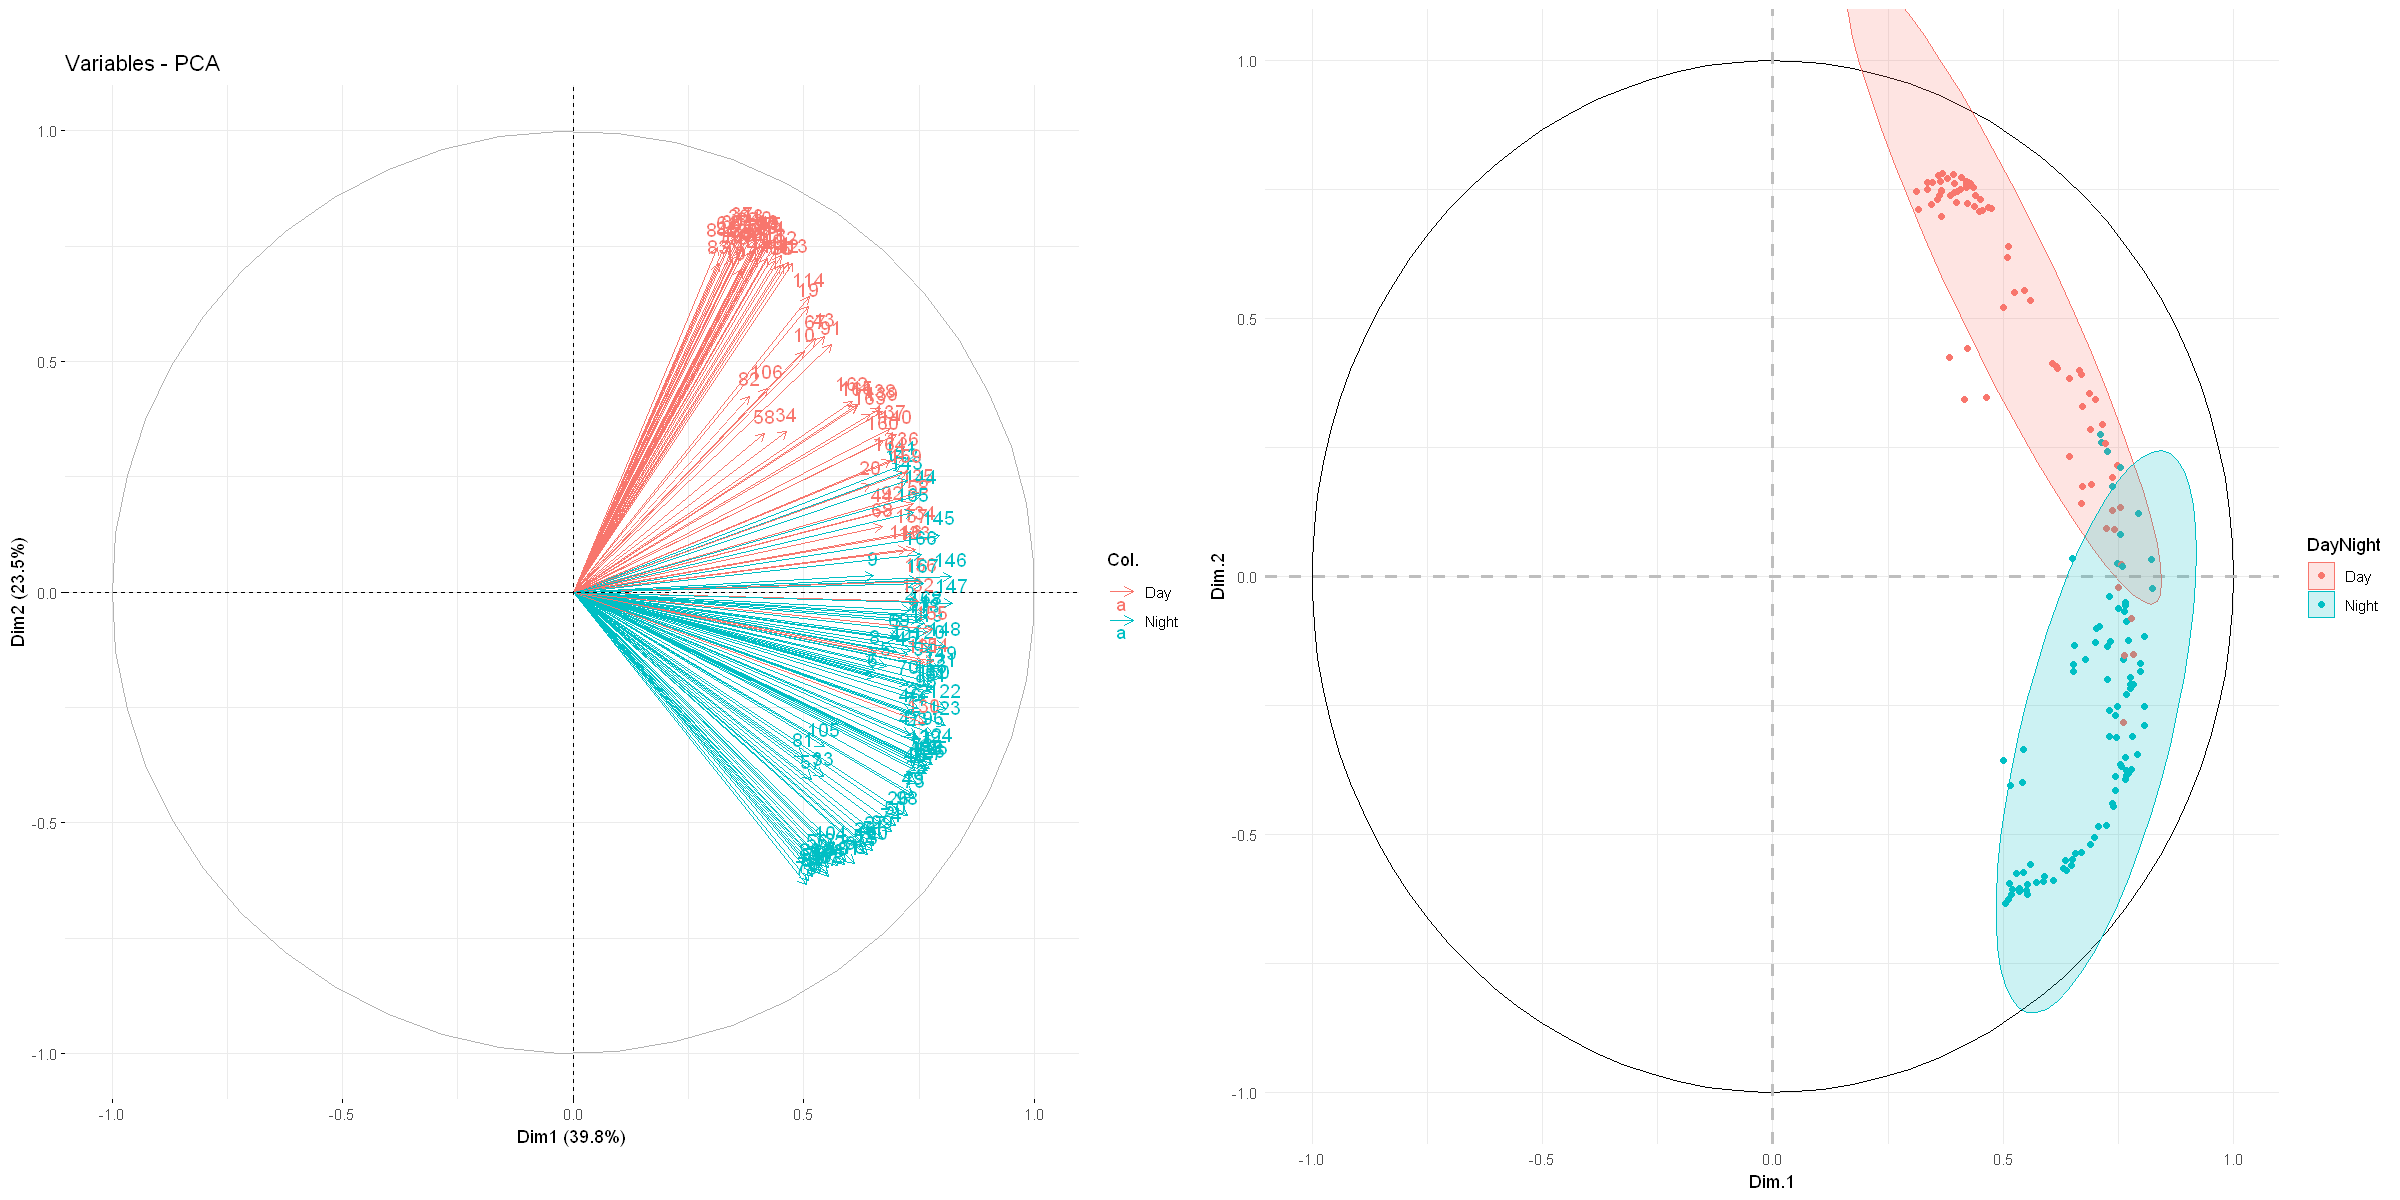

In [13]:
variable_names <- colnames(data)

variable_groups <- as.character(rep(0:23, times = 7))

pca_vars <- get_pca_var(pca)

pca_df <- as.data.frame(pca_vars$coord)

pca_df$Heure <- variable_groups

pca_df$DayNight <- ifelse(pca_df$Heure %in% c("20", "21", "22", "23", "0", "1", "2", "3", "4", "5", "6", "7","8"), "Night", "Day")

variable_groups_1 <- rep(c(rep("Night", times = 9), rep("Day", times = 11), rep("Night", times = 4)), times = 7)

grid.arrange(
  fviz_pca_var(pca, axes = c(1, 2), col.var = variable_groups_1),
  ggplot(pca_df, aes(x = Dim.1, y = Dim.2, color = DayNight)) +
    geom_point() +
    geom_path(data = circle_data, aes(x, y), color = "black", size = 0.1) +
    geom_hline(yintercept = 0, linetype = "dashed", color = "gray", size = 1) +  
    geom_vline(xintercept = 0, linetype = "dashed", color = "gray", size = 1) +  
    stat_ellipse(level = 0.95, geom = "polygon", aes(fill = DayNight), alpha = 0.2) +
    theme_minimal() +
    coord_cartesian(xlim = c(-1, 1), ylim = c(-1, 1)),
  
  ncol=2
)





- Ici, je divise les temps en jour et nuit. Le jour s'étend de 9h à 19h et la nuit correspond aux heures restantes.
- La deuxième composante principale représente le contraste entre les variables de coordonnées positives et négatives. En regardant le graphique de droite, on constate que ces deux types de variables sont assez liées à la nuit et au jour de la semaine. La deuxième composante principale met donc en évidence le contraste entre le « loading » jour et le « loading » nuit.

### Graphique de gauche : représentation des variables PCA

- Il existe une distinction claire entre les variables affectant le jour et la nuit, notamment selon Dim2. Cela montre que les variables contribuant à Dim2 présentent des différences significatives entre le jour et la nuit.
- Les variables diurnes ont tendance à être du côté positif de Dim2, tandis que les variables nocturnes sont du côté négatif, montrant une relation opposée entre les activités ou les caractéristiques diurnes et nocturnes.

### Graphique de droite : répartition des données selon PCA

Caractéristique:
Ce graphique présente la répartition des points de données selon deux composantes principales pour le jour et la nuit. Les points sont colorés en conséquence et entourés d'ellipses pour indiquer le degré de dispersion.

Commentaire:
- Les points de données pour le jour (rouge) et la nuit (bleu) ont des distributions différentes sur l'axe Dim2, montrant que l'activité entre le jour et la nuit a des caractéristiques nettement différentes.
- Les données diurnes ont une plus grande dispersion sur Dim2 que la nuit, probablement en raison de la diversité des activités pendant la journée.
- Bien que les deux groupes de données soient principalement concentrés le long de l’axe Dim2, le chevauchement entre eux est assez faible, indiquant une distinction claire entre les variables et activités diurnes et nocturnes.

## Clustering avec K-means:

### Sur les donné original:

#### Méthode Elbow

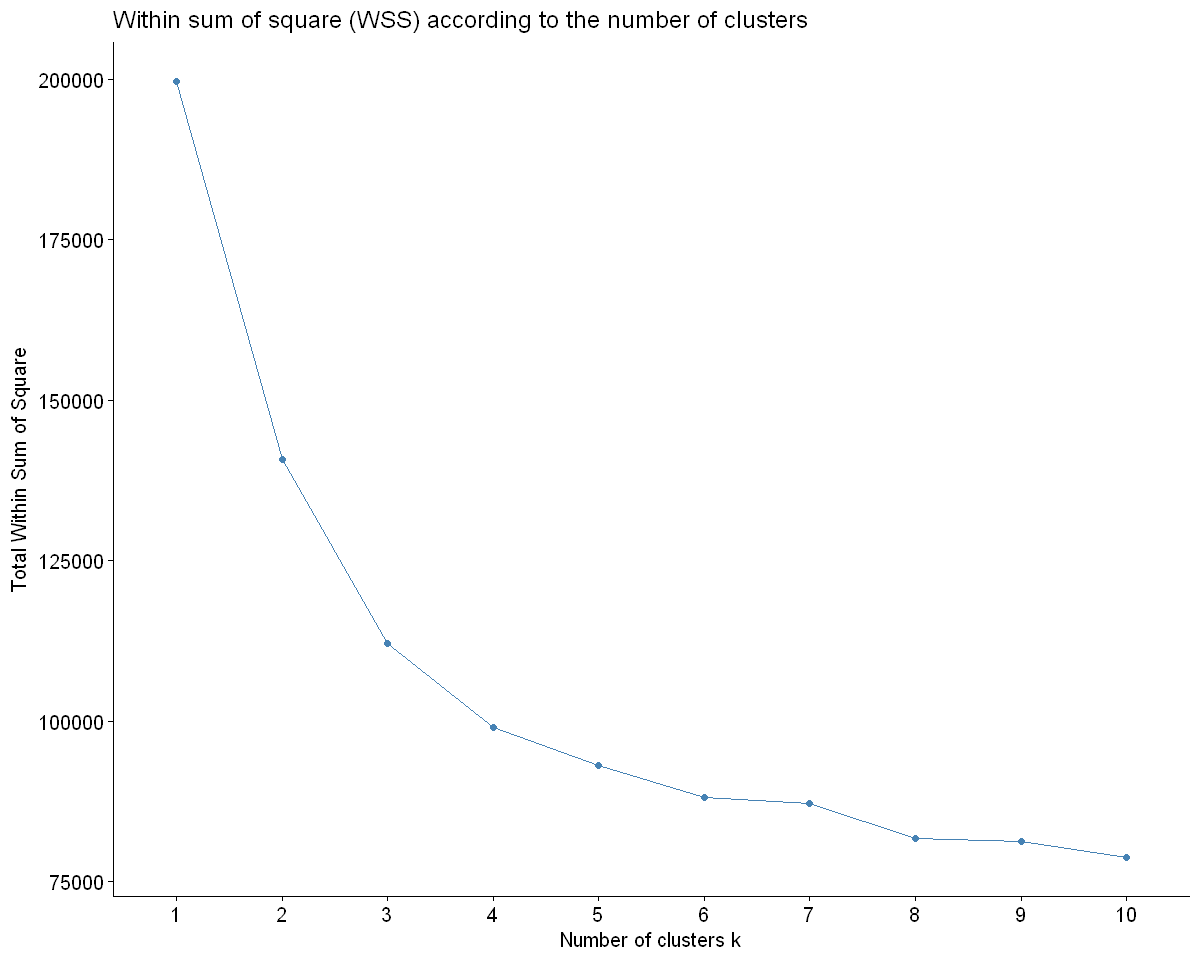

In [14]:
options(repr.plot.width = 10, repr.plot.height = 8)
fviz_nbclust(data_scale[,-c(1,2,3,4)], FUNcluster=kmeans, method="wss") +
    ggtitle("Within sum of square (WSS) according to the number of clusters")

#### Méthode Sihouette Score

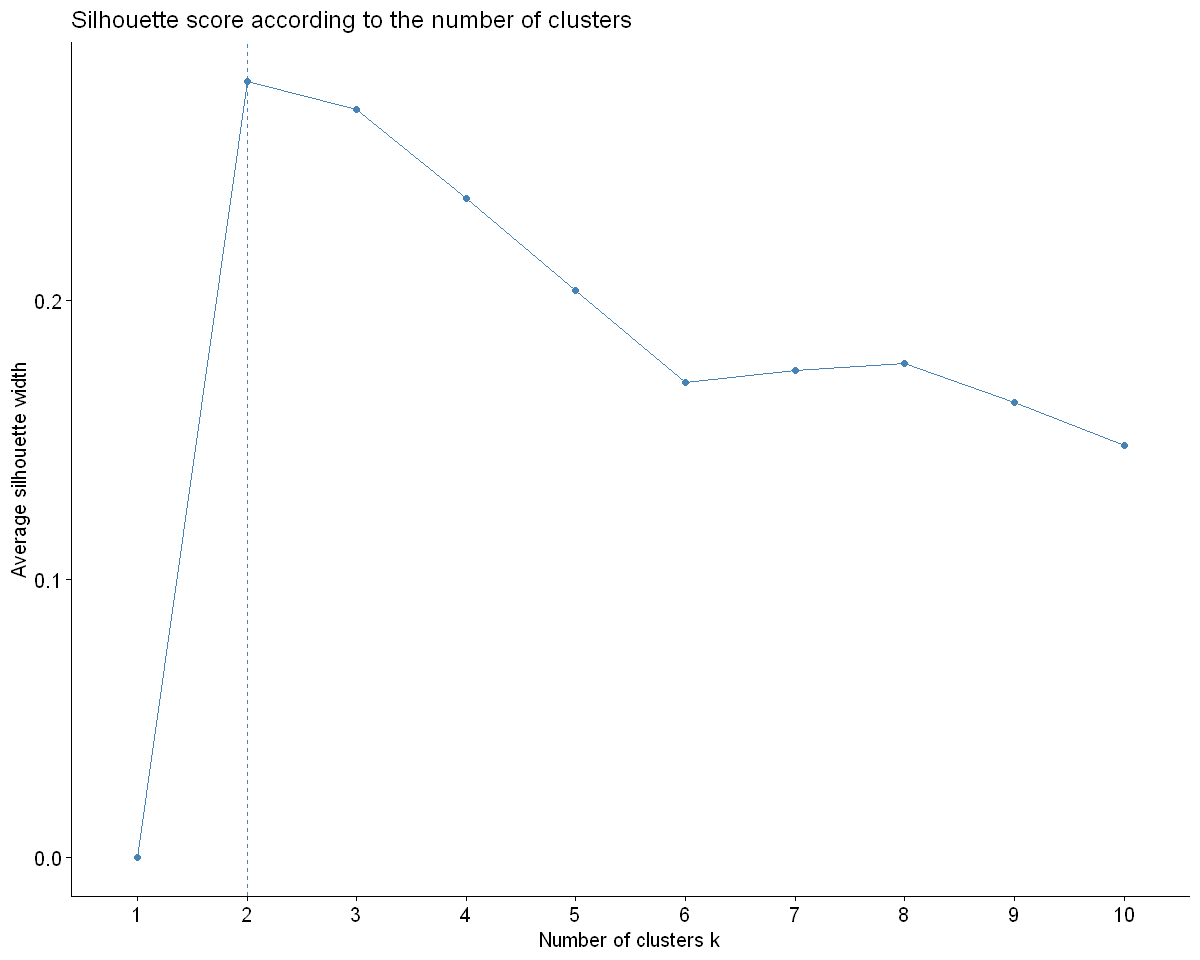

In [15]:
library(factoextra)

fviz_nbclust(data_scale[, -c(1, 2, 3, 4)], FUNcluster=kmeans, method="silhouette", k.max = 10, verbose = FALSE) +
  ggtitle("Silhouette score according to the number of clusters") 


- Le nombre optimal de clusters selon: Le nombre de 4 clusters est déterminé comme étant le nombre optimal de clusters car c'est à ce point que la valeur de WSS commence à diminuer lentement lorsque le nombre de clusters augmente. Cela indique que l'augmentation du nombre de clusters au-delà de 4 n'apporte pas d'amélioration significative en termes de réduction du WSS.
- Lorsque le nombre de clusters est de 2, le graphique Silhouette montre un niveau élevé de similarité entre les points au sein d'un même cluster et une différence nette entre les deux clusters. Cela indique que diviser les données en deux clusters créera une classification claire et distincte.

=> Nous essaierons avec le nombre de clustering K variant de 2 à 5 clusters

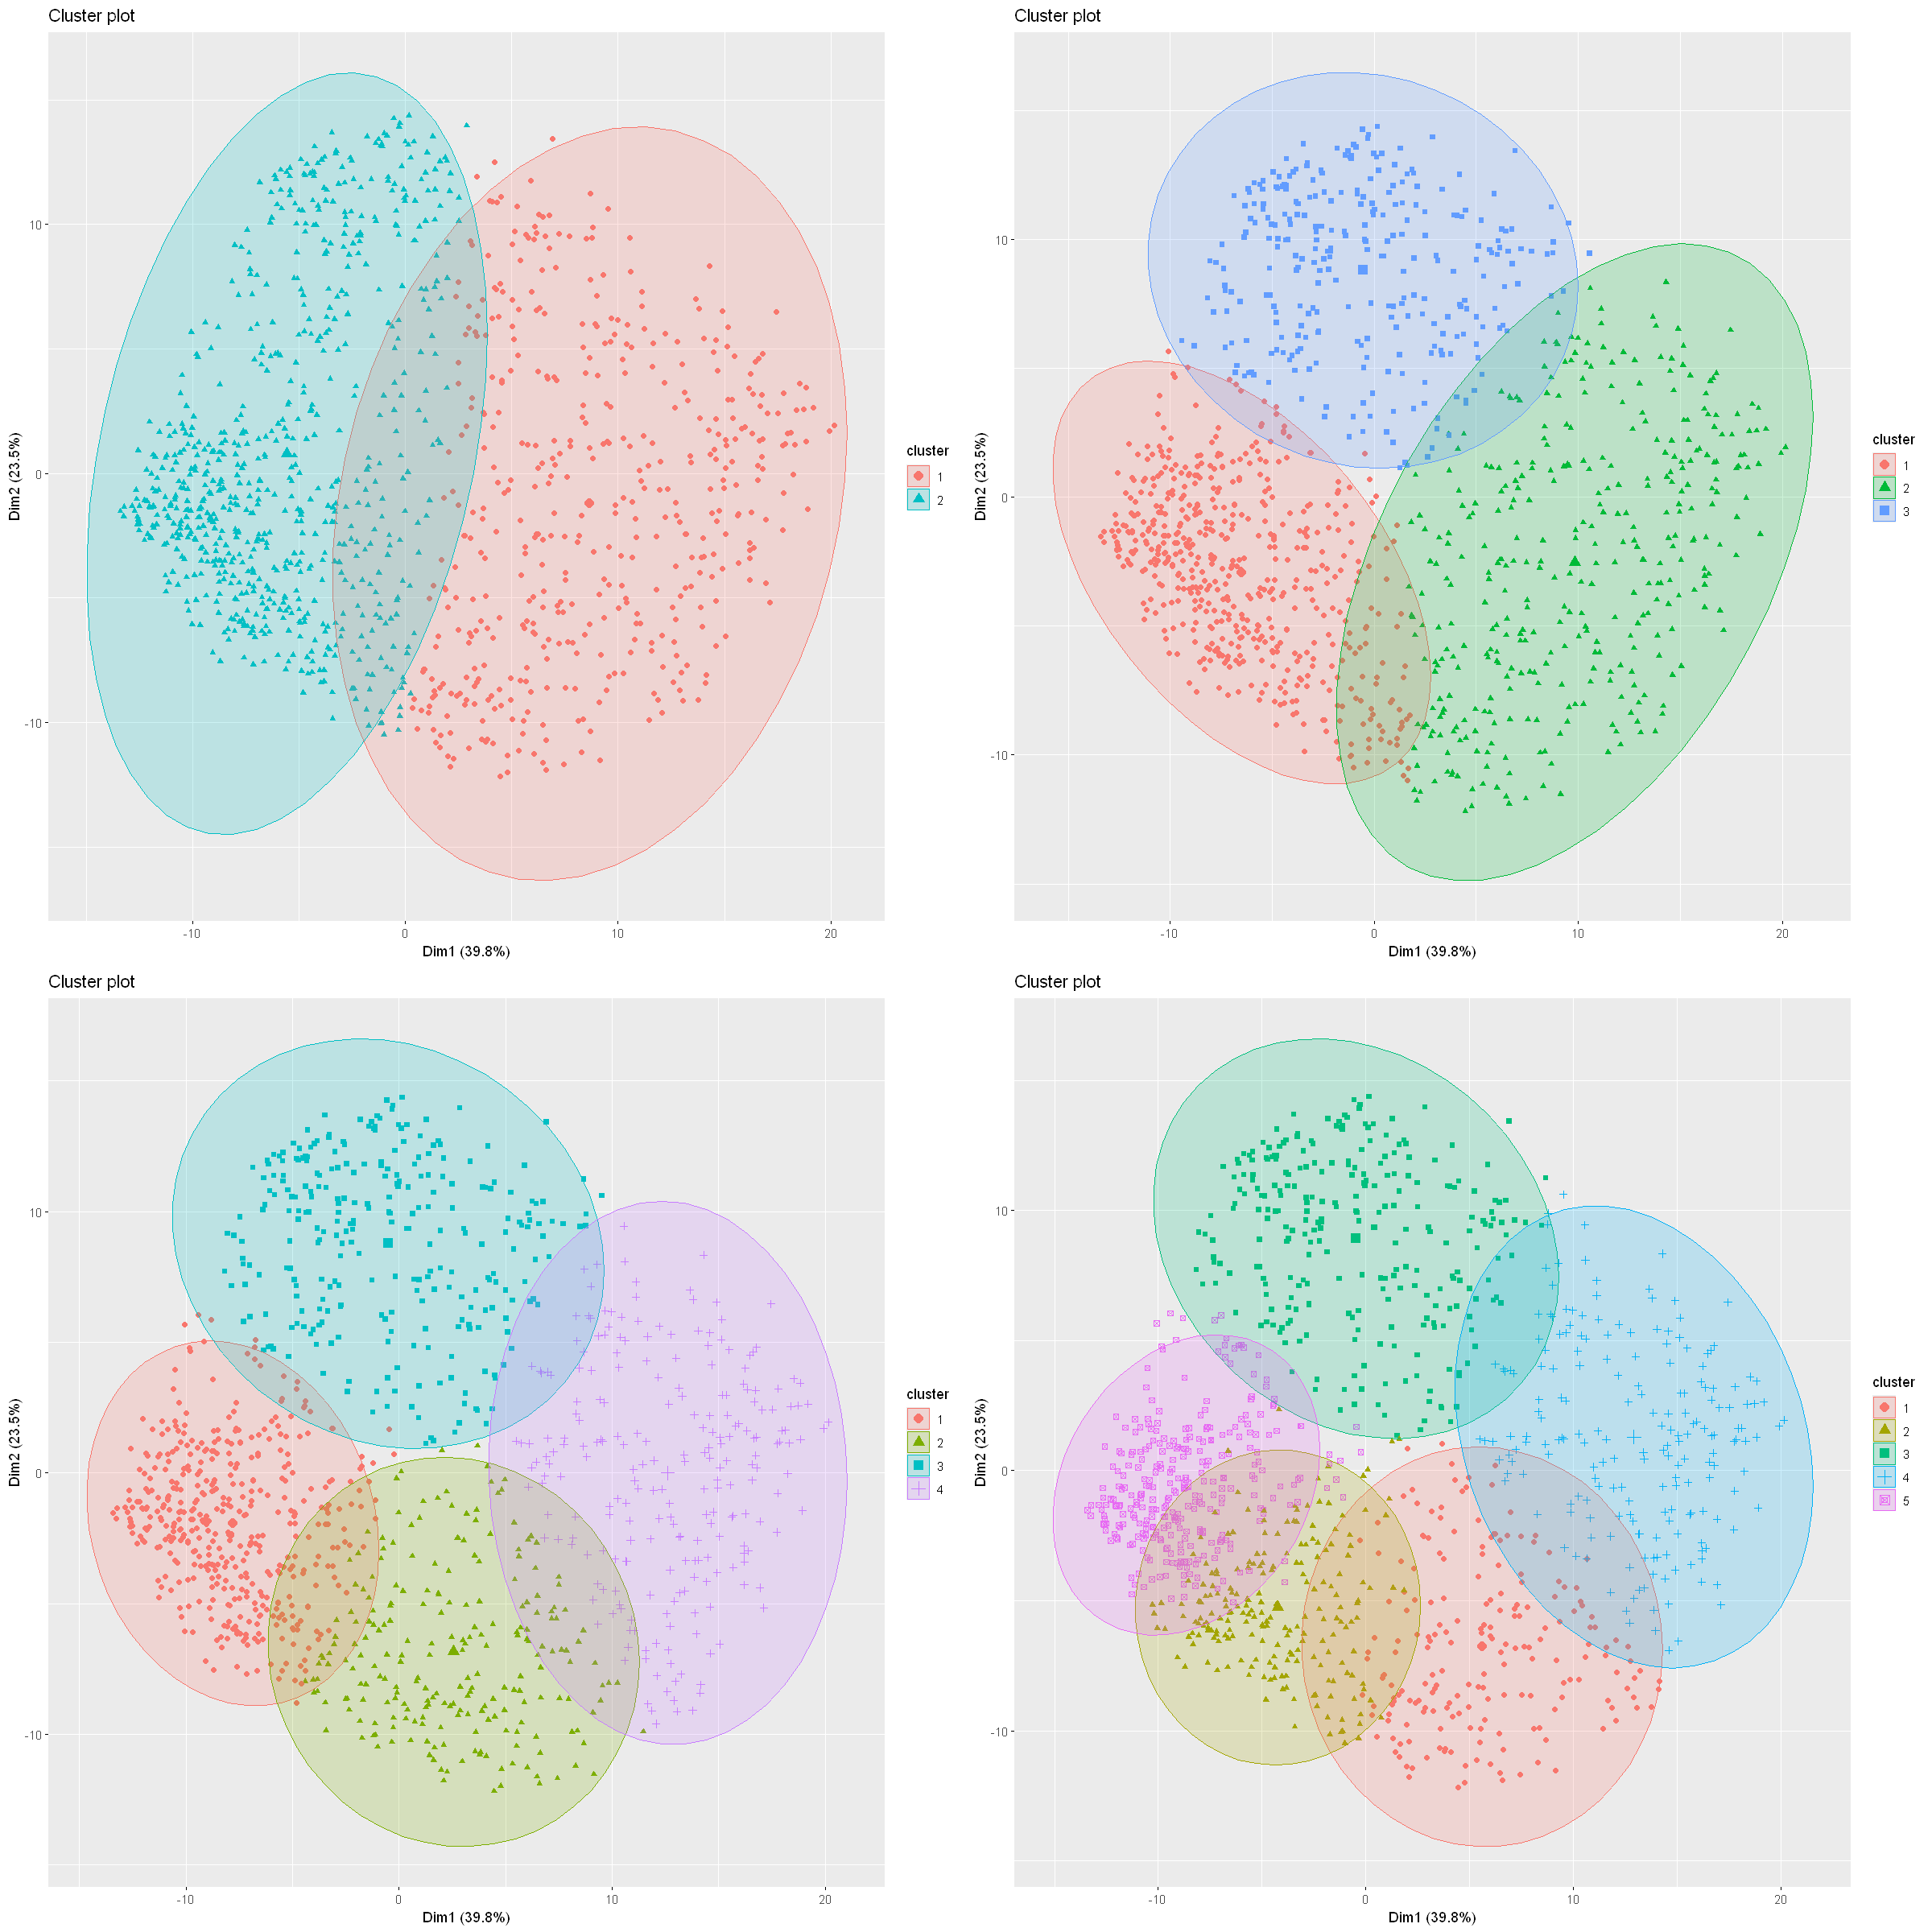

In [16]:
options(repr.plot.width = 20, repr.plot.height = 20)
k_values <- c(2, 3, 4, 5)

cluster_results <- list()

cluster_plots <- list()

for (k in k_values) {
  reskmeans <- kmeans(data_scale[, -c(1, 2, 3, 4)], centers = k)
  cluster_results[[as.character(k)]] <- reskmeans$cluster
  cluster_plots[[as.character(k)]] <- fviz_cluster(reskmeans, data = data_scale[, -c(1, 2, 3, 4)], geom = "point", ellipse.type = "norm")
}

grid.arrange(grobs = cluster_plots, ncol = 2)


 Nous voyons ici, avec des nombres de clusters de 3 et 4, que l'ensemble de données est assez bien regroupé avec relativement peu de chevauchement entre les clusters.

     cluster
bonus   1   2   3   4
    0 232 233 322 275
    1   6   1 119   1

[1] "93.7% des stations sont situées sur la colline dans le cluster 3 du regroupement k-means."


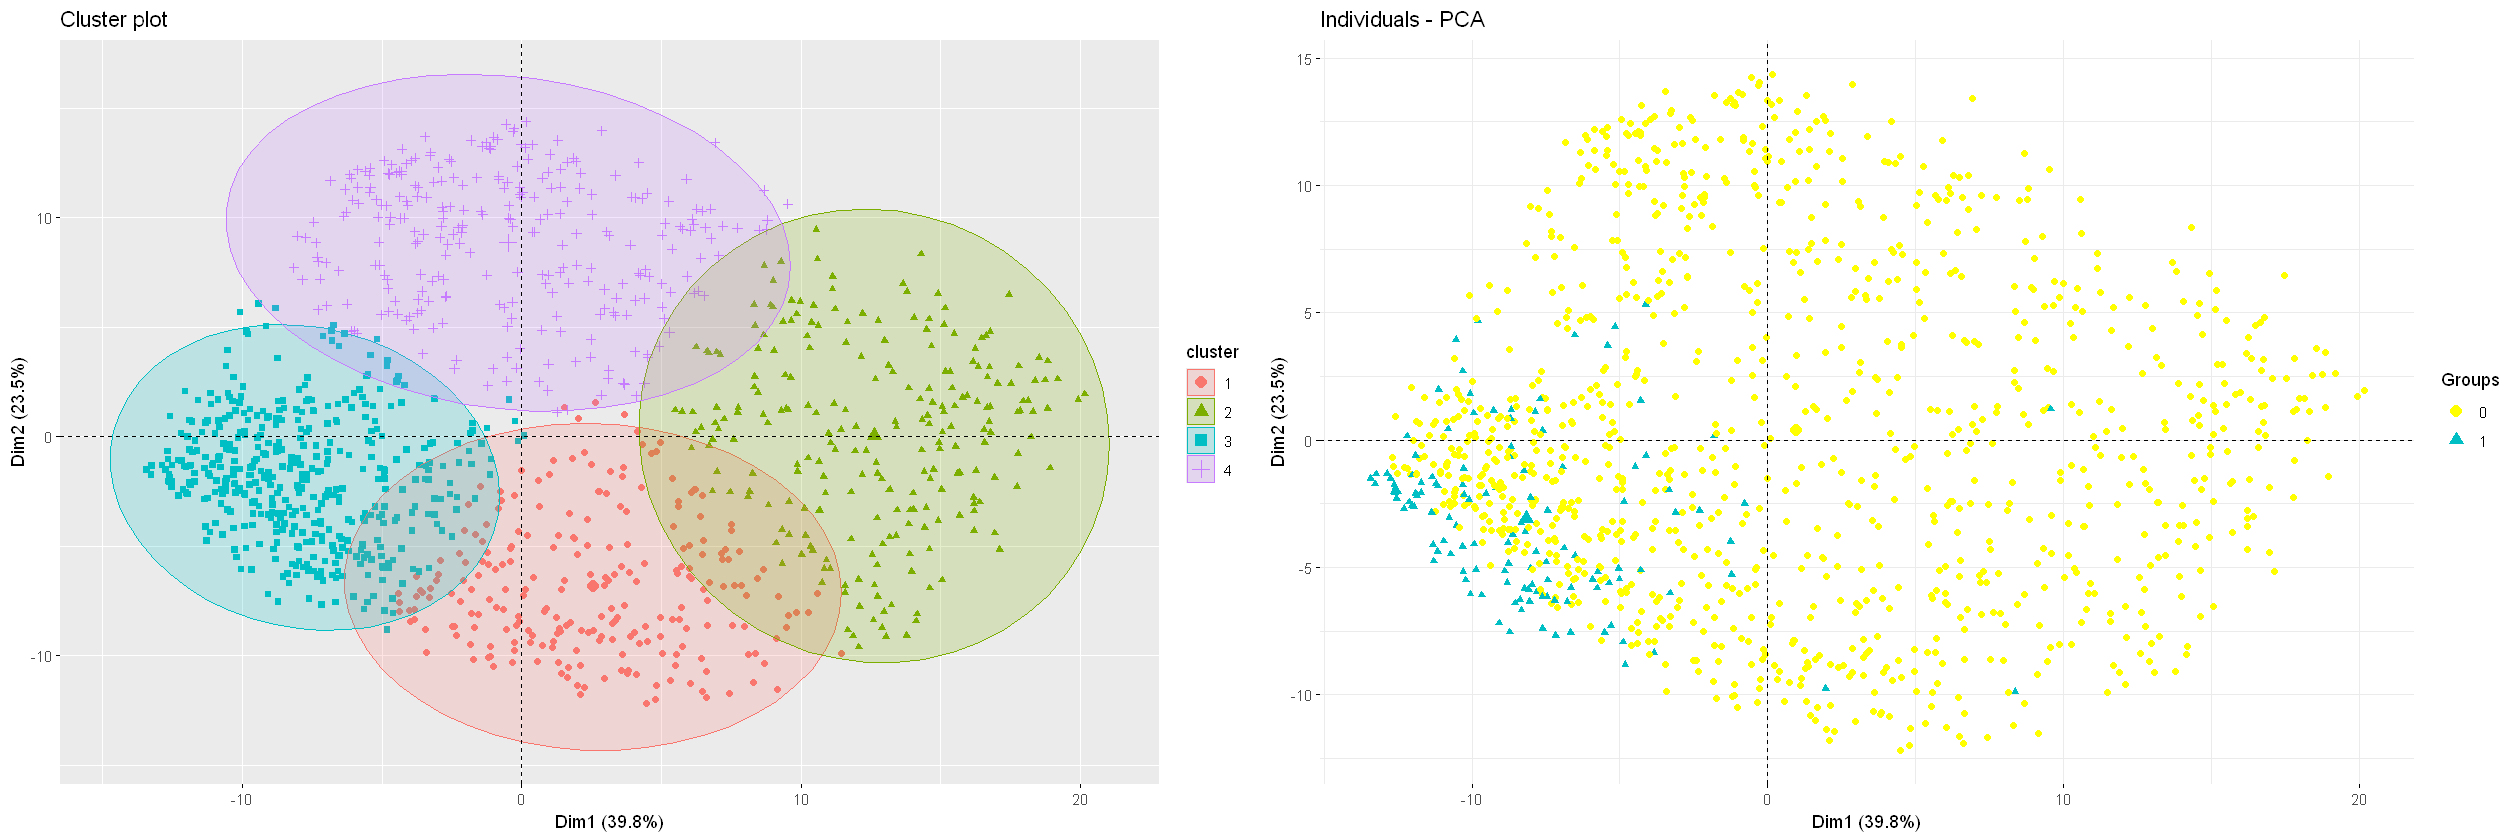

In [17]:
reskmeans = kmeans(data_scale[,-c(1,2,3,4)], centers=4) 
while (as.numeric(reskmeans$cluster[1])!=1 || as.numeric(reskmeans$cluster[3])!=4 || as.numeric(reskmeans$cluster[9])!=2) {
  reskmeans = kmeans(data[,-c(1,2,3,4)], centers=4) 
}
data_1 <- data


data_1$cluster <- reskmeans$cluster
data_1$cluster <- factor(data_1$cluster,levels = c("1", "2","3","4"))
options(repr.plot.width = 21, repr.plot.height = 7)

my_palette <- c("yellow", "#00BFC4")
grid.arrange(
    fviz_cluster(reskmeans, data=data_scale[,-c(1,2,3,4)], ellipse.type="norm", labelsize=8, geom=c("point"))+geom_hline(yintercept = 0, linetype = "dashed", color = "black") +geom_vline(xintercept = 0, linetype = "dashed", color = "black"),
    fviz_pca_ind(pca, axes=c(1,2), geom=c("point"), habillage=data_1$bonus, palette = my_palette),
    ncol=2
)
table_data <- table(bonus = data_1$bonus, cluster = data_1$cluster)
table_data
rate=table_data[2,3]/sum(table_data[2,])*100
print(sprintf("%.1f%% des stations sont situées sur la colline dans le cluster 3 du regroupement k-means.", rate))

Ici, on divise les stations en 4 clusters selon wss. Dans l'image de gauche, on dessin 4 clusters sur le plan dim1, dim2 selon PCA. Dans le graphique de droite, on a divisé les stations en 2 groupes, où 1 représente les stations situées sur une colline ("hill") et 0 représente les stations qui ne sont pas sur une colline ("no hill"). En comparant les deux graphiques, on constate que la plupart des stations du groupe 0 appartiennent principalement au cluster 3 selon k-means. Cela signifie que la majorité des stations sur les collines appartiennent au cluster 3 de k-means. Sur la base du tableau bonus-cluster ci-dessus et de nos calculs, nous estimons que 93,7 % des stations sont situées sur une colline dans le cluster 3 du regroupement k-means.

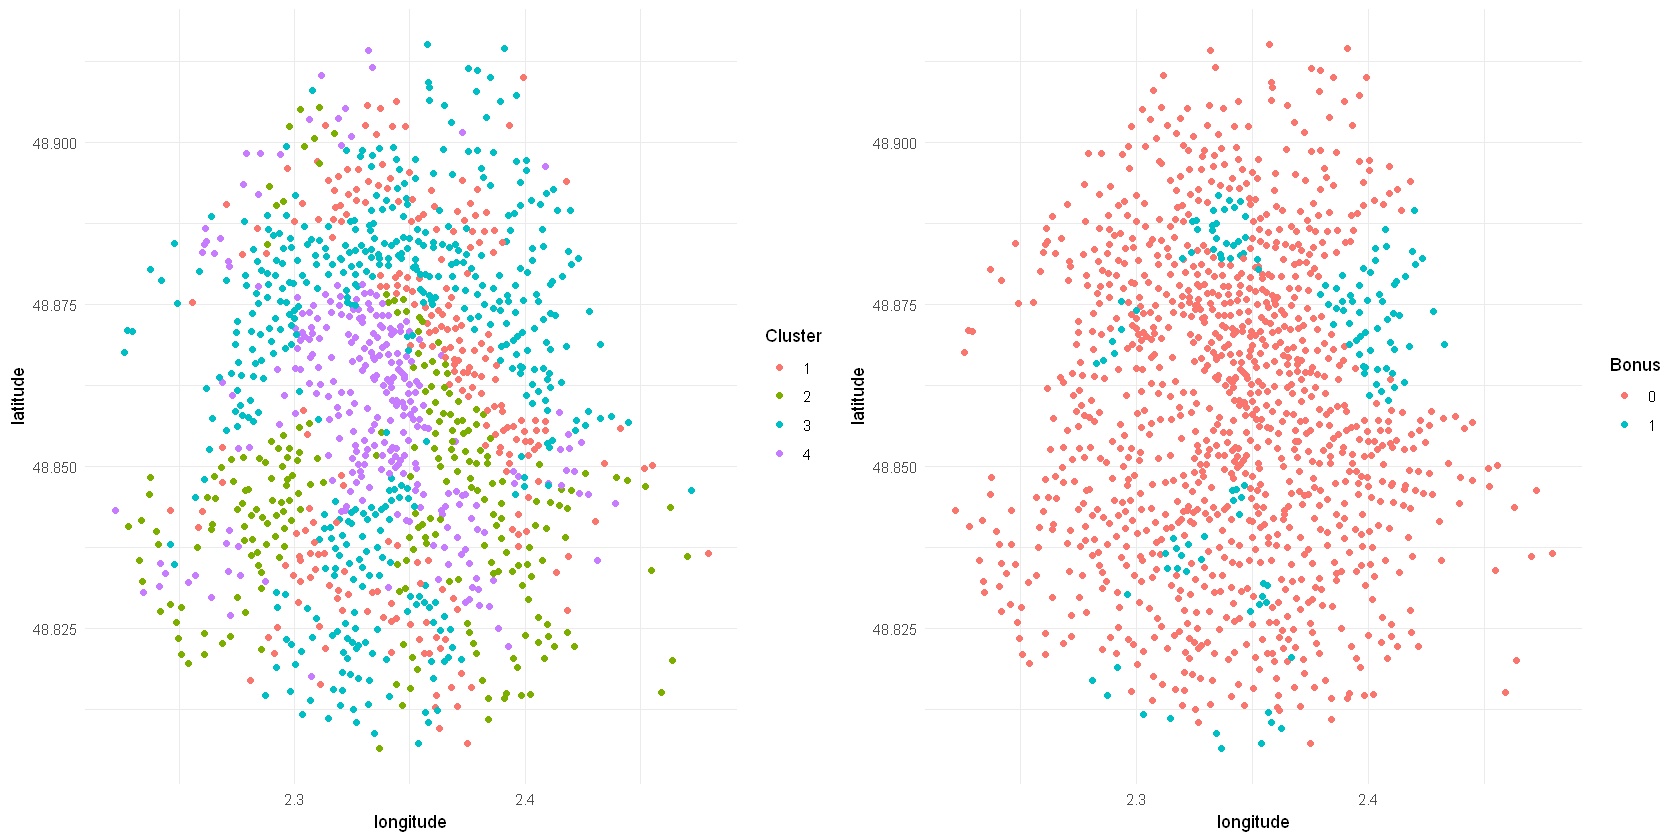

In [18]:
options(repr.plot.width = 14, repr.plot.height = 7)
grid.arrange(
    ggplot(data, aes(x = longitude, y = latitude, color = factor(reskmeans$cluster))) +
        geom_point() +
        labs(color = "Cluster") +
        theme_minimal(),
    ggplot(data, aes(x = longitude, y = latitude, color = bonus)) +
        geom_point() +
        labs(color = "Bonus") +
        theme_minimal(),
    ncol=2
)

Ici, on représente les stations dans l'espace géographique afin d'observer les clusters k-means répartis selon les coordonnées géographiques et les stations situées sur les collines ou non. On remarque ici aussi que la plupart des stations situées sur les collines appartiennent au cluster 3.

ℹ Replacing old key (7c281d48) with new key in C:\Users\nam\OneDrive\Documents/.Renviron

ℹ Using `zoom = 12`

ℹ © Stadia Maps © Stamen Design © OpenMapTiles © OpenStreetMap contributors.



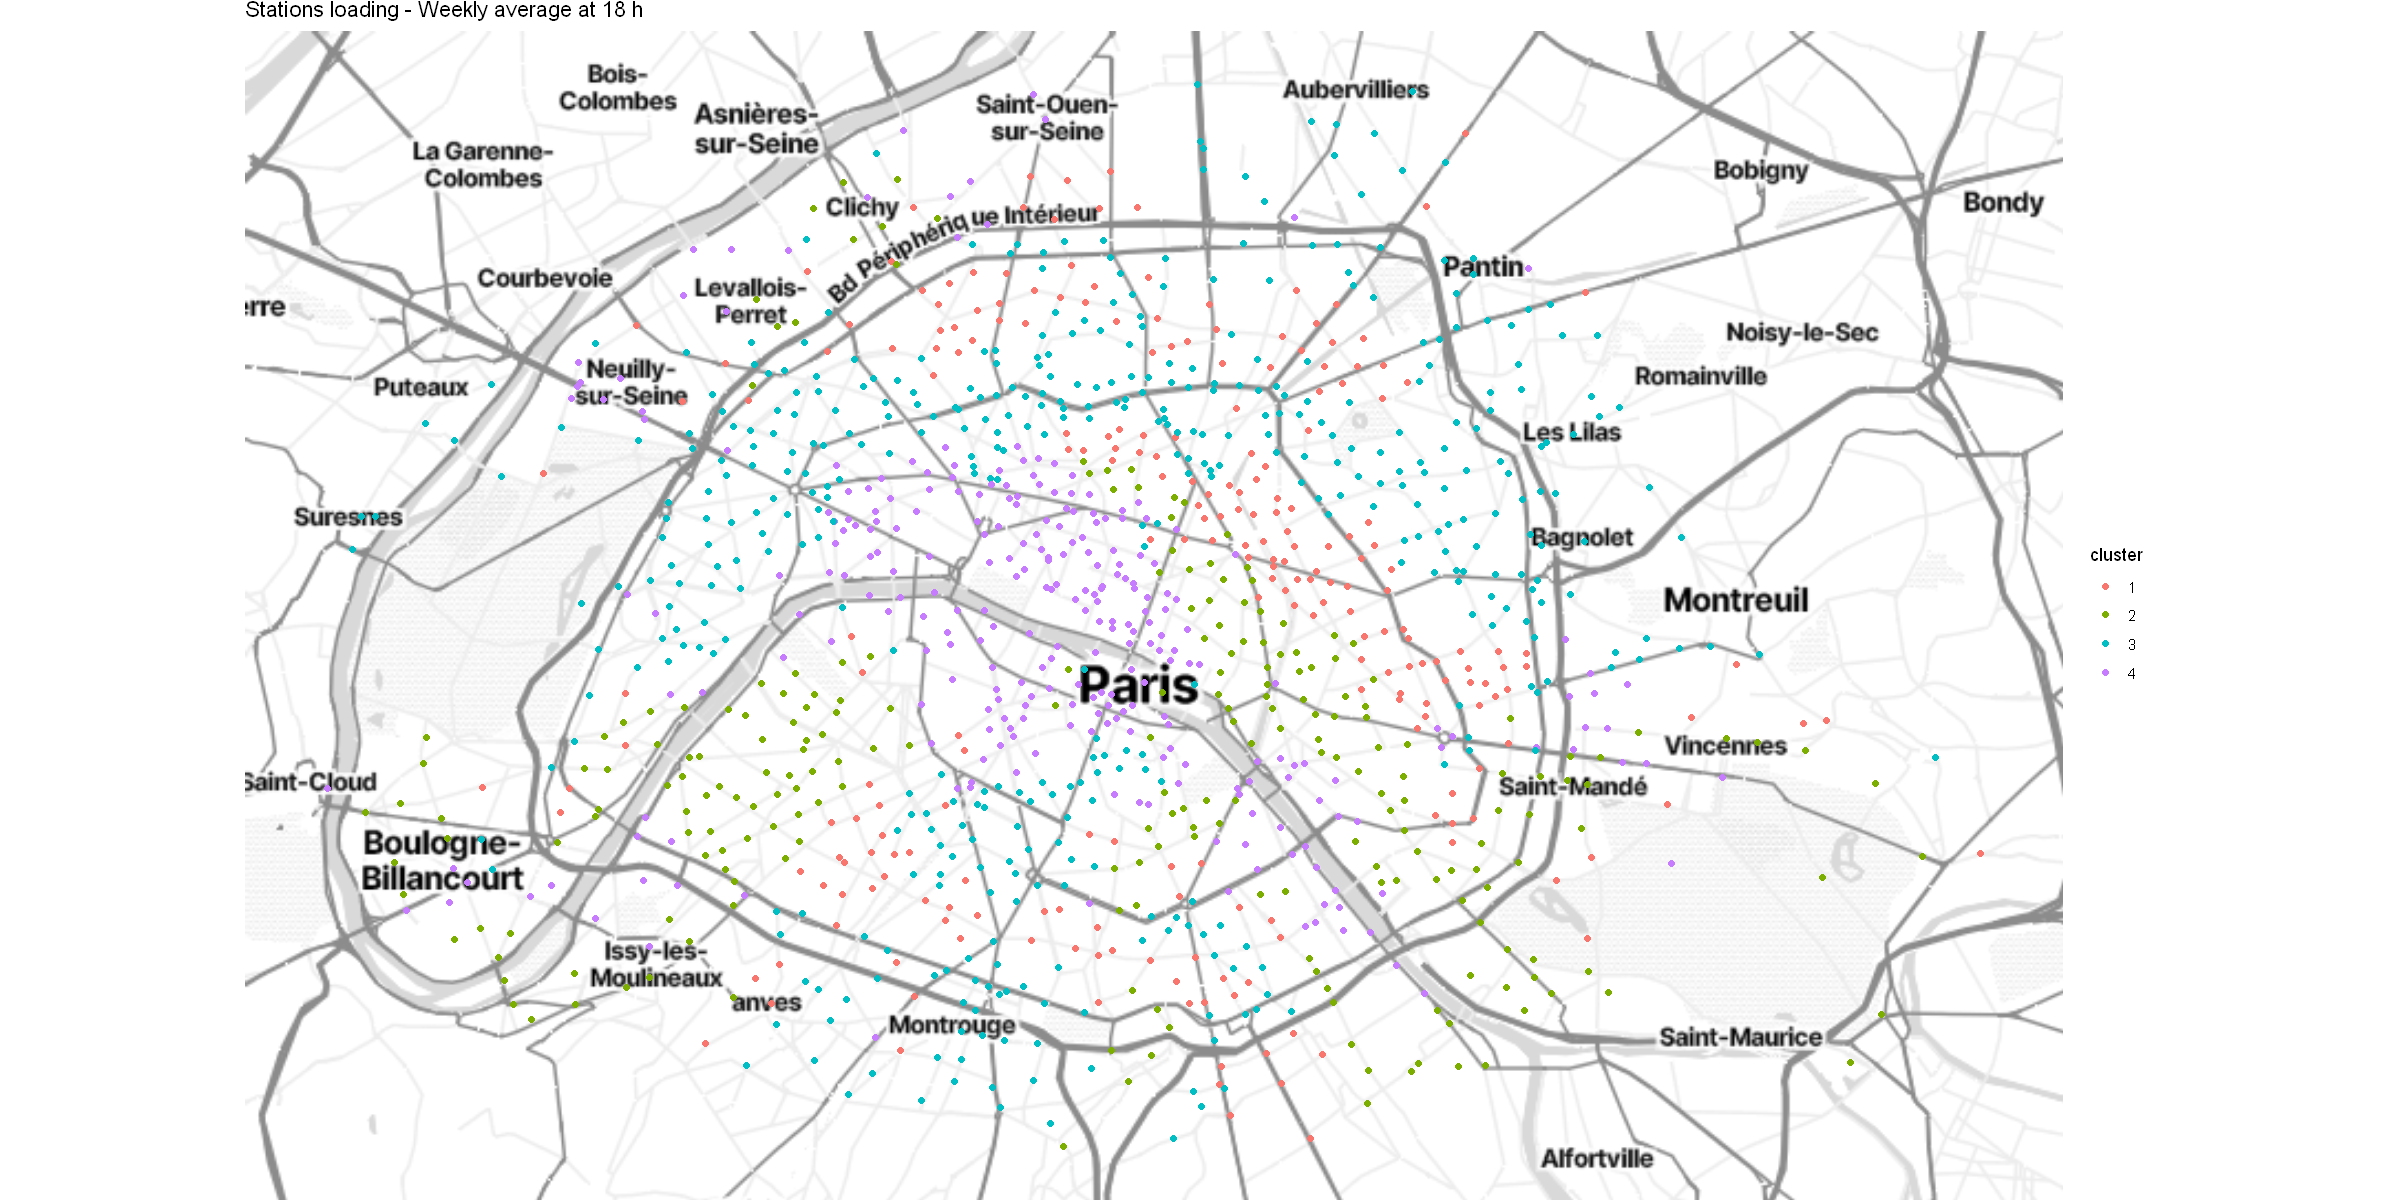

In [19]:
register_stadiamaps("7c281d48-c95f-4746-b57c-e8e5d23a476d", write = TRUE)
h     = 18
hours = seq(h, 168, 24)
load_per_hour = rowMeans(loading[,hours])

df = coord
df$loading = load_per_hour

# --- #

options(repr.plot.width = 20, repr.plot.height = 10)

qmplot(data=data_1, longitude, latitude, color=cluster) +
    labs(title = paste('Stations loading - Weekly average at',h,'h'))


Ici, en traçant sur une Google map, nous constatons que les stations du groupe 2 se trouvent souvent près de la Seine. Les stations du groupe 3 sont généralement éloignées du centre de Paris, tandis que la plupart des stations du groupe 4 se situent au centre de Paris.

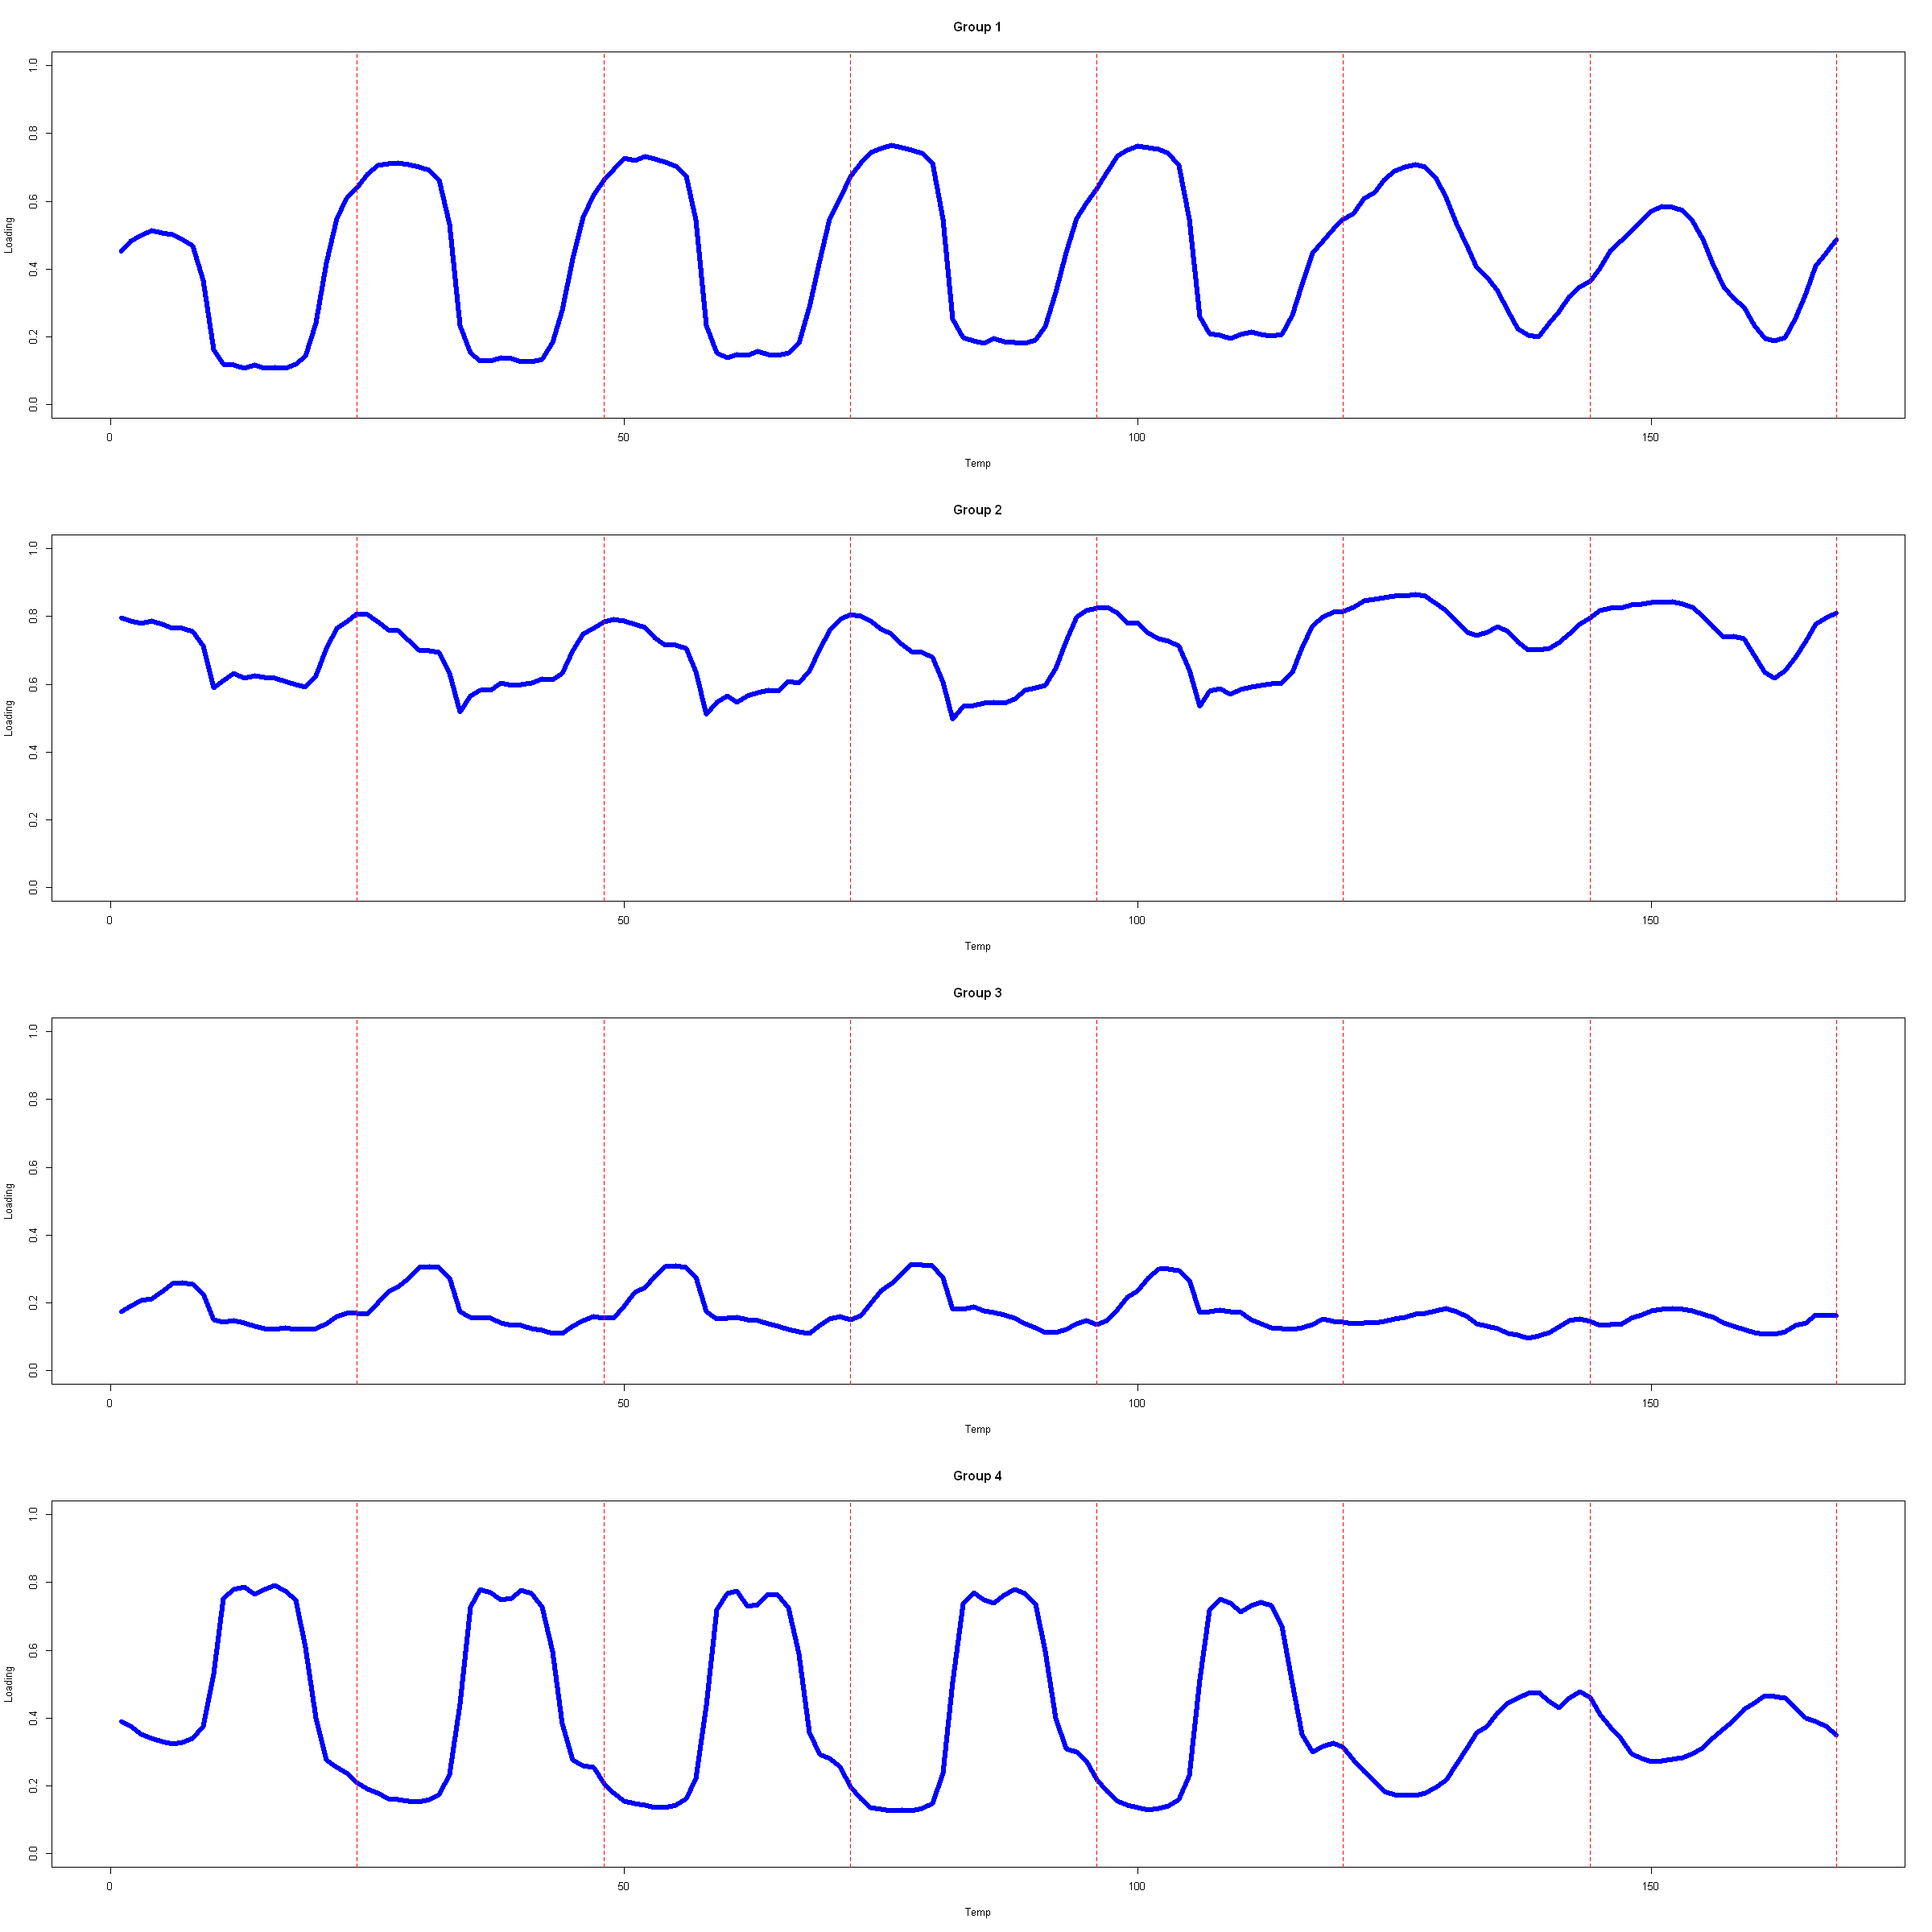

In [20]:
options(repr.plot.width = 20, repr.plot.height = 20)
par(mfrow = c(4,1))

group_names <- paste("Group", 1:nrow(reskmeans$centers))

for (i in 1:nrow(reskmeans$centers)) {

  plot(reskmeans$centers[i,], type = 'l', ylim = c(0, 1), col = "blue", lwd = 5, 
       main = group_names[i], xlab = "Temp", ylab = "Loading")
  abline(v = seq(24, 168, by = 24), col = "red", lty = 2)
  
}

##### <span style="color:purple"> J'ai tracé les graphiques des "loading" en fonction du centre de chaque cluster pour chaque période de temps. Les lignes rouges correspondent à minuit, c'est-à-dire que les points autour de la ligne rouge représentent la nuit :</span>

- On peut voir que les clusters 1 et 4 représentent les groupes de stations avec une variation élevée au cours de la journée. Dans le cluster 1, les "loading" sont élevés la nuit et bas le jour, tandis que dans le cluster 4, c'est l'inverse. Selon le graphique Google Maps précédent, on peut dire que les stations proches du centre-ville ont généralement des "loading" élevés le jour et bas la nuit.
- Les clusters 2 et 3 représentent les groupes de stations avec une variation faible au cours de la journée. Dans le cluster 2, les "loading" sont élevés à la fois le jour et la nuit, ce qui signifie que les stations près de la Seine ont tendance à avoir des "loading" élevés. Dans le cluster 3, les "loading" sont bas tout au long de la journée, ce qui signifie que les stations situées sur les collines ou éloignées du centre-ville ont tendance à avoir des "loading" bas.
- Il y a une différence entre le samedi, le dimanche et les jours de la semaine. Les variations de "loading" sont moindres durant les deux jours du week-end par rapport aux autres jours.

No id variables; using all as measure variables

No id variables; using all as measure variables

No id variables; using all as measure variables

No id variables; using all as measure variables



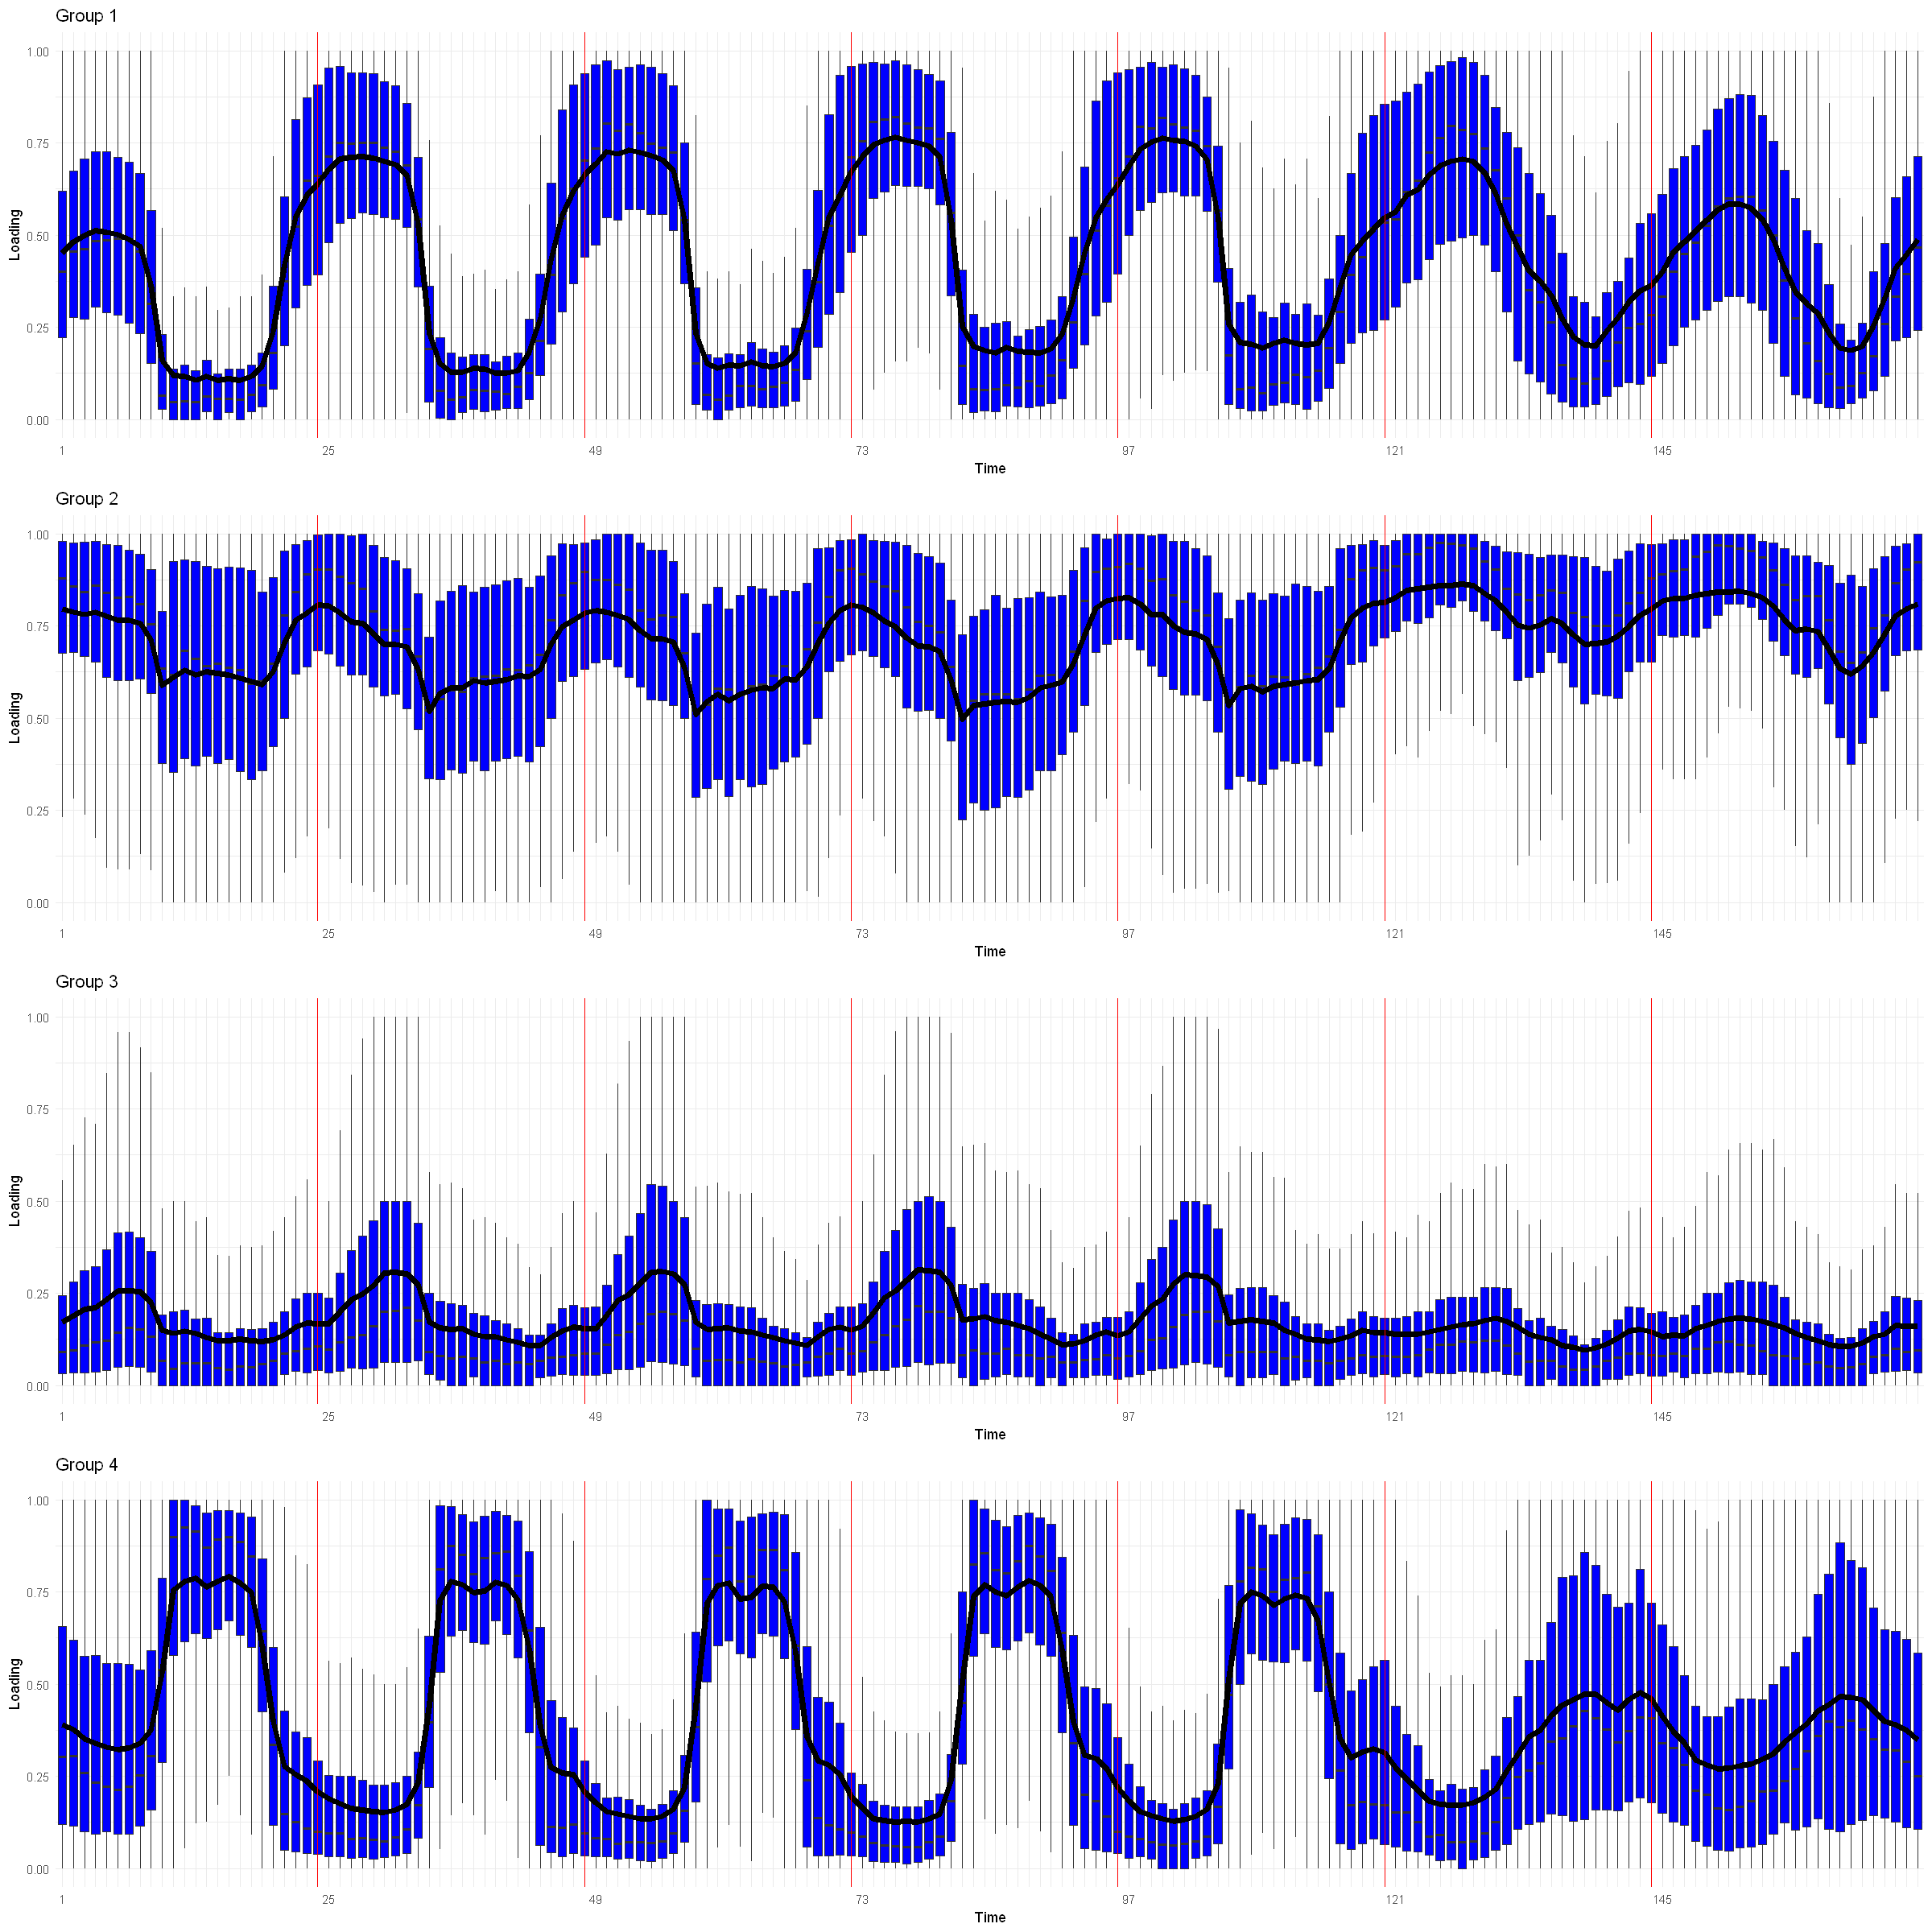

In [21]:
options(repr.plot.width = 20, repr.plot.height = 20)
plots <- list()

for (i in 1:4){
  cluster_indices <- which(reskmeans$cluster == i)
  cluster_data <- data[cluster_indices, -c(1, 2, 3, 4)]
  df <- melt(cluster_data)

  labels <- as.character(1:ncol(loading))
  labels[-c(1, 25, 49, 73, 97, 121, 145)] <- ""  

  mean_data <- aggregate(value ~ variable, data = df, FUN = mean)

  plots[[i]] <- ggplot(df, aes(x = variable, y = value)) +
    geom_boxplot(fill = "blue", outlier.shape = NA) +
    #geom_jitter(width = 0.001, alpha = 0.5) +  

    geom_line(data = mean_data, aes(group = 1), color = "black", size = 2) +

    geom_vline(xintercept = c(24, 48, 72, 96, 120, 144), color = "red", linetype = "solid") +
    scale_x_discrete(labels = labels) +  
    labs(x = "Time", y = "Loading") +  
    theme_minimal() +
    ggtitle(paste("Group", i))
}

grid.arrange(grobs = plots, ncol = 1)


J'ai tracé des boxplots supplémentaires pour les 4 graphiques correspondant aux 4 clusters précédents. J'ai observé que la variabilité autour de chaque cluster a considérablement diminué (sauf samedi et dimanche du 4ème cluster), ce qui signifie que la variance intra-classe est effectivement beaucoup plus faible que la variance totale. Cela montre que la classification k-means a bien fonctionné.

### Sur les donné de dimension réduite:

       original
reduced   1   2   3   4
      1 231   1   8   0
      2   1 233   0   0
      3   4   0 431   0
      4   2   0   2 276

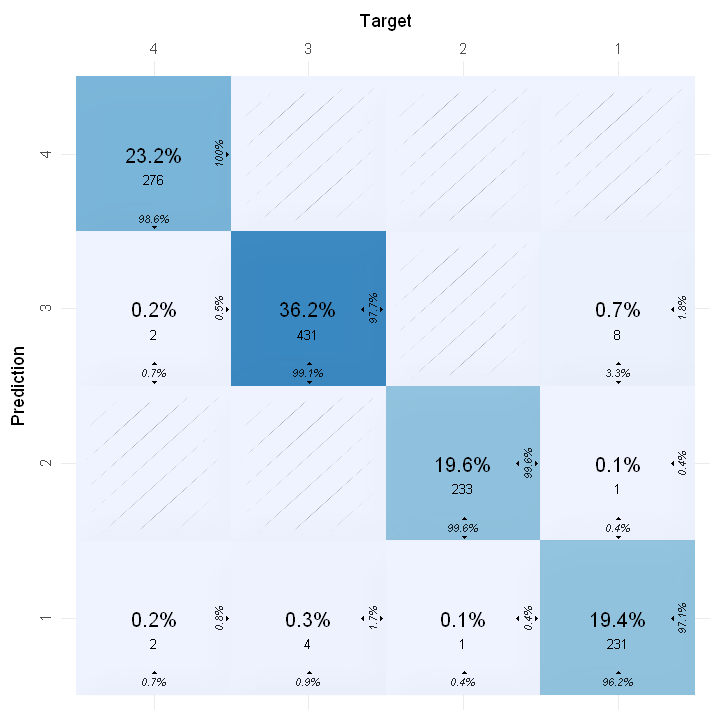

In [23]:
options(repr.plot.width = 6, repr.plot.height = 6)
reskmeans_reduced <- kmeans(pca$ind$coord[,1:2], centers = 4)
while (as.numeric(reskmeans_reduced$cluster[1])!=1 || as.numeric(reskmeans_reduced$cluster[3])!=4 || as.numeric(reskmeans_reduced$cluster[9])!=2) {
  reskmeans_reduced <- kmeans(pca$ind$coord[,1:2], centers = 4)
}

table('reduced'=reskmeans_reduced$cluster, 'original'=reskmeans$cluster)

# --- #

# With the confusion matrix
conf_mat = confusion_matrix(targets=reskmeans_reduced$cluster, predictions=reskmeans$cluster )
plot_confusion_matrix(conf_mat)

Nous effectuons ici un clustering sur les donné de dimension réduite en utilisant k-means (4 clusters). Nous constatons que le clustering sur les données réduites en dimension et les données originales est très similaire grâce à la matrice de confusion. Ainsi, on peut dire que l'application de la PCA dans le clustering k-means est très efficace.




     cluster
bonus   1   2   3   4
    0 233 233 318 278
    1   7   1 117   2

[1] "92.1% des stations sont situées sur la colline dans le cluster 3 du regroupement k-means."


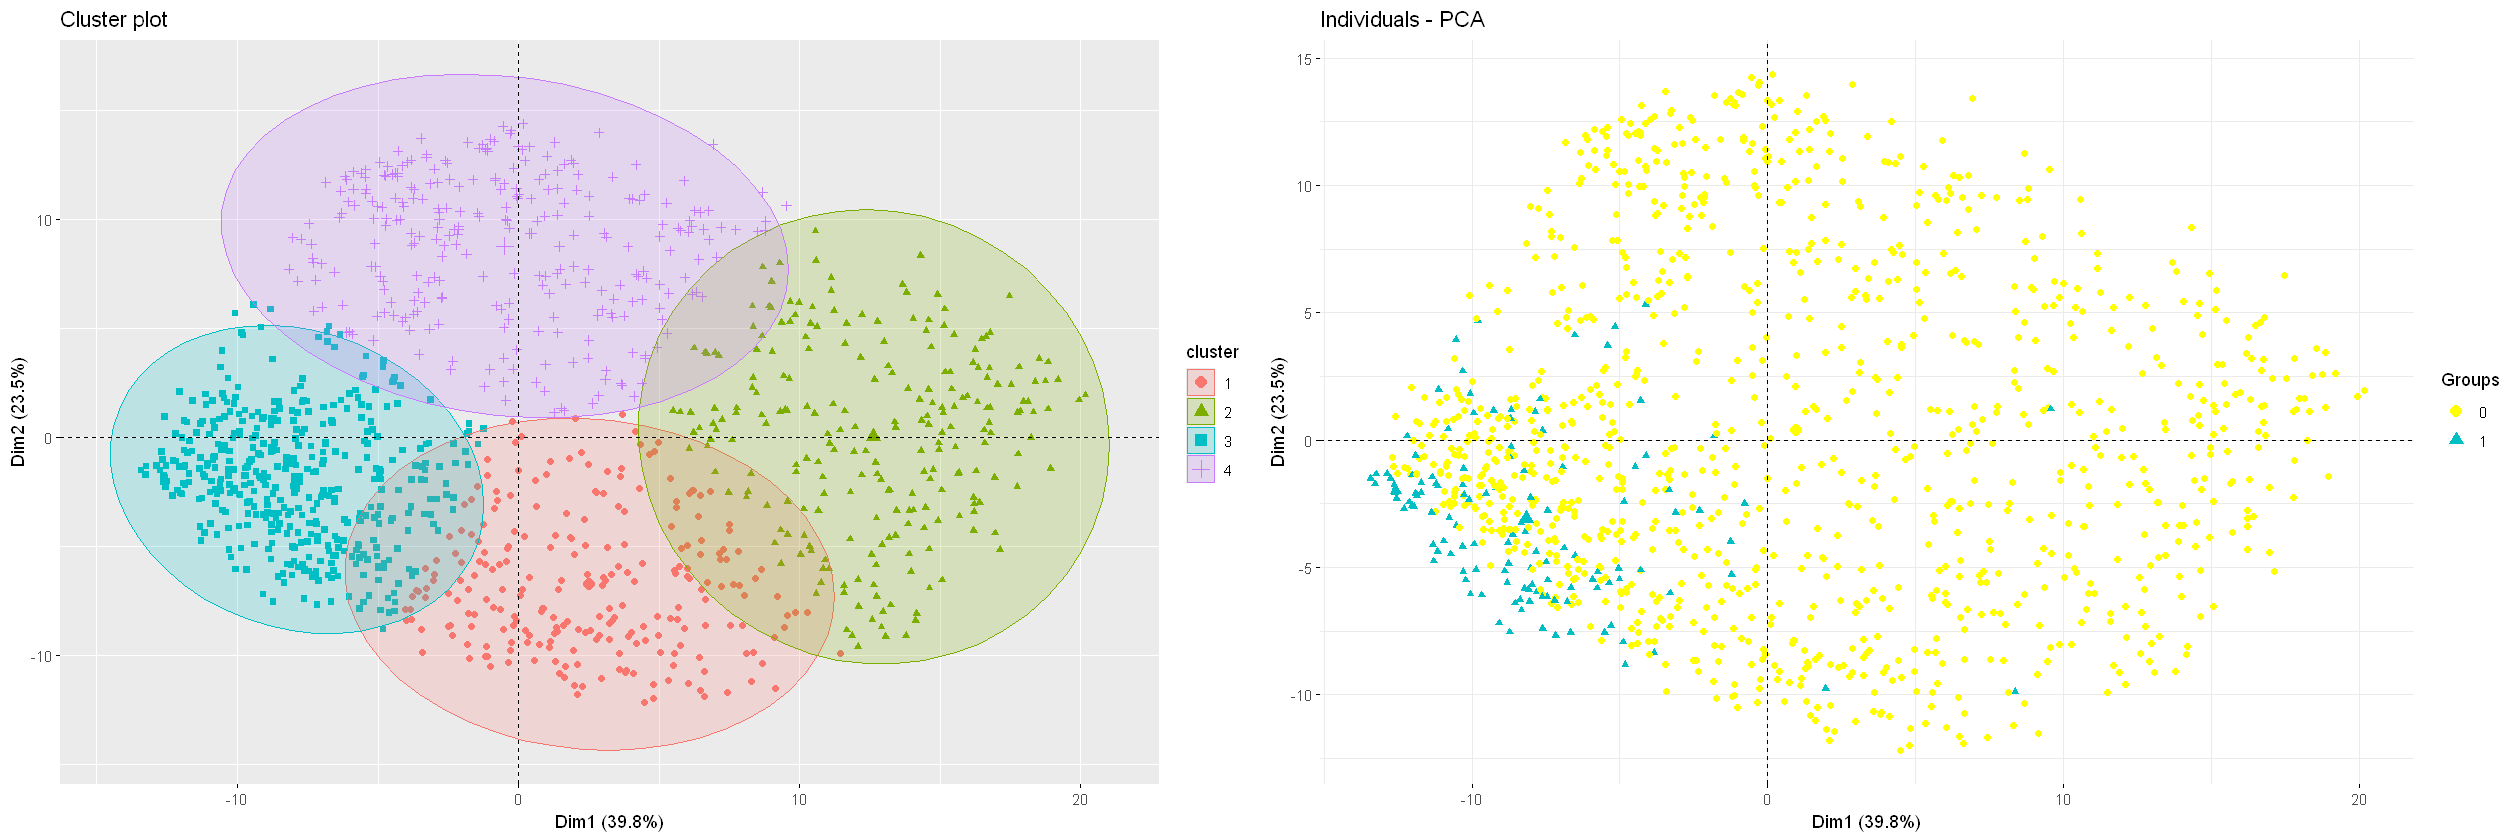

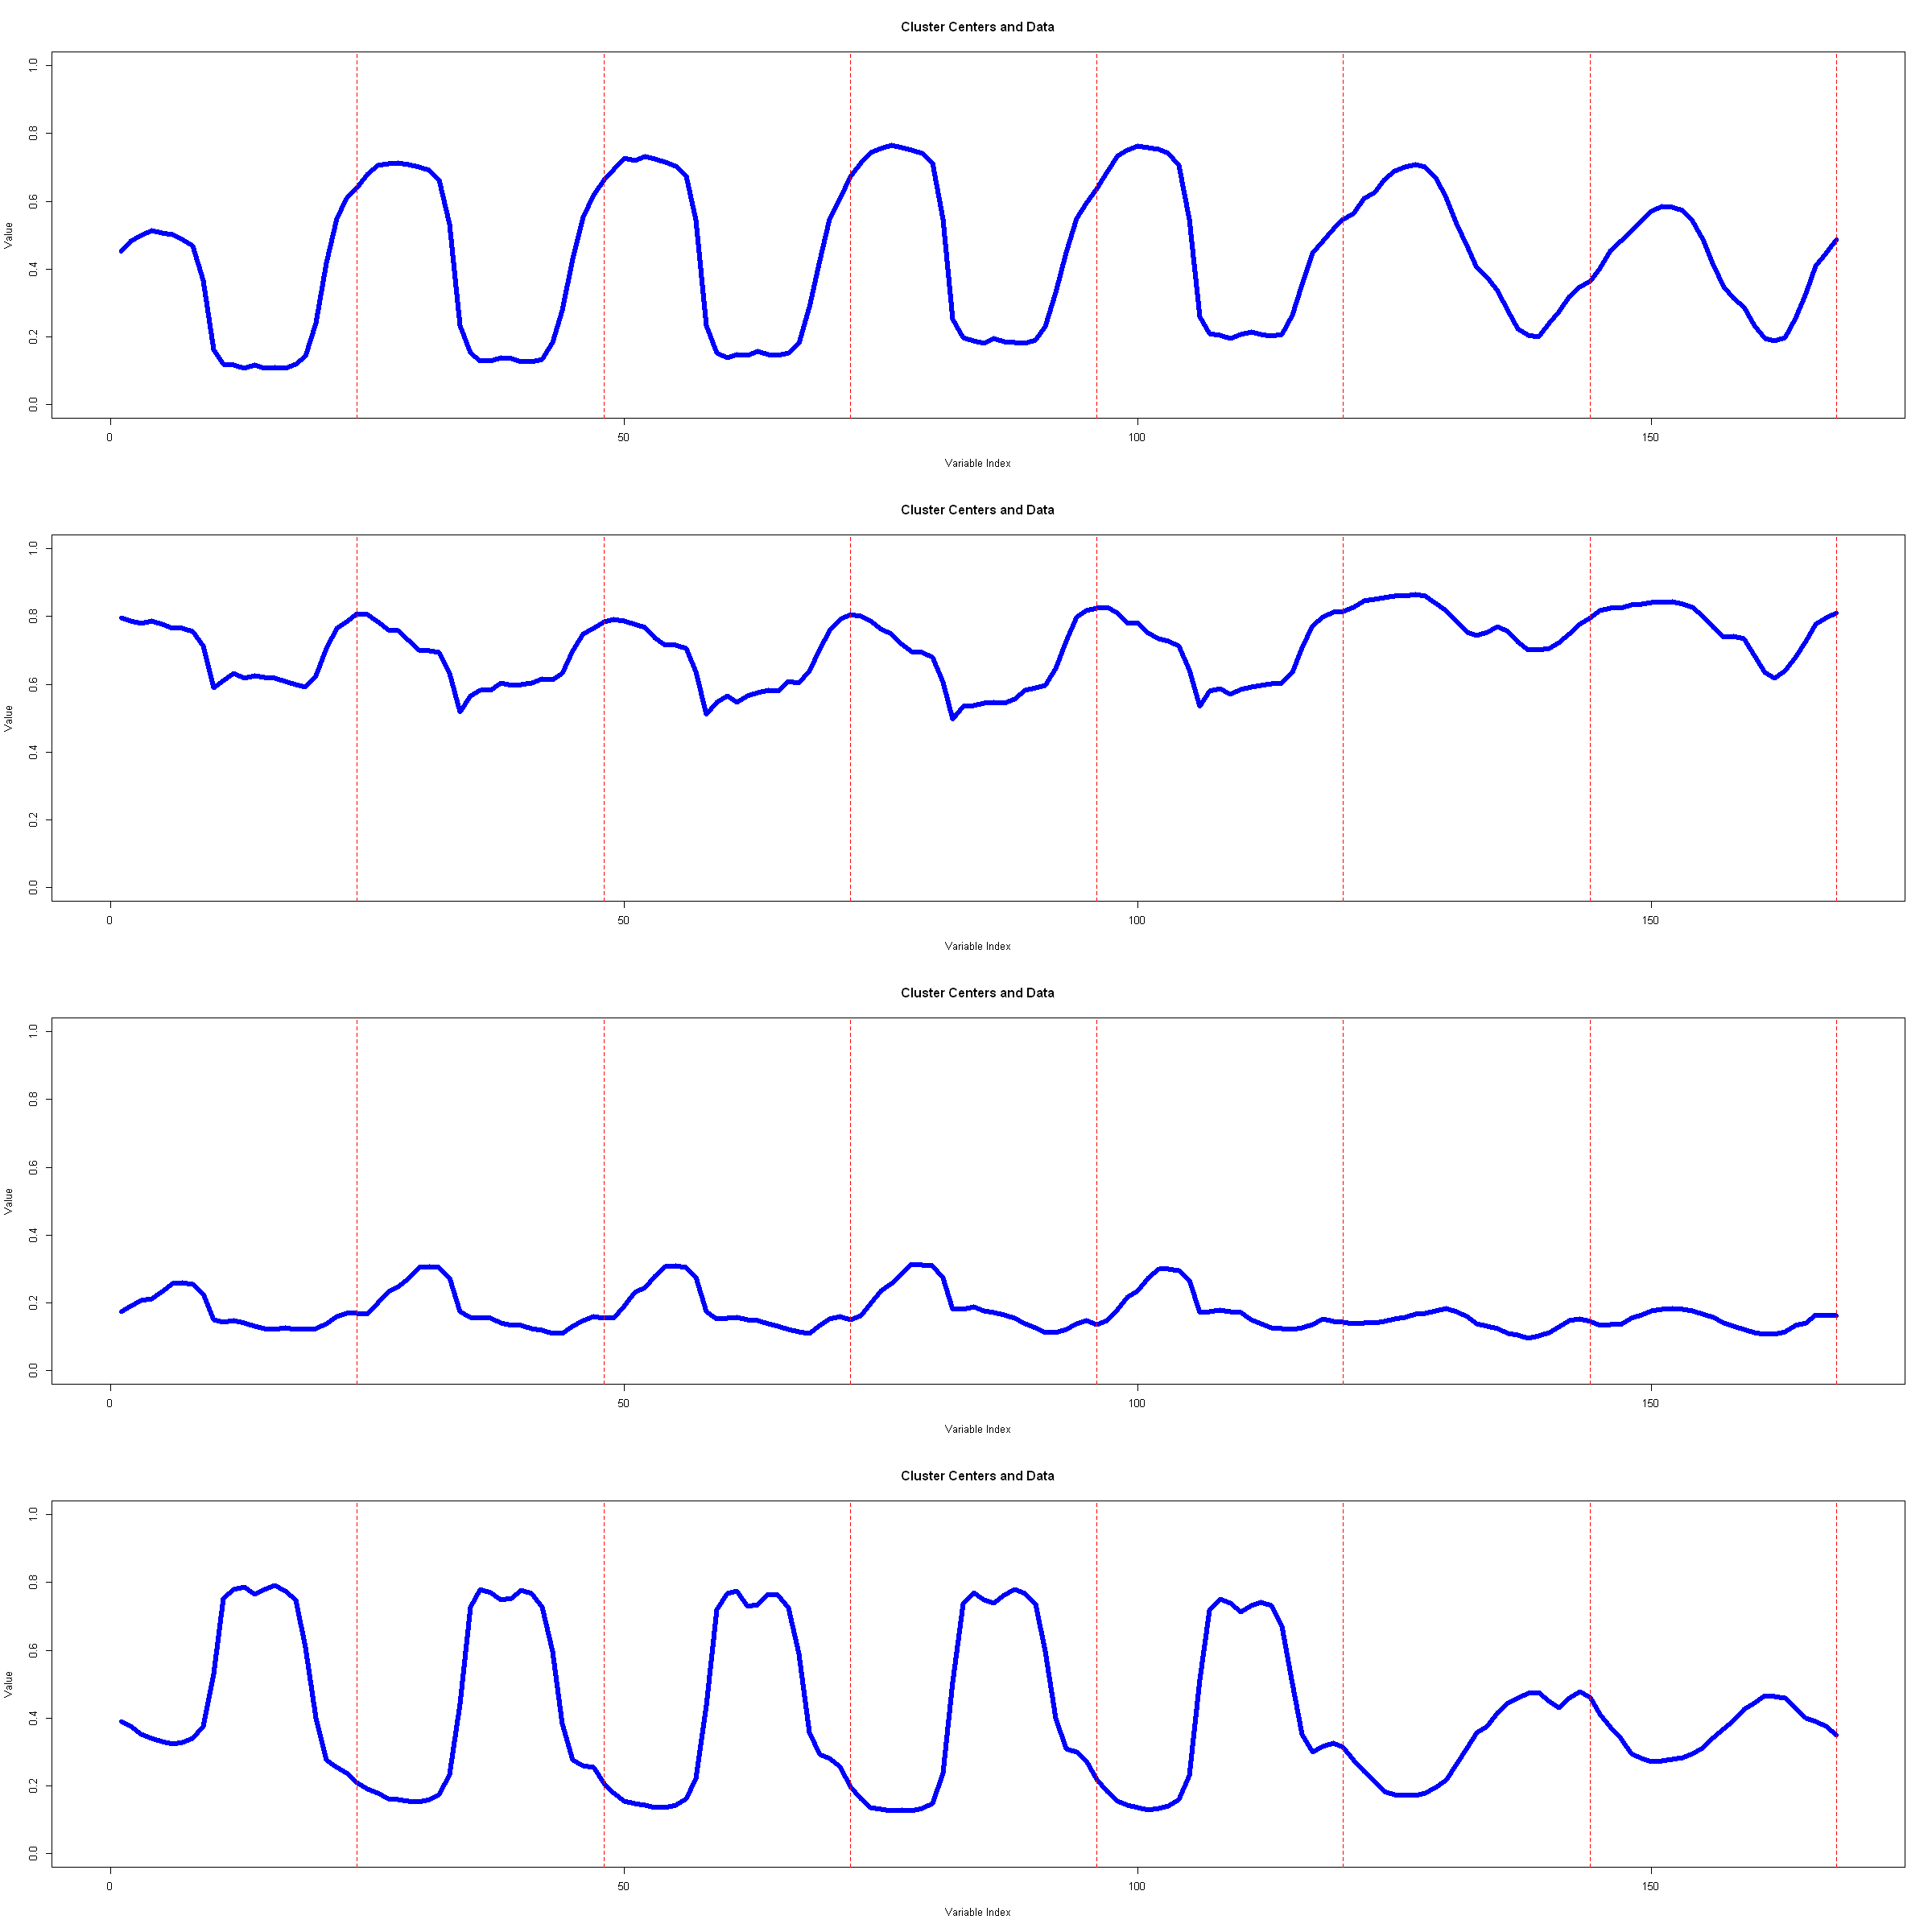

In [24]:
data_reduced_1 <- data


data_reduced_1$cluster <- reskmeans_reduced$cluster
data_reduced_1$cluster <- factor(data_reduced_1$cluster,levels = c("1", "2","3","4"))
options(repr.plot.width = 21, repr.plot.height = 7)

my_palette <- c("yellow", "#00BFC4")
grid.arrange(
    fviz_cluster(reskmeans_reduced, data=data_scale[,-c(1,2,3,4)], ellipse.type="norm", labelsize=8, geom=c("point"))+geom_hline(yintercept = 0, linetype = "dashed", color = "black") +geom_vline(xintercept = 0, linetype = "dashed", color = "black"),
    fviz_pca_ind(pca, axes=c(1,2), geom=c("point"), habillage=data_reduced_1$bonus, palette = my_palette),
    ncol=2
)
table_data <- table(bonus = data_reduced_1$bonus, cluster = data_reduced_1$cluster)
table_data
rate=table_data[2,3]/sum(table_data[2,])*100
print(sprintf("%.1f%% des stations sont situées sur la colline dans le cluster 3 du regroupement k-means.", rate))
options(repr.plot.width = 20, repr.plot.height = 20)
par(mfrow = c(4,1))

for (i in 1:nrow(reskmeans$centers)) {

  plot(reskmeans$centers[i,], type = 'l', ylim = c(0, 1), col = "blue", lwd = 5, main = "Cluster Centers and Data", xlab = "Variable Index", ylab = "Value")
  abline(v = seq(24, 168, by = 24), col = "red", lty = 2)
  
}

Comme vous pouvez le constater, les résultats du clustering sont extrêmement similaires. Par conséquent, au lieu d’analyser sur l’ensemble de données d’origine, nous pouvons l’effectuer sur des données de dimension réduite pour passer moins de temps sans trop modifier les résultats.

## Clustering avec HAC

### Sur les donné original:

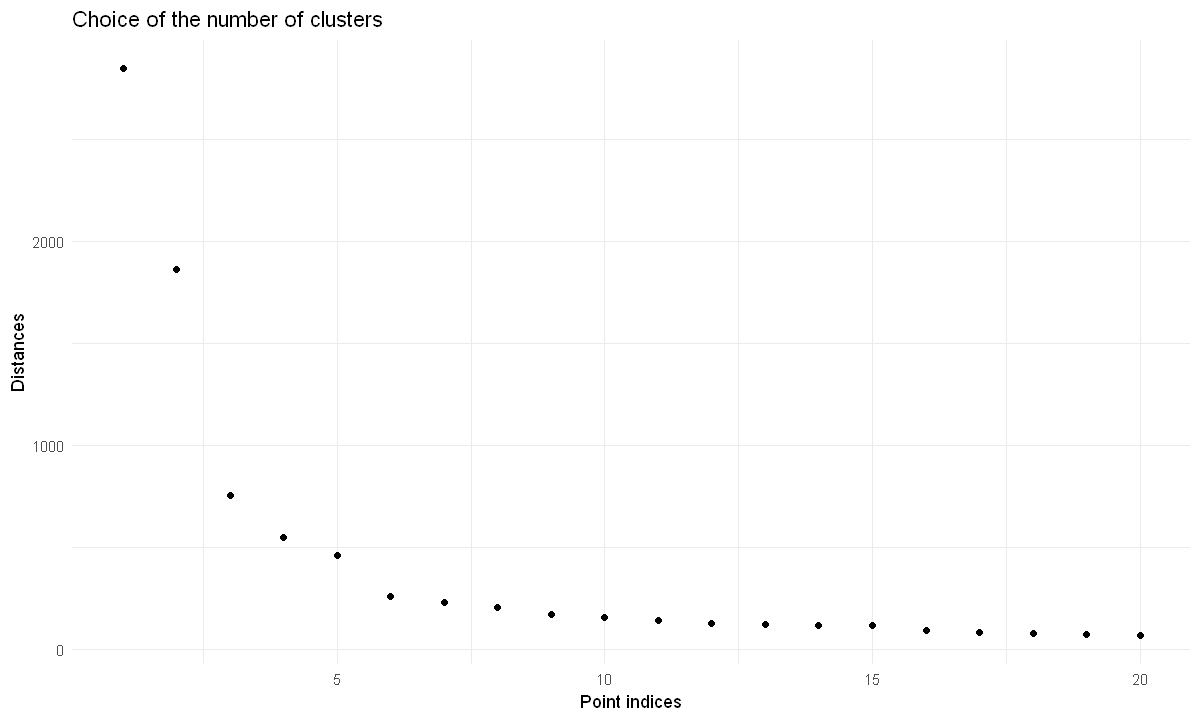

In [52]:
hc <- hclust(dist(data_scale[,-c(1,2,3,4)]), method = "ward.D")

n_sizes <- 20
x <- seq_len(n_sizes)
y <- rev(hc$height)[1:n_sizes]  
options(repr.plot.width = 10, repr.plot.height = 6)

ggplot(data.frame(x, y), aes(x, y)) +
    geom_point() +
    labs(title = "Choice of the number of clusters",
         x = "Point indices",
         y = "Distances") +
    theme_minimal()

L'examen du nombre de clusters montre qu'il y a un saut important dans la distance entre les clusters lorsqu'on passe de 6 à 5 clusters. Ensuite, à partir de 6 clusters, la variation de la distance entre les clusters devient plus lente. Par conséquent, choisir 6 clusters est une décision raisonnable.

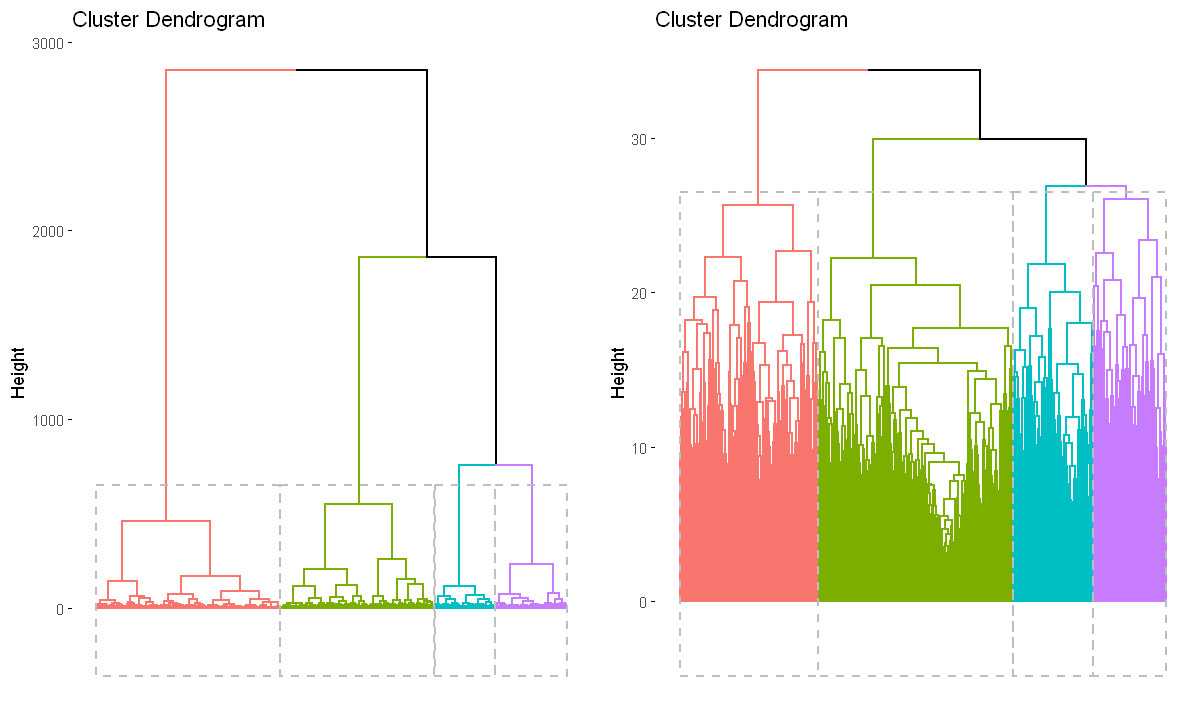

In [54]:
d = dist(data_scale[,-c(1,2,3,4)], method="euclidean")
hclustcomplete = hclust(d, method="complete")
reshclust = cutree(hclustcomplete, 4)


hclust_ward = hclust(d, method = "ward.D")
res_hclust_ward = cutree(hclust_ward, 4)

# --- #
grid.arrange(
    fviz_dend(hclust_ward, k=4, show_labels=FALSE, rect=TRUE),
    fviz_dend(hclustcomplete, k=4, show_labels=FALSE, rect=TRUE),
    
    ncol=2
)

On effectue un clustering hiérarchique avec la méthode ward linkage et complete linkage sur les données avec 4 clusters. L'objectif est de comparer avec le clustering par k-means. Ensuite, on tracez le dendrogramme.

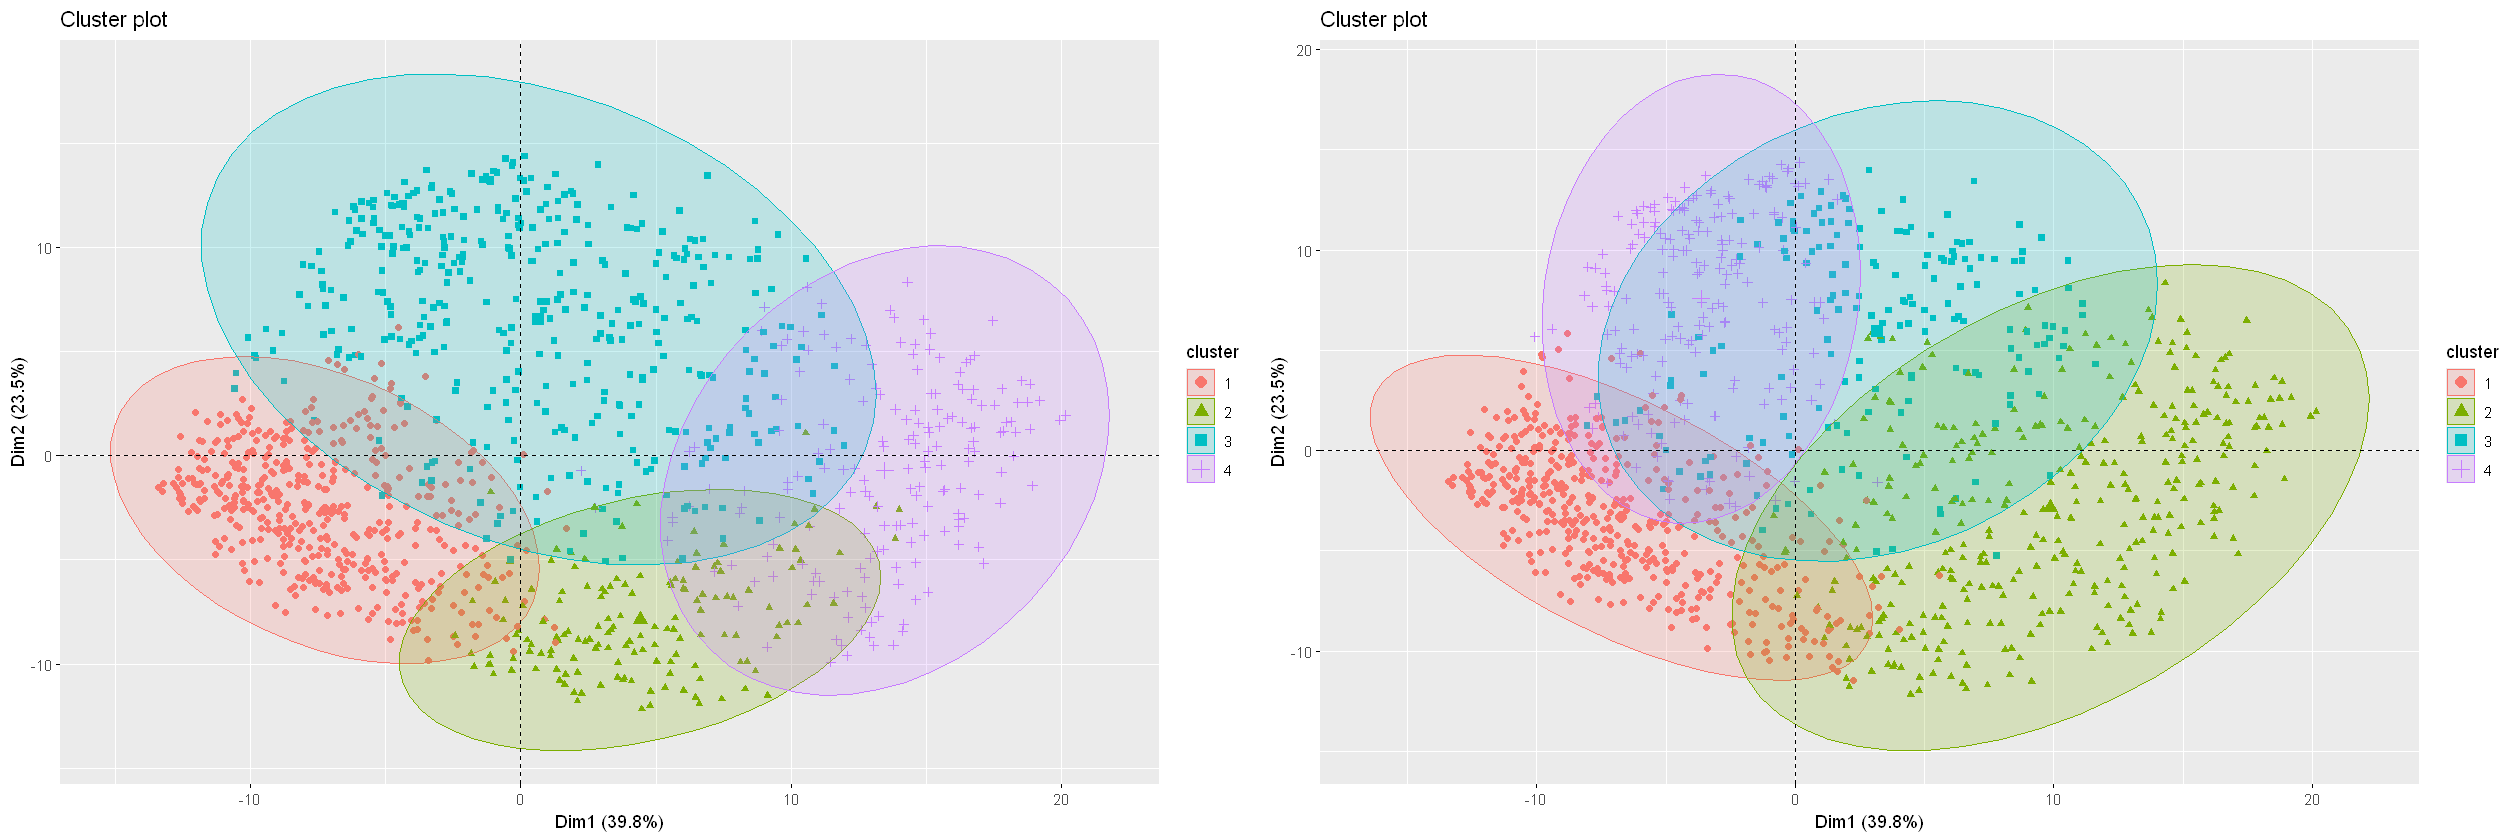

In [55]:
data_2 <- data


data_2$cluster <- res_hclust_ward
data_2$cluster <- factor(data_2$cluster,levels = c("1", "2","3","4"))
options(repr.plot.width = 21, repr.plot.height = 7)

my_palette <- c("yellow", "#00BFC4")
grid.arrange(
    fviz_cluster(list(data = data[,-c(1,2,3,4)], cluster = res_hclust_ward), ellipse.type = "norm", labelsize = 8, geom = c("point")) +
    geom_hline(yintercept = 0, linetype = "dashed", color = "black") +
    geom_vline(xintercept = 0, linetype = "dashed", color = "black"),
    fviz_cluster(list(data = data[,-c(1,2,3,4)], cluster = reshclust), ellipse.type = "norm", labelsize = 8, geom = c("point")) +
    geom_hline(yintercept = 0, linetype = "dashed", color = "black") +
    geom_vline(xintercept = 0, linetype = "dashed", color = "black"),
    ncol=2
)

Nous traçons à nouveau deux graphiques, respectivement, sont des graphes de clustering utilisant la méthode ward linkage  et de clustering utilisant la méthode complete linkage. Ici, la méthode ward linkage   est meilleure car il y a moins de chevauchement entre les clusters. Désormais, nous utiliserons la méthode ward linkage pour l’analyse.

     cluster
bonus   1   2   3   4
    0 346 150 385 181
    1 120   2   4   1

[1] "94.5% des stations sont situées sur la colline dans le cluster 1 du regroupement cah- ward."


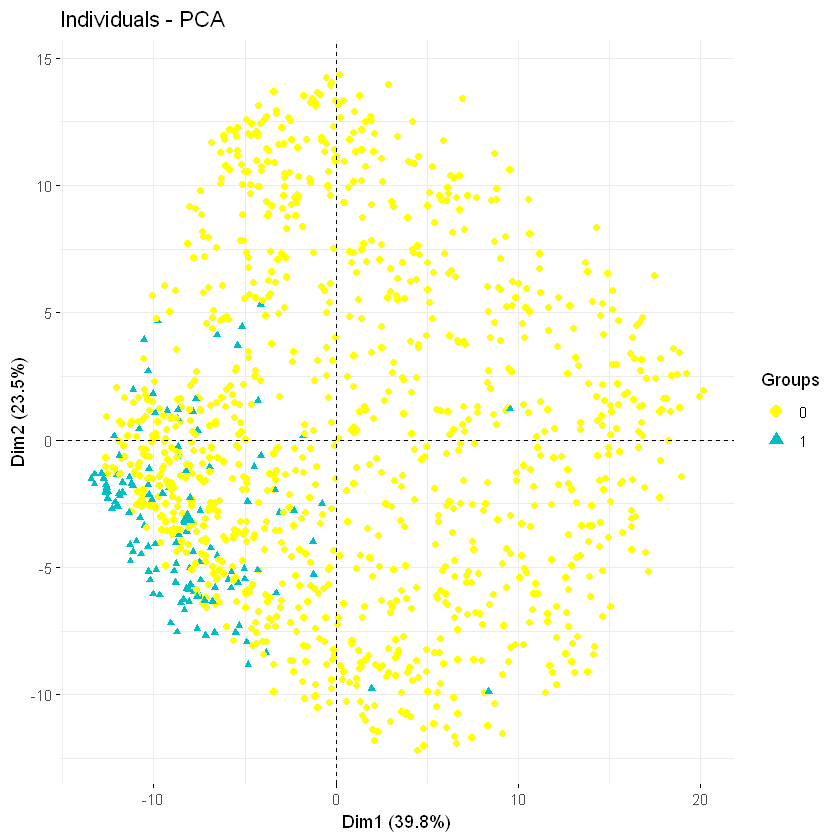

In [56]:
options(repr.plot.width = 7, repr.plot.height = 7)
fviz_pca_ind(pca, axes=c(1,2), geom=c("point"), habillage=data_2$bonus, palette = my_palette)
table_data <- table(bonus = data_2$bonus, cluster = data_2$cluster)
table_data
rate=table_data[2,1]/sum(table_data[2,])*100
print(sprintf("%.1f%% des stations sont situées sur la colline dans le cluster 1 du regroupement cah- ward.", rate))

Comme on peut le voir sur l'image, la plupart des points avec un bonus égal à 1 se trouvent dans le cluster 1.

No id variables; using all as measure variables

No id variables; using all as measure variables

No id variables; using all as measure variables

No id variables; using all as measure variables



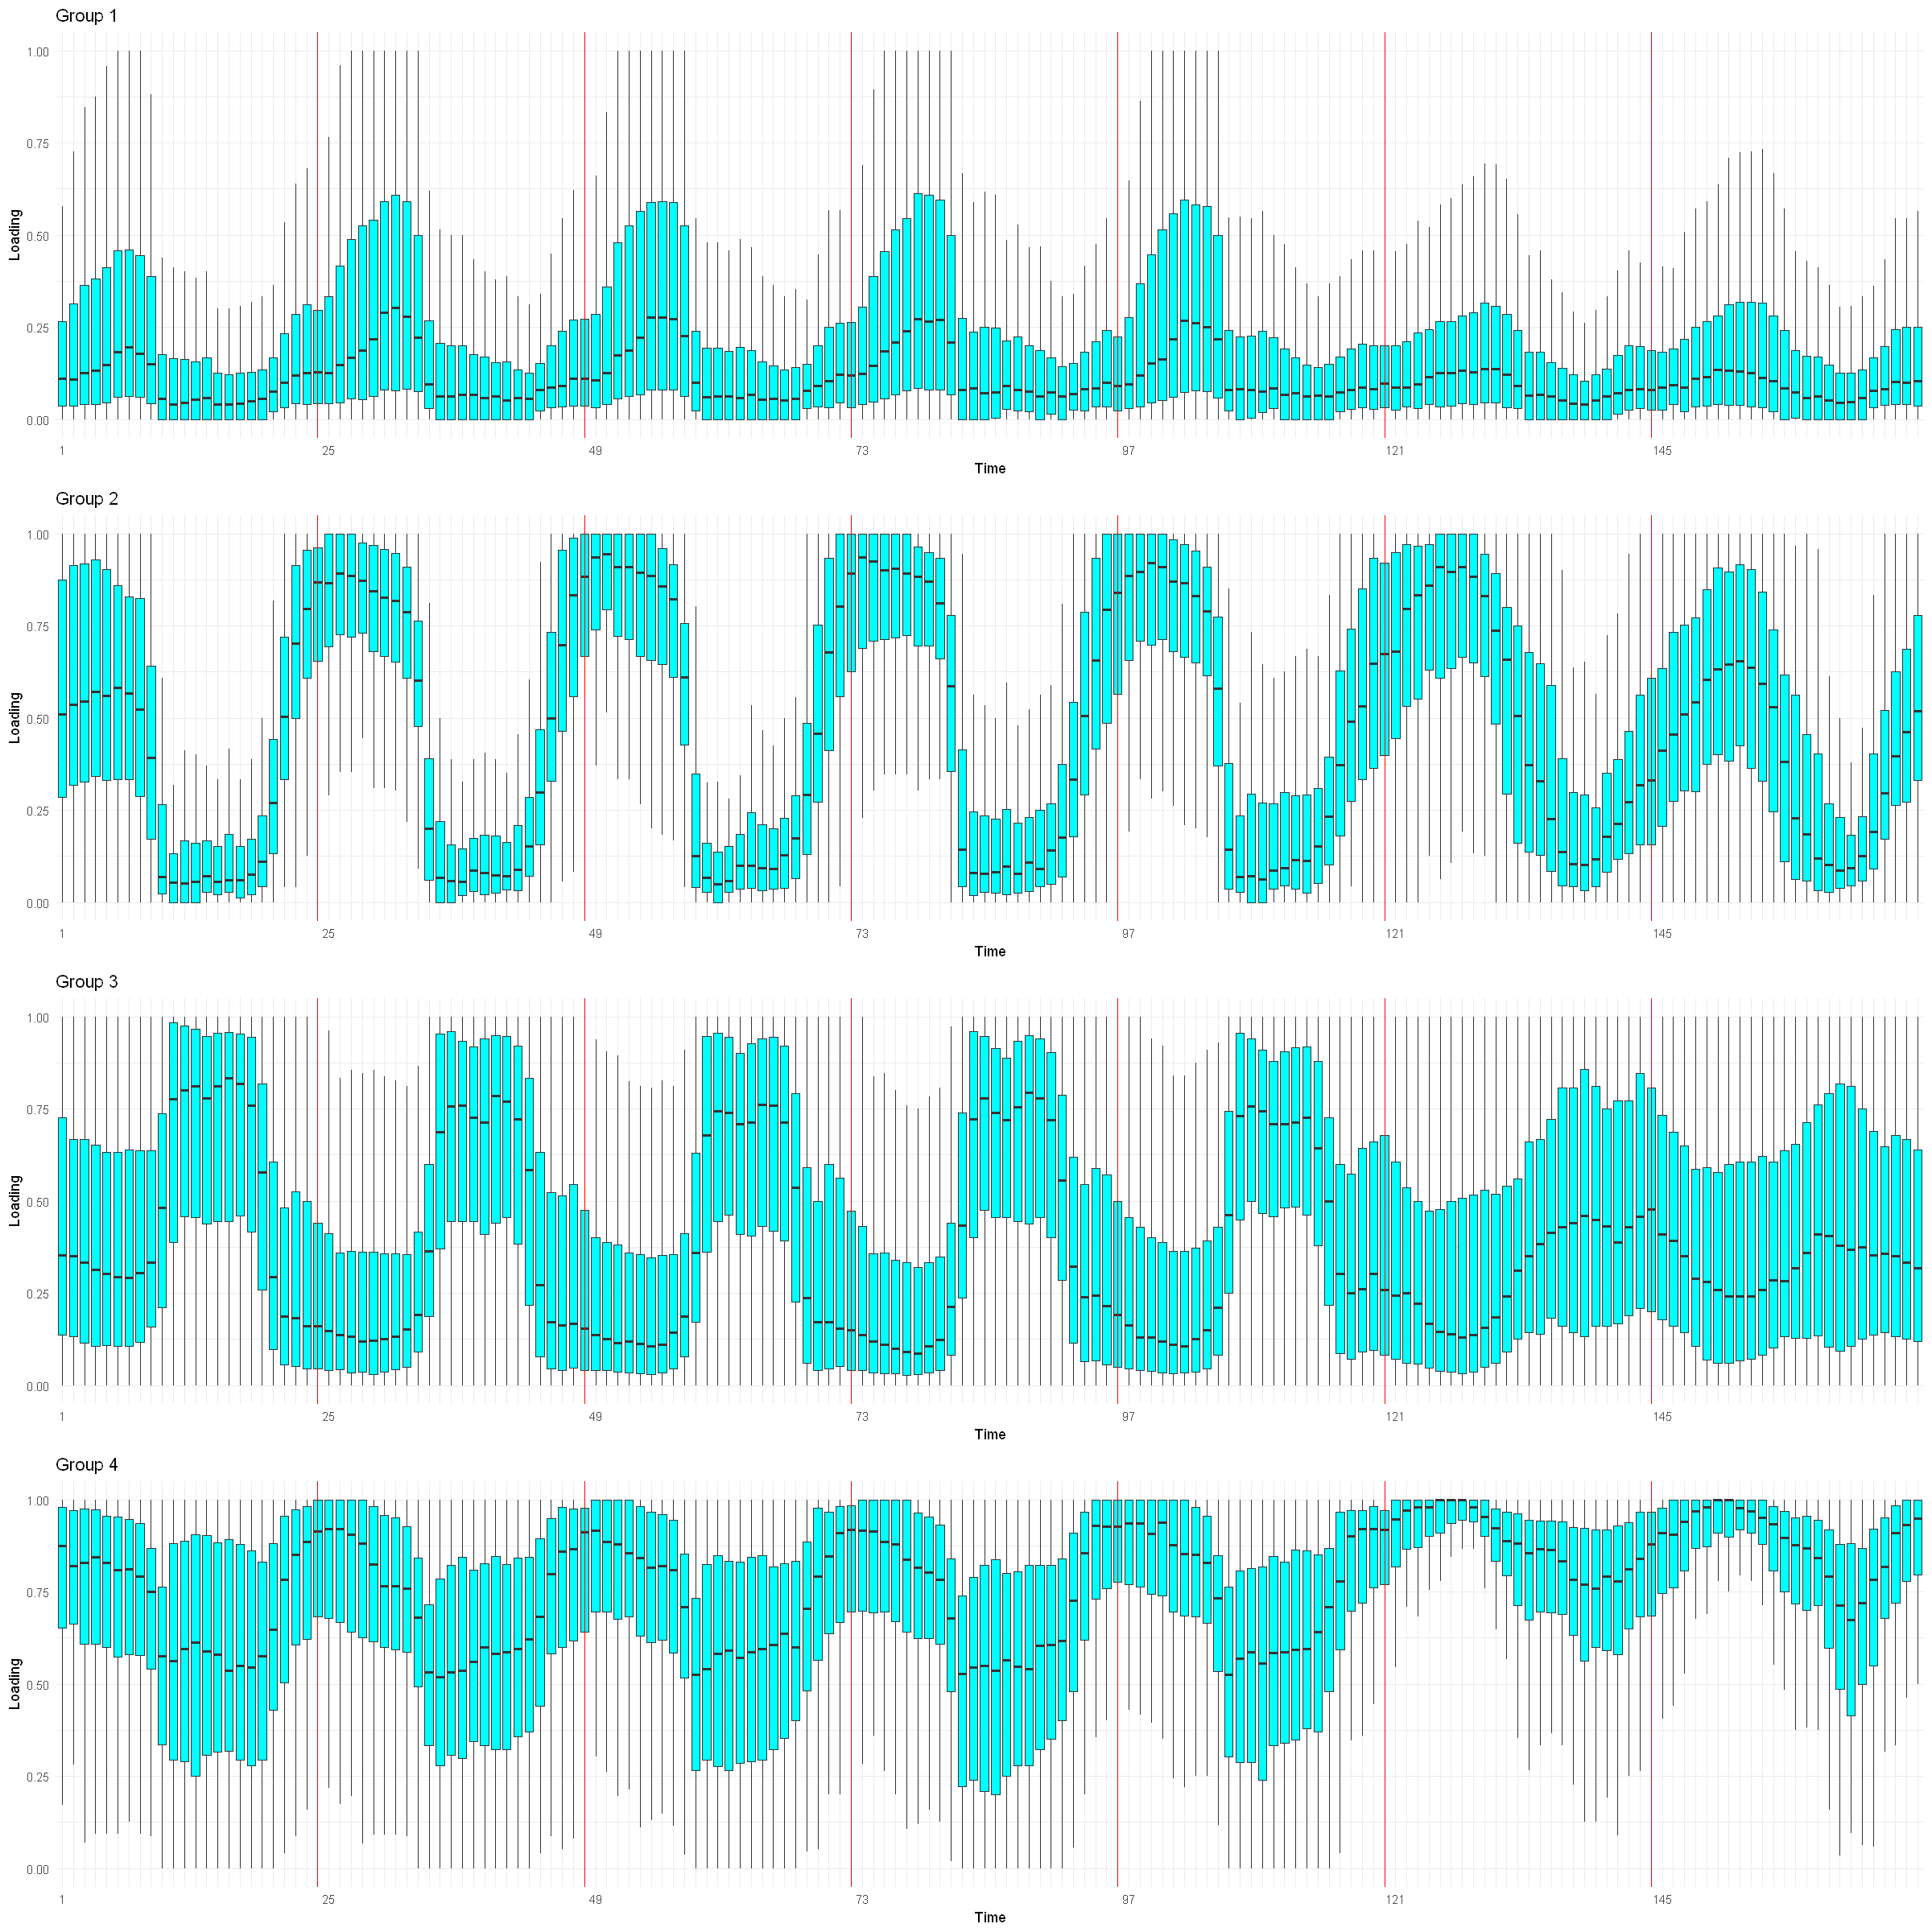

In [57]:
options(repr.plot.width = 20, repr.plot.height = 20)
plots <- list()

for (i in 1:4){
  cluster_indices <- which(res_hclust_ward == i)
  cluster_data <- data[cluster_indices, -c(1, 2, 3, 4)]
  df <- melt(cluster_data)

  labels <- as.character(1:ncol(loading))
  labels[-c(1, 25, 49, 73, 97, 121, 145)] <- ""  

#  mean_data <- aggregate(value ~ variable, data = df, FUN = mean)

  plots[[i]] <- ggplot(df, aes(x = variable, y = value)) +
    geom_boxplot(fill = "cyan", outlier.shape = NA) +
#    geom_jitter(width = 0.001, alpha = 0.5) +  

#    geom_line(data = mean_data, aes(group = 1), color = "blue", size = 2) +

    geom_vline(xintercept = c(24, 48, 72, 96, 120, 144), color = "red", linetype = "solid") +
    scale_x_discrete(labels = labels) +  
    labs(x = "Time", y = "Loading") +  
    theme_minimal() +
    ggtitle(paste("Group", i))
}

grid.arrange(grobs = plots, ncol = 1)

- Ici, nous dessinons le diagramme en boîte à moustaches des clusters. Les clusters avec des caractéristiques clairement différentes ressemblent au clustering K-means.
- On peut voir que les clusters 2 et 3 représentent les groupes de stations avec une variation élevée au cours de la journée. Dans le cluster 2, les "loading" sont élevés la nuit et bas le jour, tandis que dans le cluster 3, c'est l'inverse.
- Les clusters 1 et 4 représentent les groupes de stations avec une variation faible au cours de la journée. Dans le cluster 4, les "loading" sont élevés à la fois le jour et la nuit. Dans le cluster 1, les "loading" sont bas tout au long de la journée.
- Il y a une différence entre le samedi, le dimanche et les jours de la semaine. Les variations de "loading" sont moindres durant les deux jours du week-end par rapport aux autres jours.

   Kmean
CAH   1   2   3   4
  1  52   0 411   3
  2 138  13   1   0
  3  36  51  29 273
  4  12 170   0   0

[1] "83.4% de similarité avec le clustering k-means."


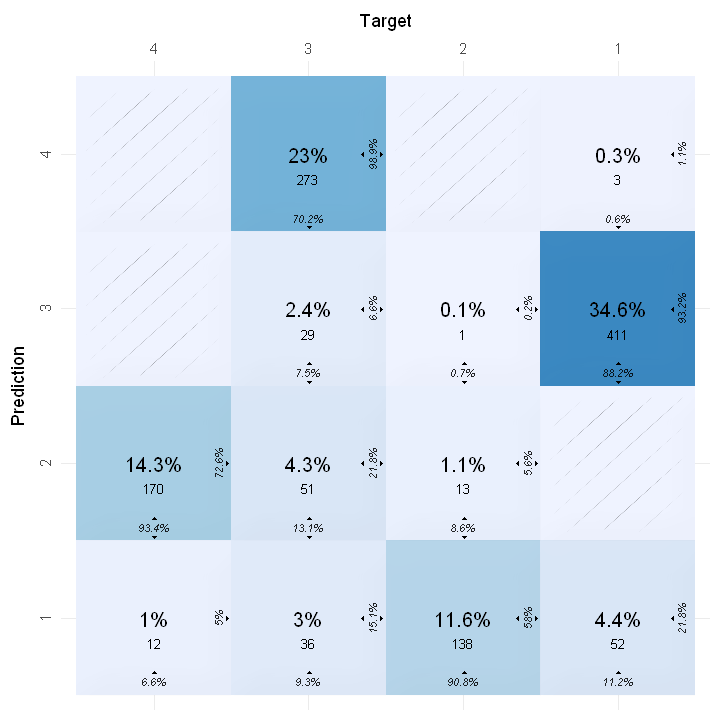

In [59]:
options(repr.plot.width = 6, repr.plot.height = 6)
table=table('CAH'=res_hclust_ward, 'Kmean'=reskmeans$cluster)
table
# --- #
rate=sum(table[1, 3]+table[2, 1]+table[3, 4]+table[4, 2])/sum(table)*100
print(sprintf("%.1f%% de similarité avec le clustering k-means.", rate))
# With the confusion matrix
conf_mat = confusion_matrix(targets=res_hclust_ward, predictions=reskmeans$cluster )
plot_confusion_matrix(conf_mat)

Ici, nous pouvons voir que les paires de clusters similaires entre les k-means et le clustering Cah sont respectivement 1-2, 2-4, 3-1 et 4-3. Avec plus de 80 % de similarité, le clustering k-means et le clustering cah utilisant la méthode Ward linkage sont assez similaires. Cela a été clairement visible lorsque nous avons analysé les diagrammes en boîte à moustaches des clusters ci-dessus.

### Sur les donné de dimension réduite:

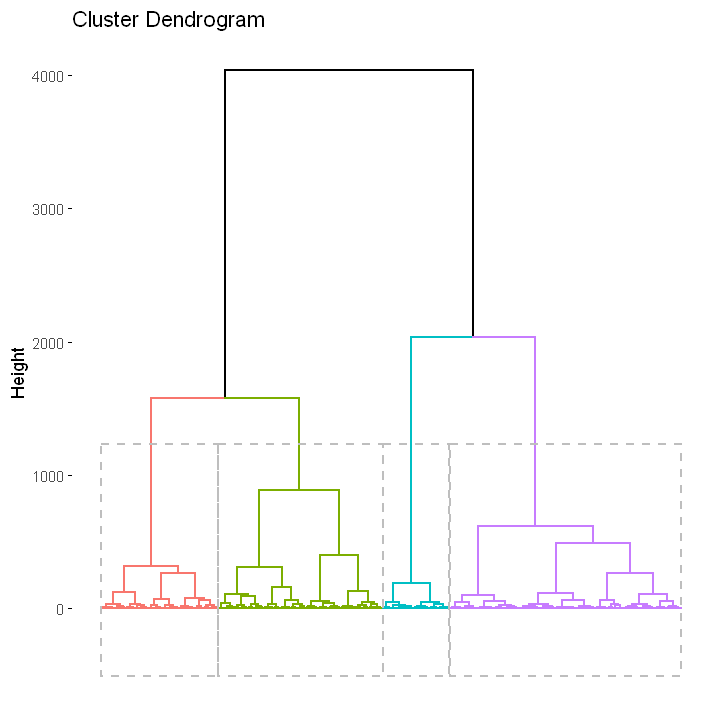

In [60]:
d_reduced = dist(pca$ind$coord[,1:2], method="euclidean")
hclustcomplete_reduced = hclust(d_reduced, method="ward.D")
reshclust_reduced = cutree(hclustcomplete_reduced, 4)

fviz_dend(hclustcomplete_reduced, k=4, show_labels=FALSE, rect=TRUE)

Ici, nous effectuons un clustering sur des données réduites en dimension en utilisant HAC (méthode Ward) (4 clusters).

       original
reduced   1   2   3   4
      1 380   0  20  75
      2  95 112  24   9
      3   0 227  92  18
      4   0   0  42  95

[1] "27.4% de similarité avec le clustering sur les données originales."


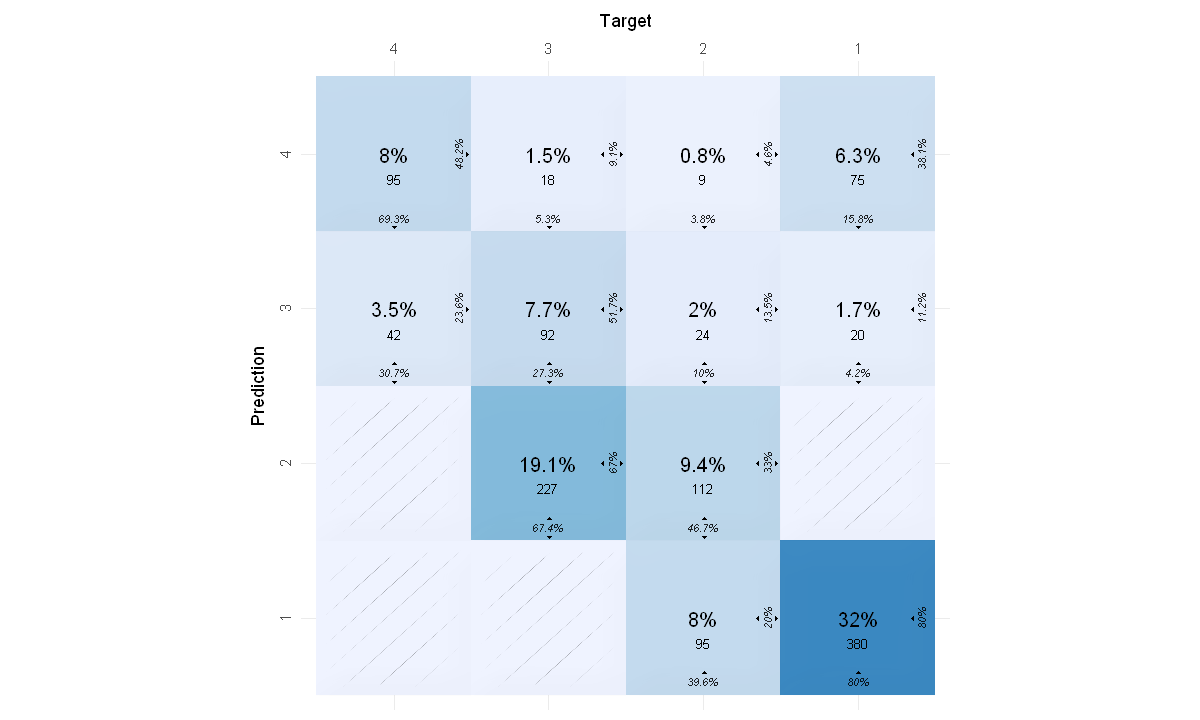

In [61]:
table=table('reduced'=reshclust_reduced, 'original'=reshclust)
options(repr.plot.width = 10, repr.plot.height = 6)
conf_mat = confusion_matrix(targets=reshclust_reduced, predictions=reshclust )
plot_confusion_matrix(conf_mat)
table
rate=sum(diag(table[, 4:1]))/sum(table)*100

Ici, je compare le cluster dans les données originales avec le cluster  dans les données réduites en dimension. D'après la matrice de confusion, nous constatons que le clustering HAC sur les données non réduites en dimension est assez différent par rapport aux données originales. Par conséquent, l’application de la PCA au clustering HAC peut ne pas être efficace.

     cluster
bonus   1   2   3   4
    0 357 233 335 137
    1 118   7   2   0

[1] "92.9% des stations sont situées sur la colline dans le cluster 1 du regroupement k-means."


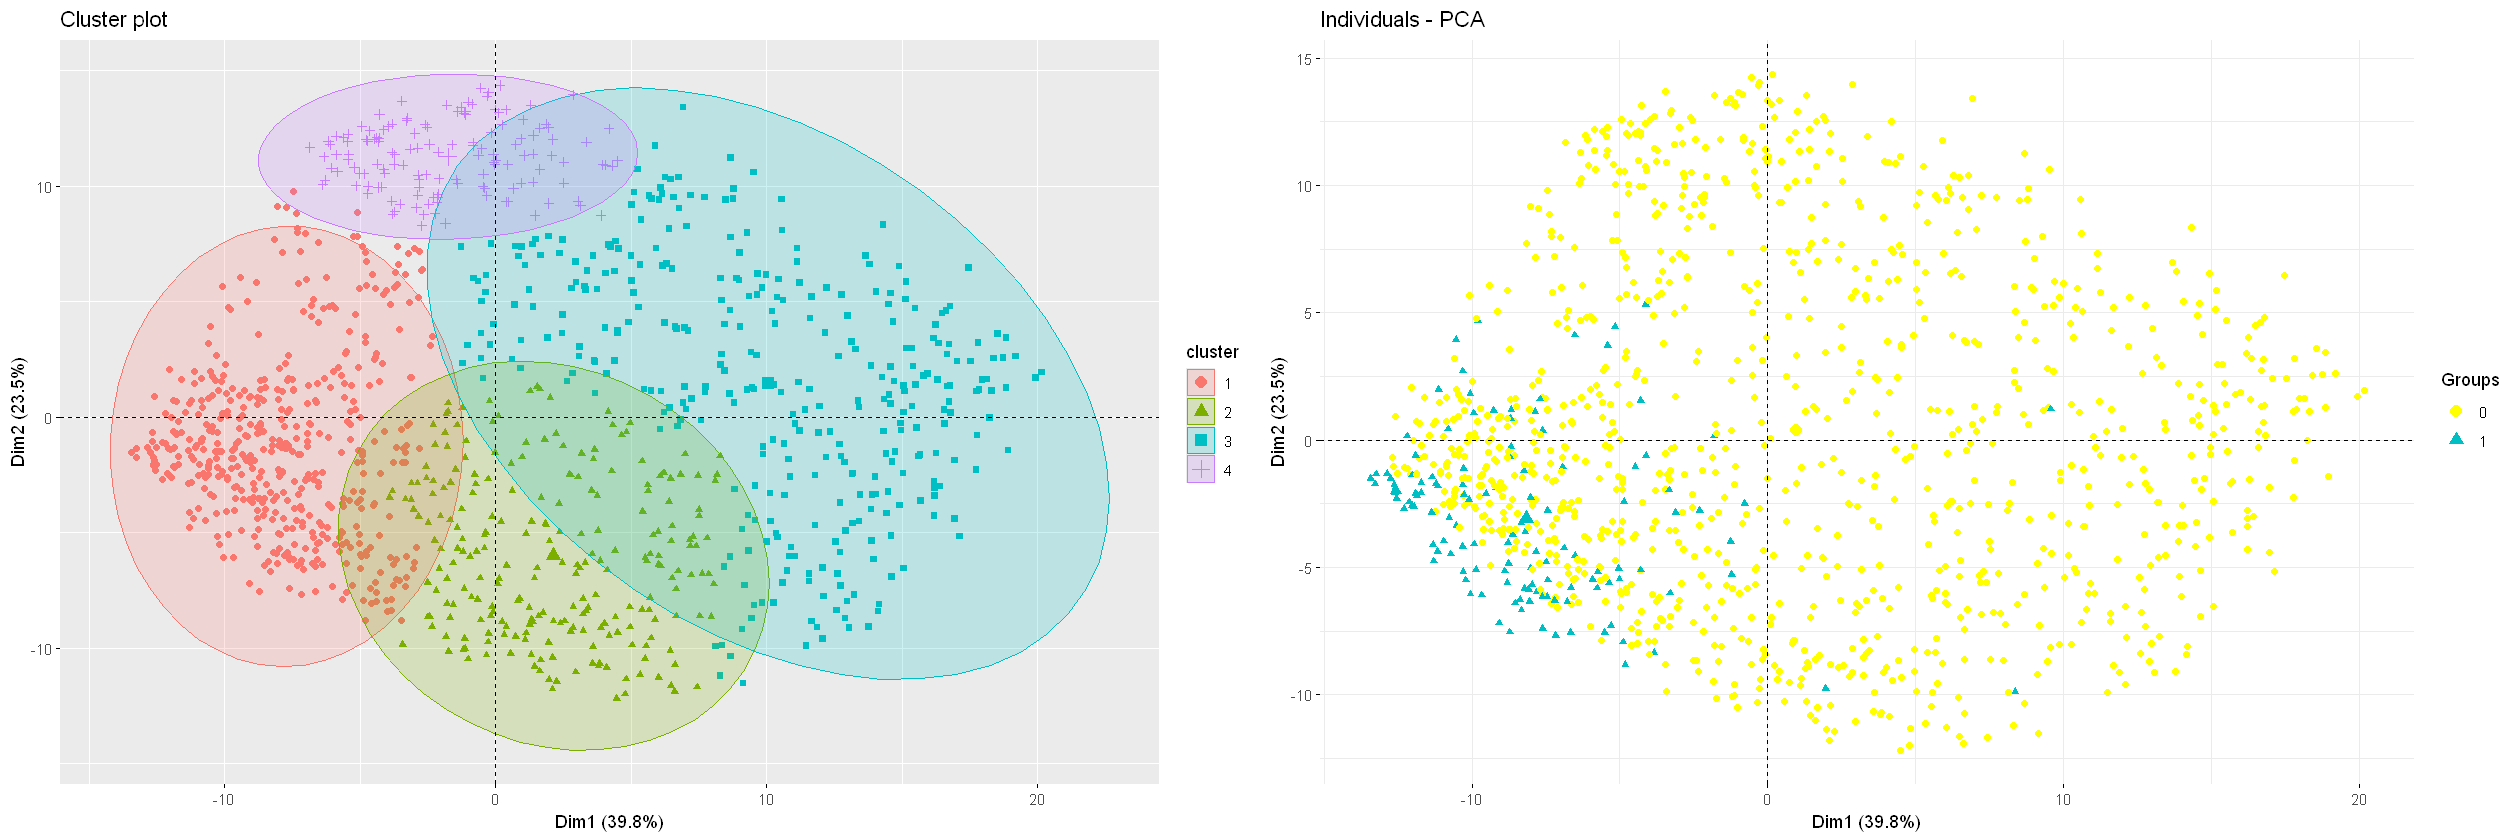

In [64]:
data_reduced_2 <- data


data_reduced_2$cluster <- reshclust_reduced
data_reduced_2$cluster <- factor(data_reduced_2$cluster,levels = c("1", "2","3","4"))
options(repr.plot.width = 21, repr.plot.height = 7)

my_palette <- c("yellow", "#00BFC4")
grid.arrange(
    fviz_cluster(list(data = data_scale[,-c(1,2,3,4)], cluster = reshclust_reduced), ellipse.type = "norm", labelsize = 8, geom = c("point")) +
    geom_hline(yintercept = 0, linetype = "dashed", color = "black") +
    geom_vline(xintercept = 0, linetype = "dashed", color = "black"),
    fviz_pca_ind(pca, axes=c(1,2), geom=c("point"), habillage=data_reduced_2$bonus, palette = my_palette),
    ncol=2
)
table_data <- table(bonus = data_reduced_2$bonus, cluster = data_reduced_2$cluster)
table_data
rate=table_data[2,1]/sum(table_data[2,])*100
print(sprintf("%.1f%% des stations sont situées sur la colline dans le cluster 1 du regroupement k-means.", rate))

Comme on peut le voir sur l'image, la plupart des points avec un bonus égal à 1 se trouvent dans le cluster 1.

No id variables; using all as measure variables

No id variables; using all as measure variables

No id variables; using all as measure variables

No id variables; using all as measure variables



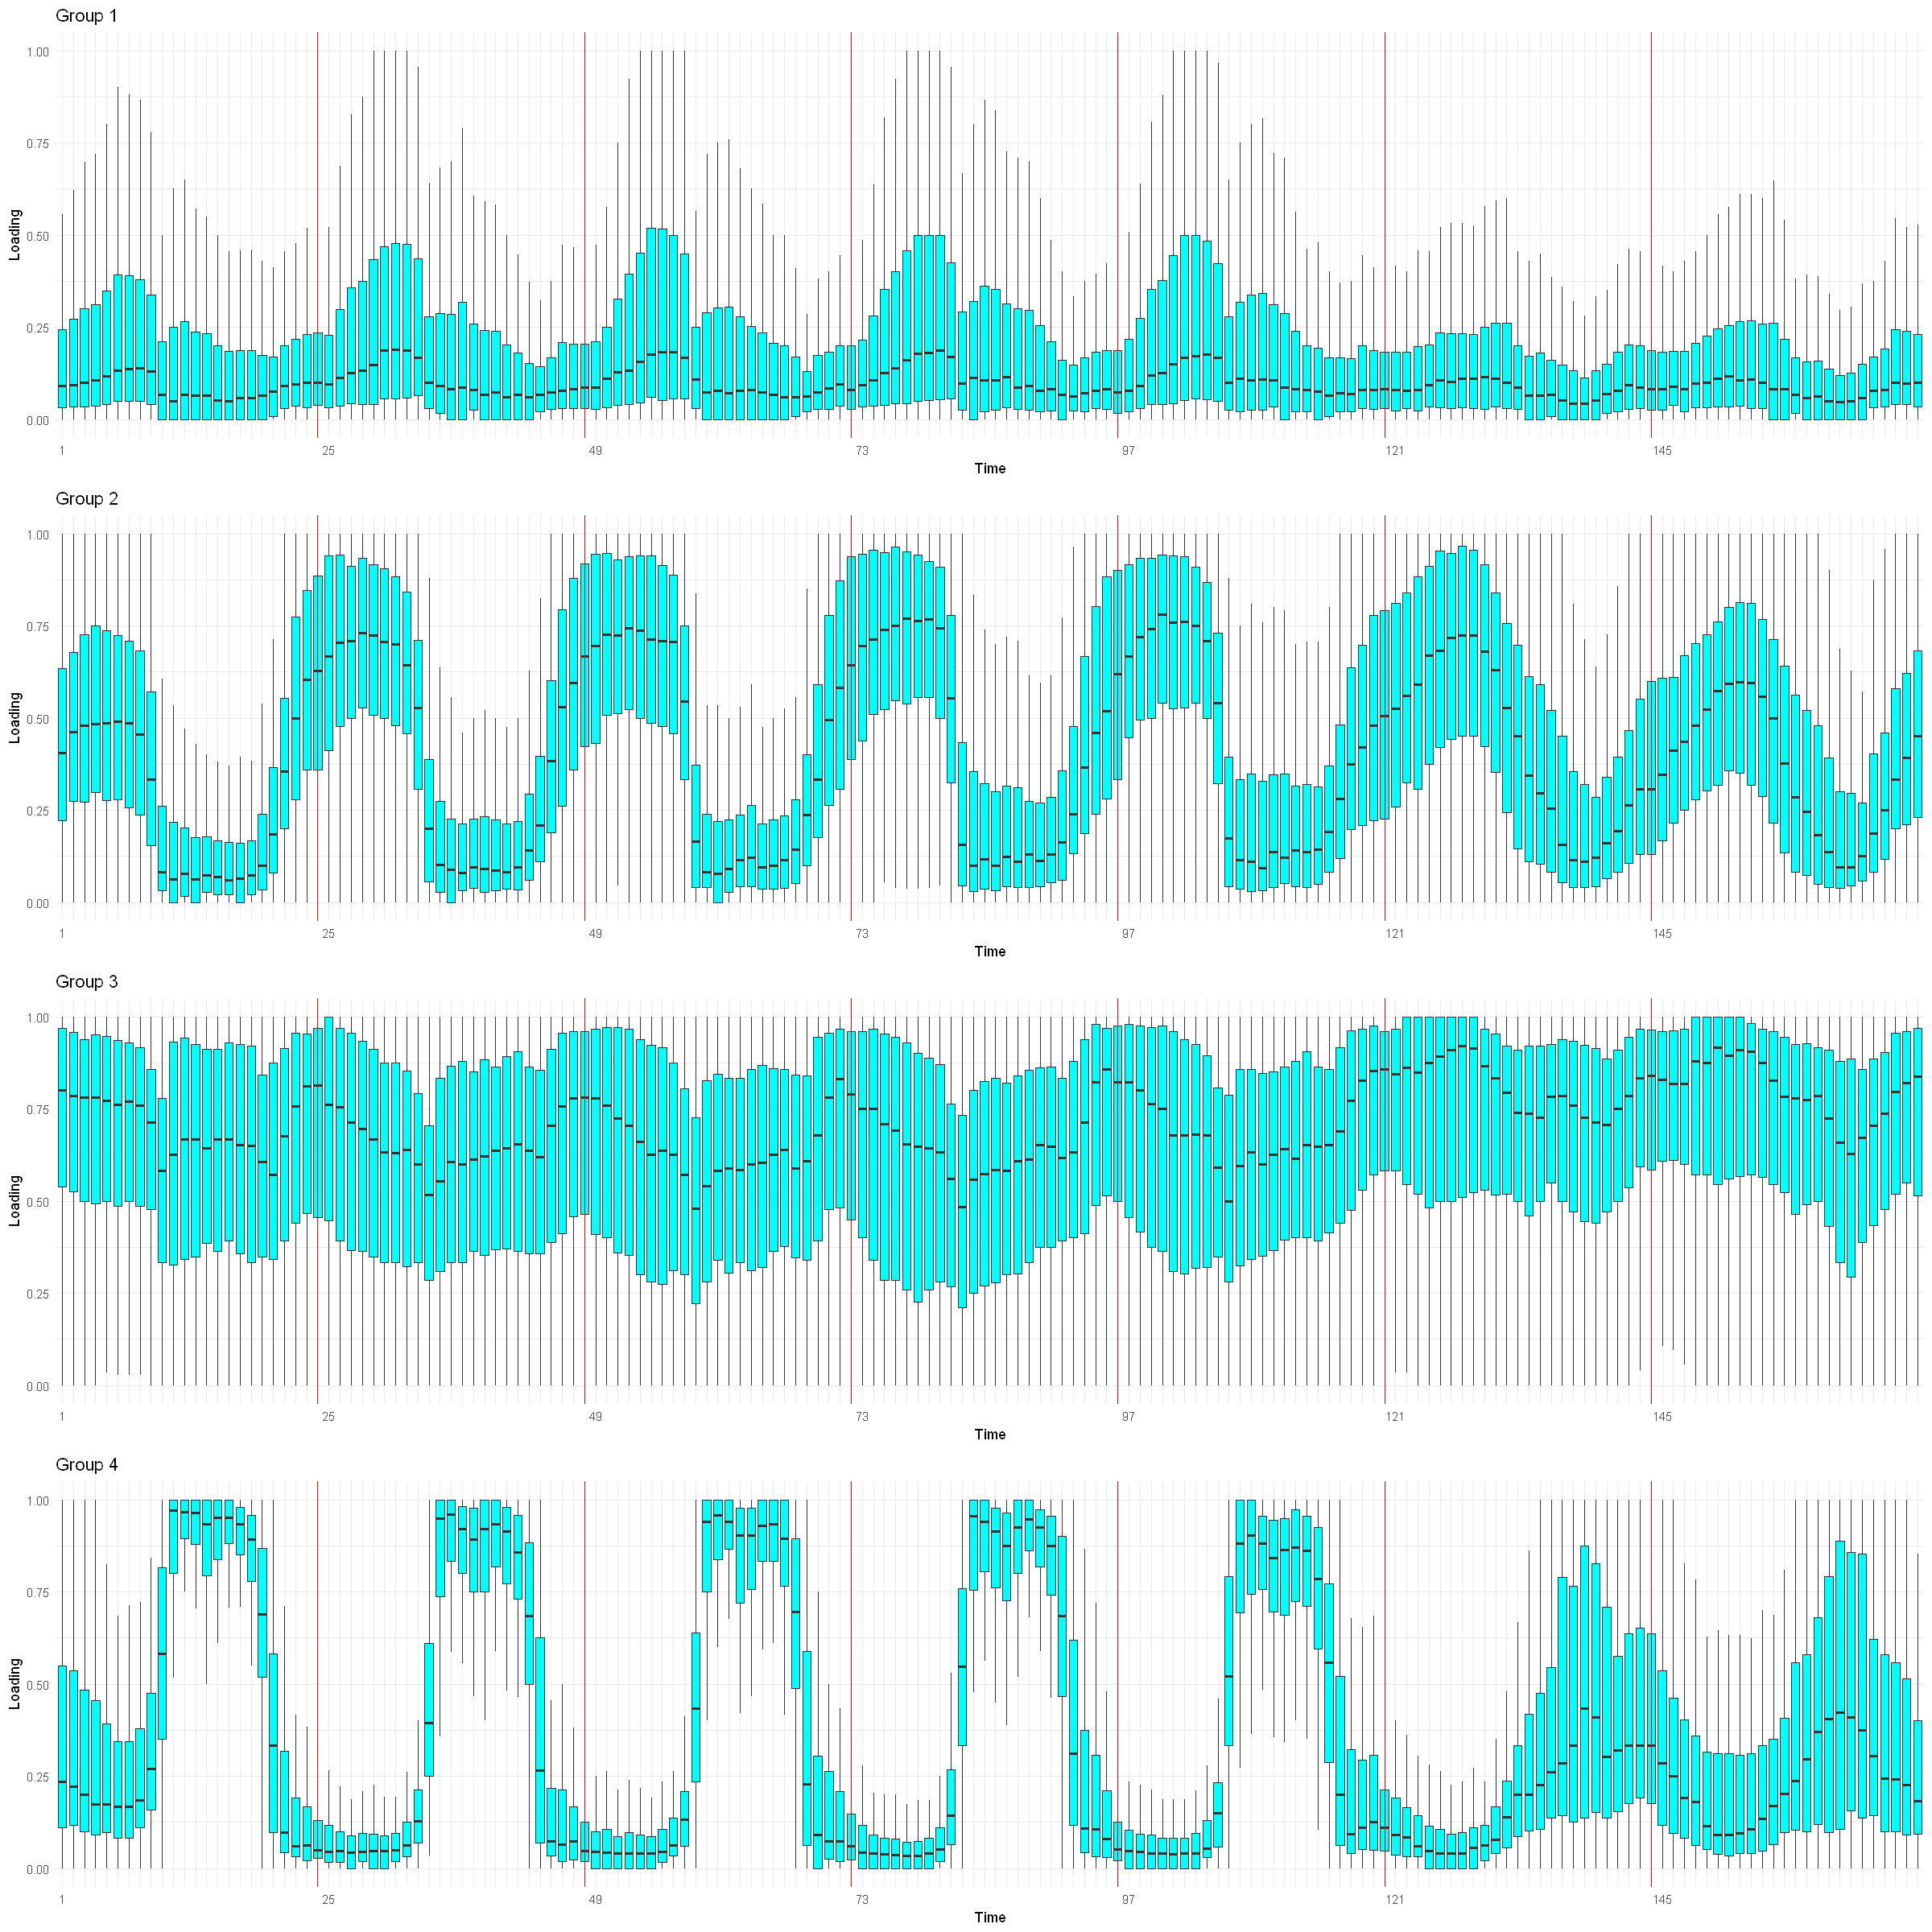

In [65]:
options(repr.plot.width = 20, repr.plot.height = 20)
plots <- list()

for (i in 1:4){
  cluster_indices <- which(reshclust_reduced == i)
  cluster_data <- data[cluster_indices, -c(1, 2, 3, 4)]
  df <- melt(cluster_data)

  labels <- as.character(1:ncol(loading))
  labels[-c(1, 25, 49, 73, 97, 121, 145)] <- ""  

#  mean_data <- aggregate(value ~ variable, data = df, FUN = mean)

  plots[[i]] <- ggplot(df, aes(x = variable, y = value)) +
    geom_boxplot(fill = "cyan", outlier.shape = NA) +
#    geom_jitter(width = 0.001, alpha = 0.5) +  

#    geom_line(data = mean_data, aes(group = 1), color = "blue", size = 2) +

    geom_vline(xintercept = c(24, 48, 72, 96, 120, 144), color = "red", linetype = "solid") +
    scale_x_discrete(labels = labels) +  
    labs(x = "Time", y = "Loading") +  
    theme_minimal() +
    ggtitle(paste("Group", i))
}

grid.arrange(grobs = plots, ncol = 1)

Cependant, lorsque nous dessinons le diagramme en boîte à moustaches, nous voyons que les clusters sont divisés avec des caractéristiques assez similaires au clustering sur les données d'origine. Donc, appliquer PCA dans le clustering HAC dans ce cas est plutôt une bonne chose.

## Clustering avec GMM

Best ICL values:
            EVE,3         EVV,3         VVI,4
ICL      -15703.5 -15706.521325 -15707.636592
ICL diff      0.0     -3.024355     -4.139622

Best BIC values:
             VVE,7         VII,9         VII,8
BIC      -15358.58 -1.535915e+04 -15364.279226
BIC diff      0.00 -5.681672e-01     -5.701639

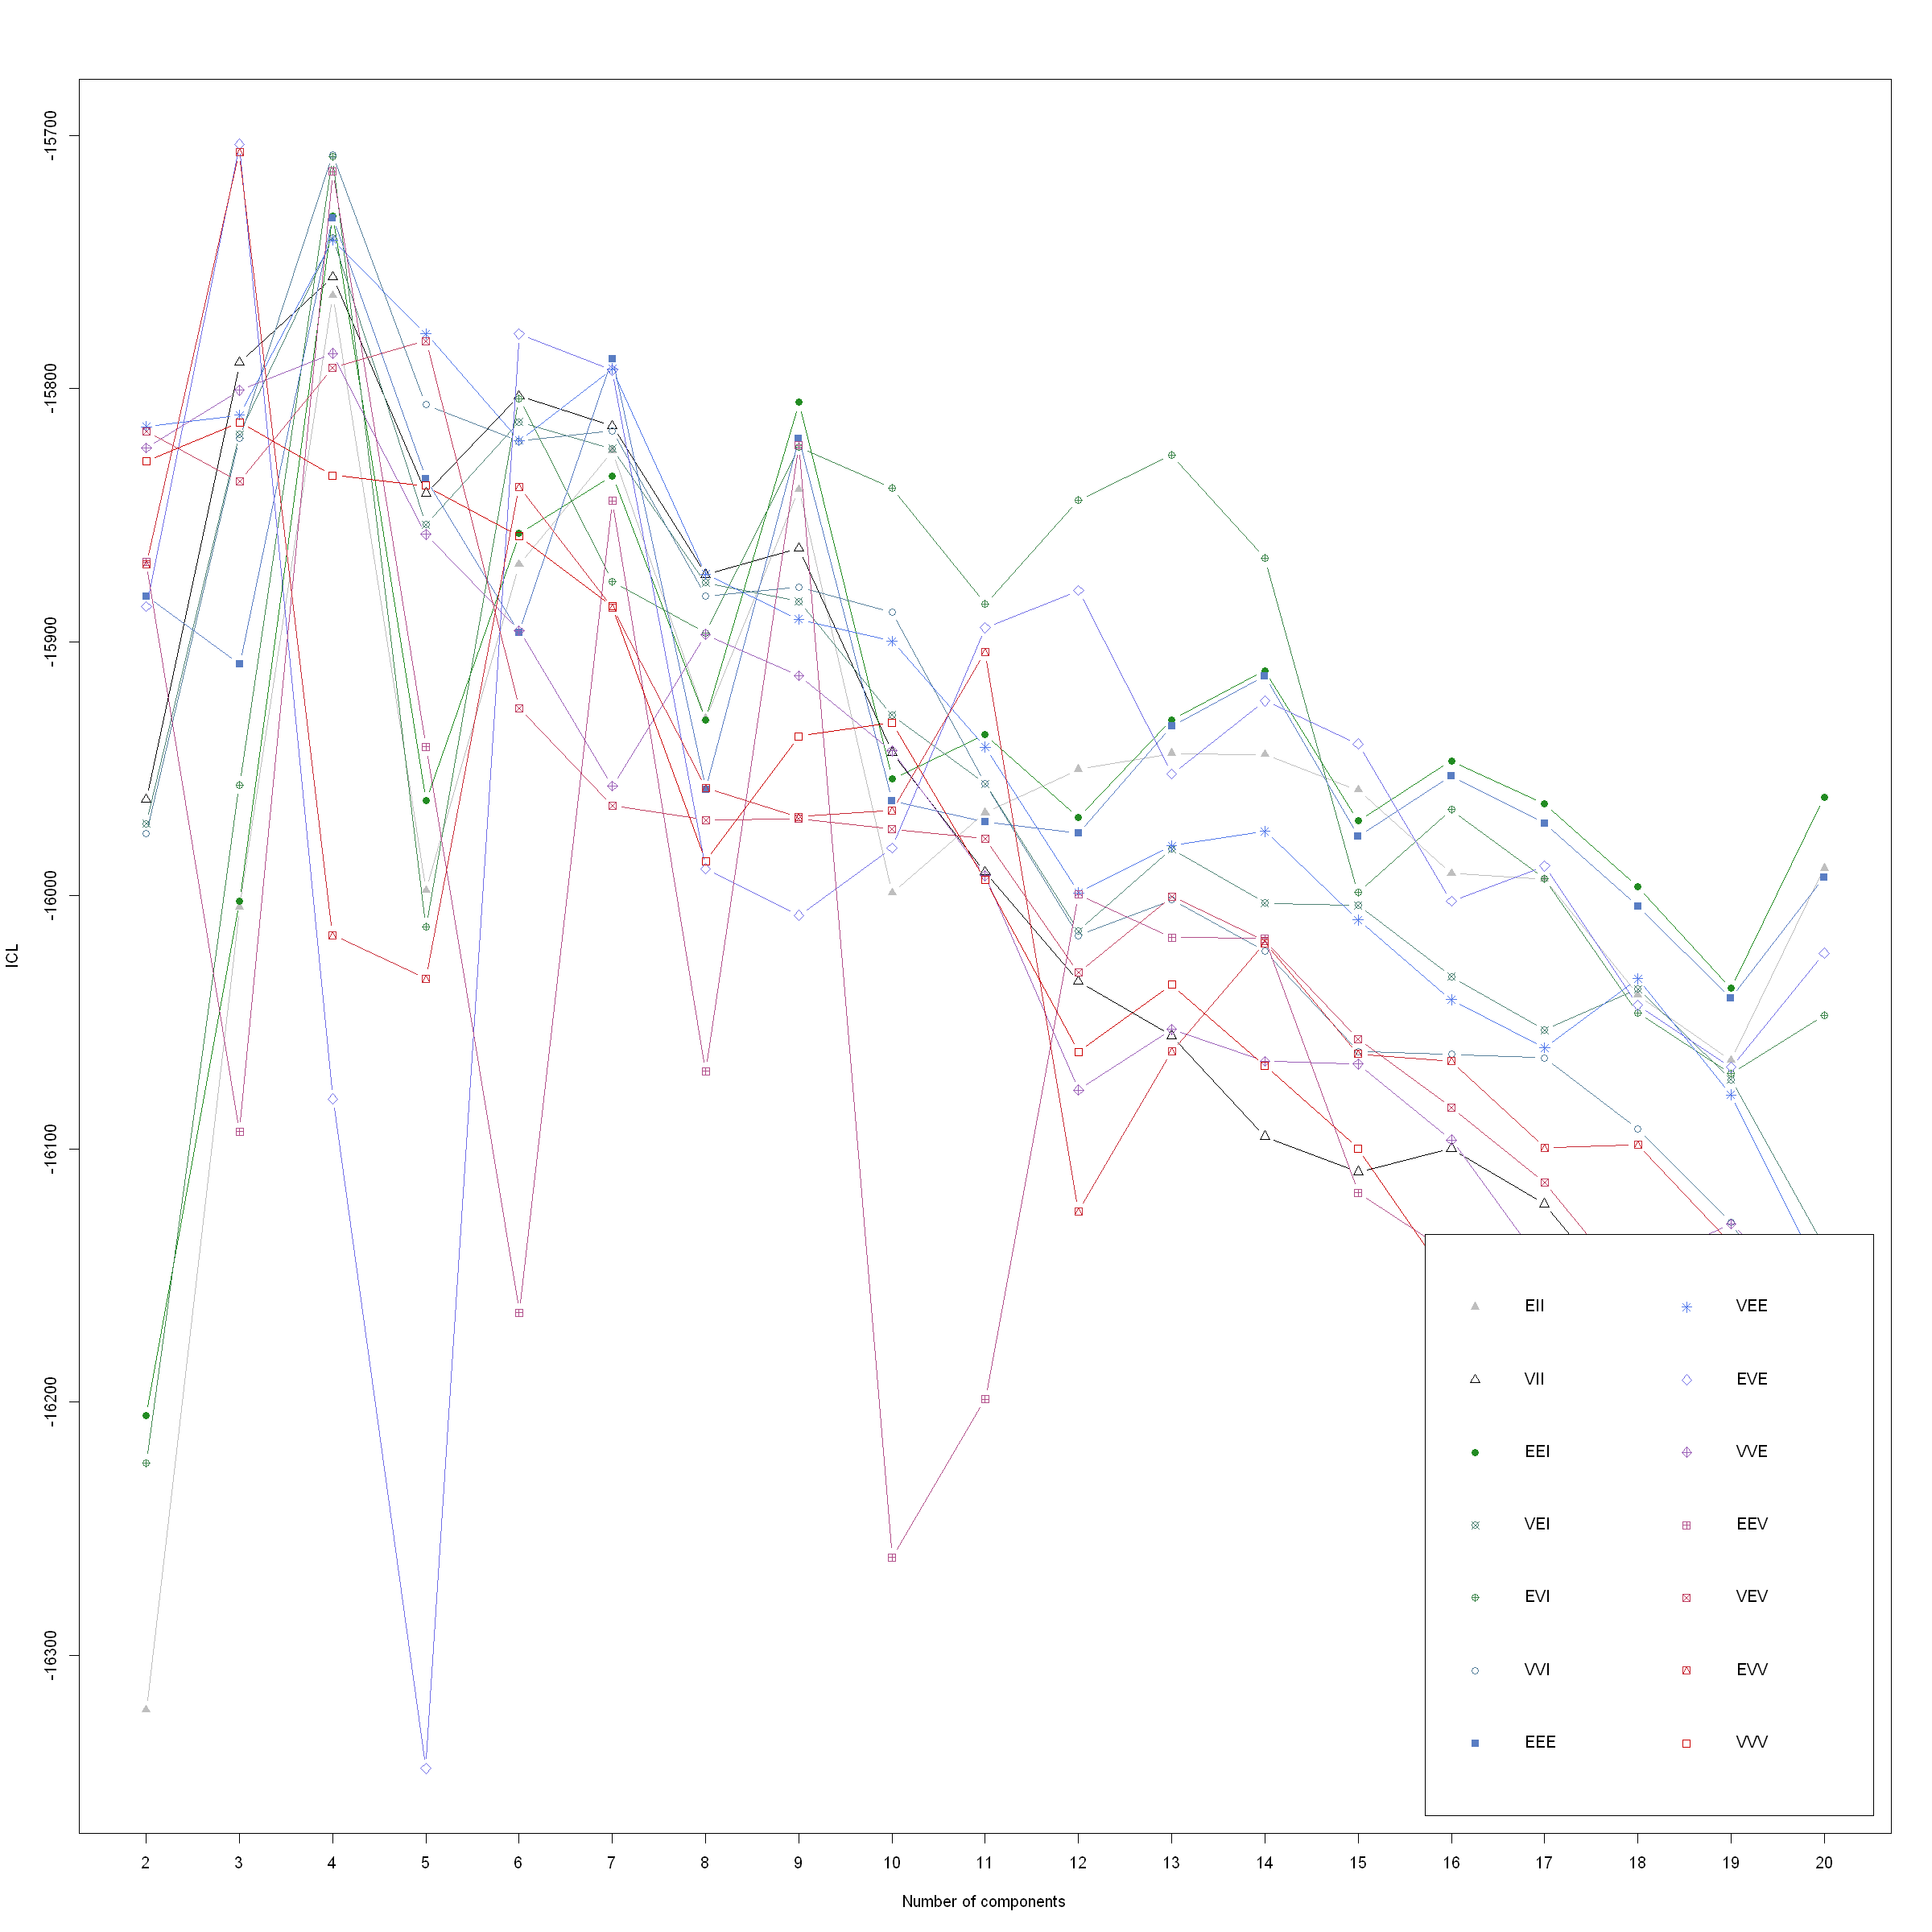

In [71]:
resICLall = mclustICL(pca$ind$coord[,1:2], G=2:20)
summary(resICLall)
resBICall = mclustBIC(pca$ind$coord[,1:2], G=2:20)
summary(resBICall)

# --- #

resBICall = Mclust(pca$ind$coord[,1:2], G=2:20)

plot(resICLall)

Nous effectuons un clustering sur les données PCA, car les données d'origine ont trop de dimensions, ce qui conduira à un clustering inefficace et peut conduire à des erreurs de calcul qui rendent le clustering difficile. Ici, nous voulons diviser en 4 groupes pour comparer avec les 2 méthodes précédentes. Selon les critères ICL, parmi les méthodes de clustering, VVI4 est la meilleure pour classer 4 clusters.

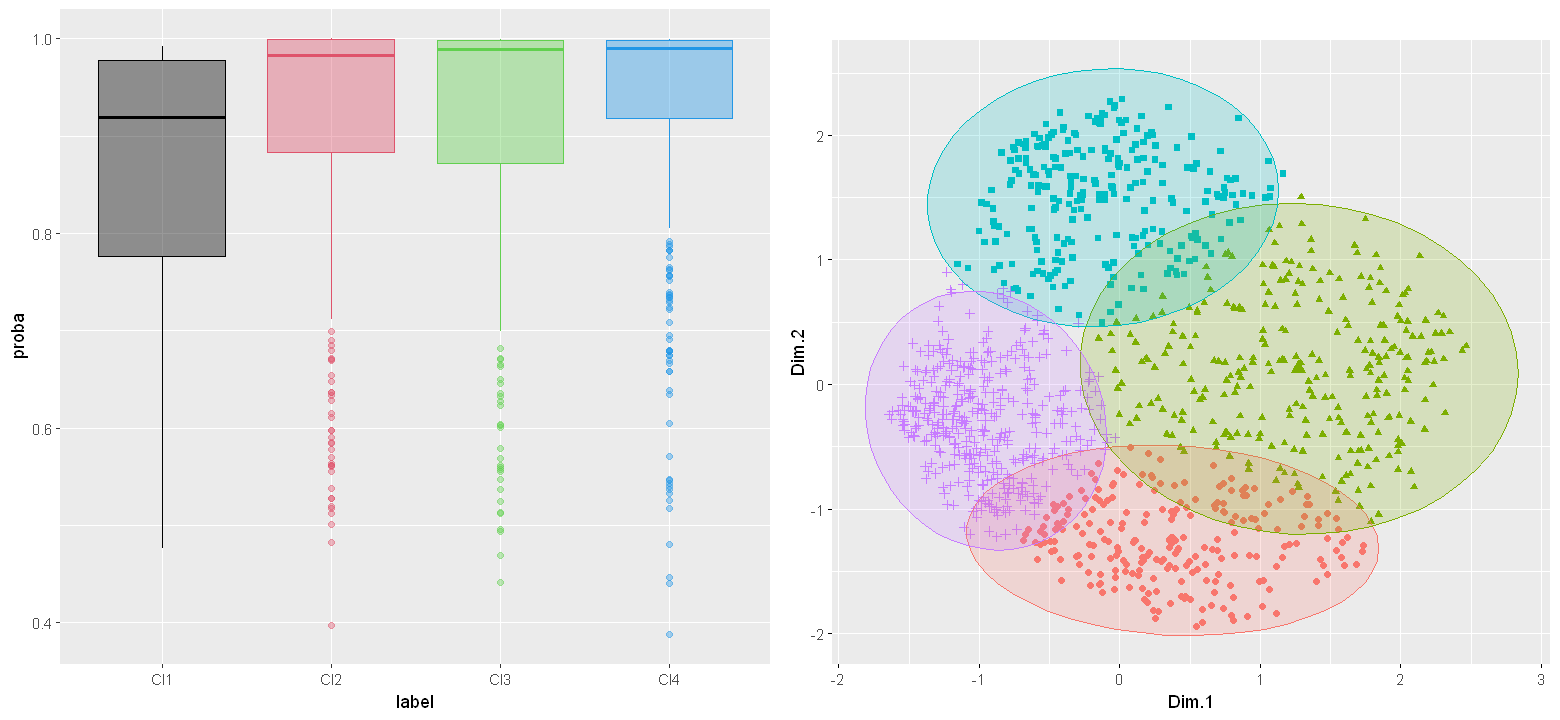

In [73]:
options(repr.plot.width = 13, repr.plot.height = 6)

resICL = Mclust(pca$ind$coord[,1:2], G=4, modelNames="VVI")

aux = data.frame(
    label = paste("Cl", resICL$classification, sep=""), 
    proba = apply(resICL$z, 1, max))

p1 = ggplot(aux, aes(x=label, y=proba)) + geom_boxplot(colour=1:4, fill=1:4, alpha=.4)
p2 = fviz_cluster(resICL, data=data_scale[,-c(1,2,3,4)], ellipse.type="norm", geom="point") +
    ggtitle("") + theme(legend.position = "none")

grid.arrange(p1, p2, ncol = 2)

Nous utilisons ici EEE4 pour obtenir 4 clusters afin de faciliter la comparaison avec k-means. Cependant, les clusters 3 et 4 ne contiennent aucun point. Par conséquent, on choisi EEE2, car les clusters 3 et 4 de EEE4 sont inutiles dans ce contexte et n'apportent pas d'informations significatives à l'analyse.

     cluster
bonus   1   2   3   4
    0 220 277 249 316
    1  10   1   2 114

[1] "89.8% des stations sont situées sur la colline dans le cluster 4 du regroupement gmm."


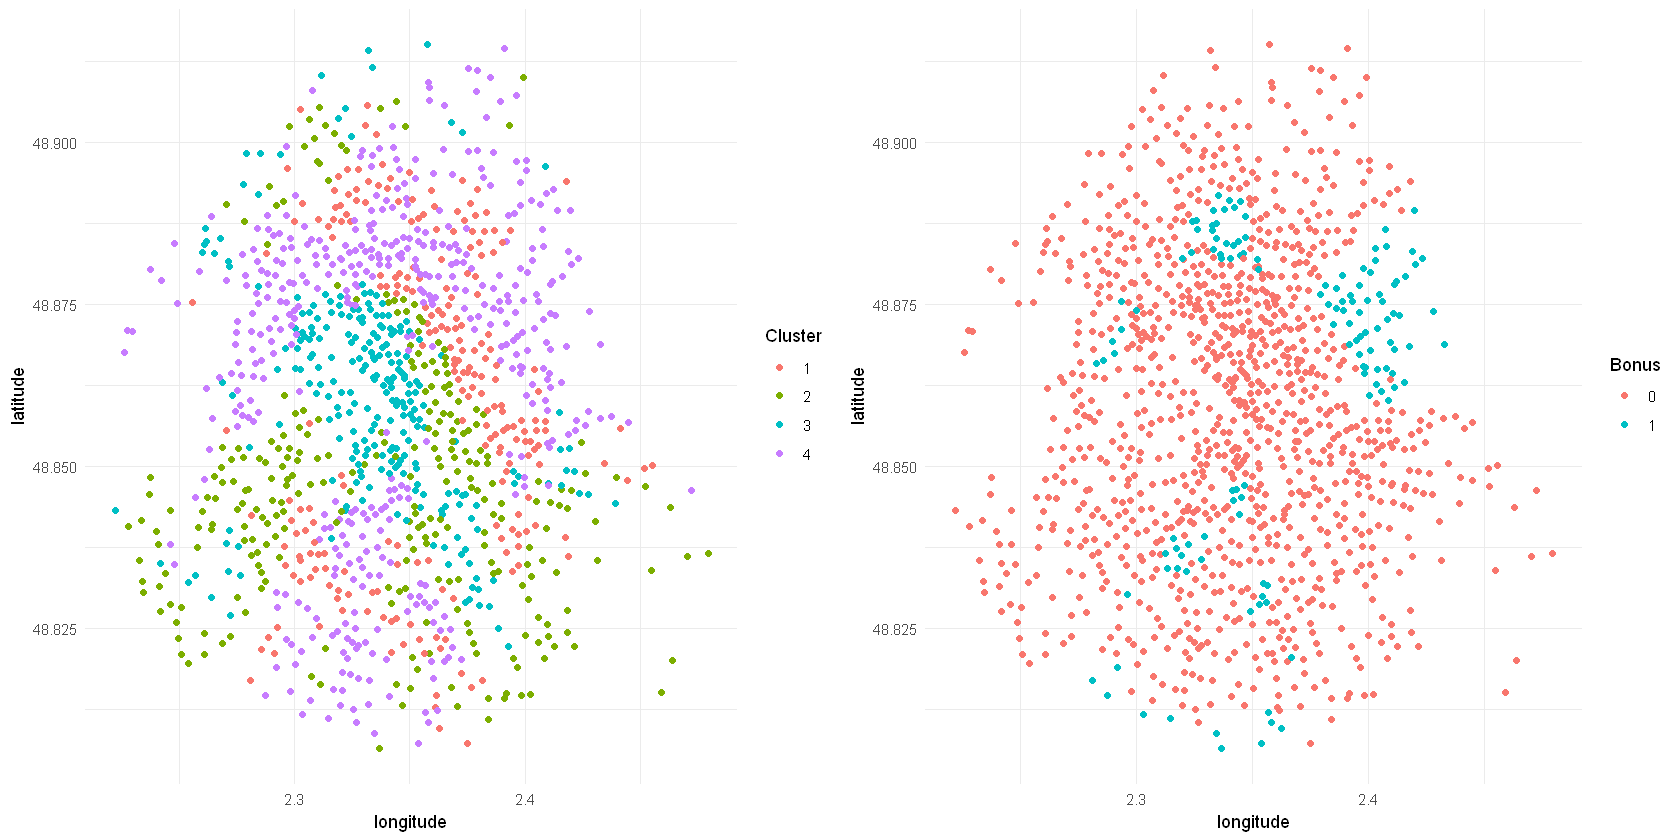

In [78]:
options(repr.plot.width = 14, repr.plot.height = 7)
grid.arrange(
    ggplot(data, aes(x = longitude, y = latitude, color = factor(resICL$classification))) +
        geom_point() +
        labs(color = "Cluster") +
        theme_minimal(),
    ggplot(data, aes(x = longitude, y = latitude, color = bonus)) +
        geom_point() +
        labs(color = "Bonus") +
        theme_minimal(),
    ncol=2
)
data_3 <- data


data_3$cluster <- resICL$classification
data_3$cluster <- factor(data_3$cluster,levels = c("1", "2","3","4"))
table_data <- table(bonus = data_3$bonus, cluster = data_3$cluster)
table_data
rate=table_data[2,4]/sum(table_data[2,])*100
print(sprintf("%.1f%% des stations sont situées sur la colline dans le cluster 4 du regroupement gmm.", rate))

Ici, on voit que 89.8% des stations sont situées sur la colline dans le cluster 4 du regroupement gmm.

No id variables; using all as measure variables

No id variables; using all as measure variables

No id variables; using all as measure variables

No id variables; using all as measure variables



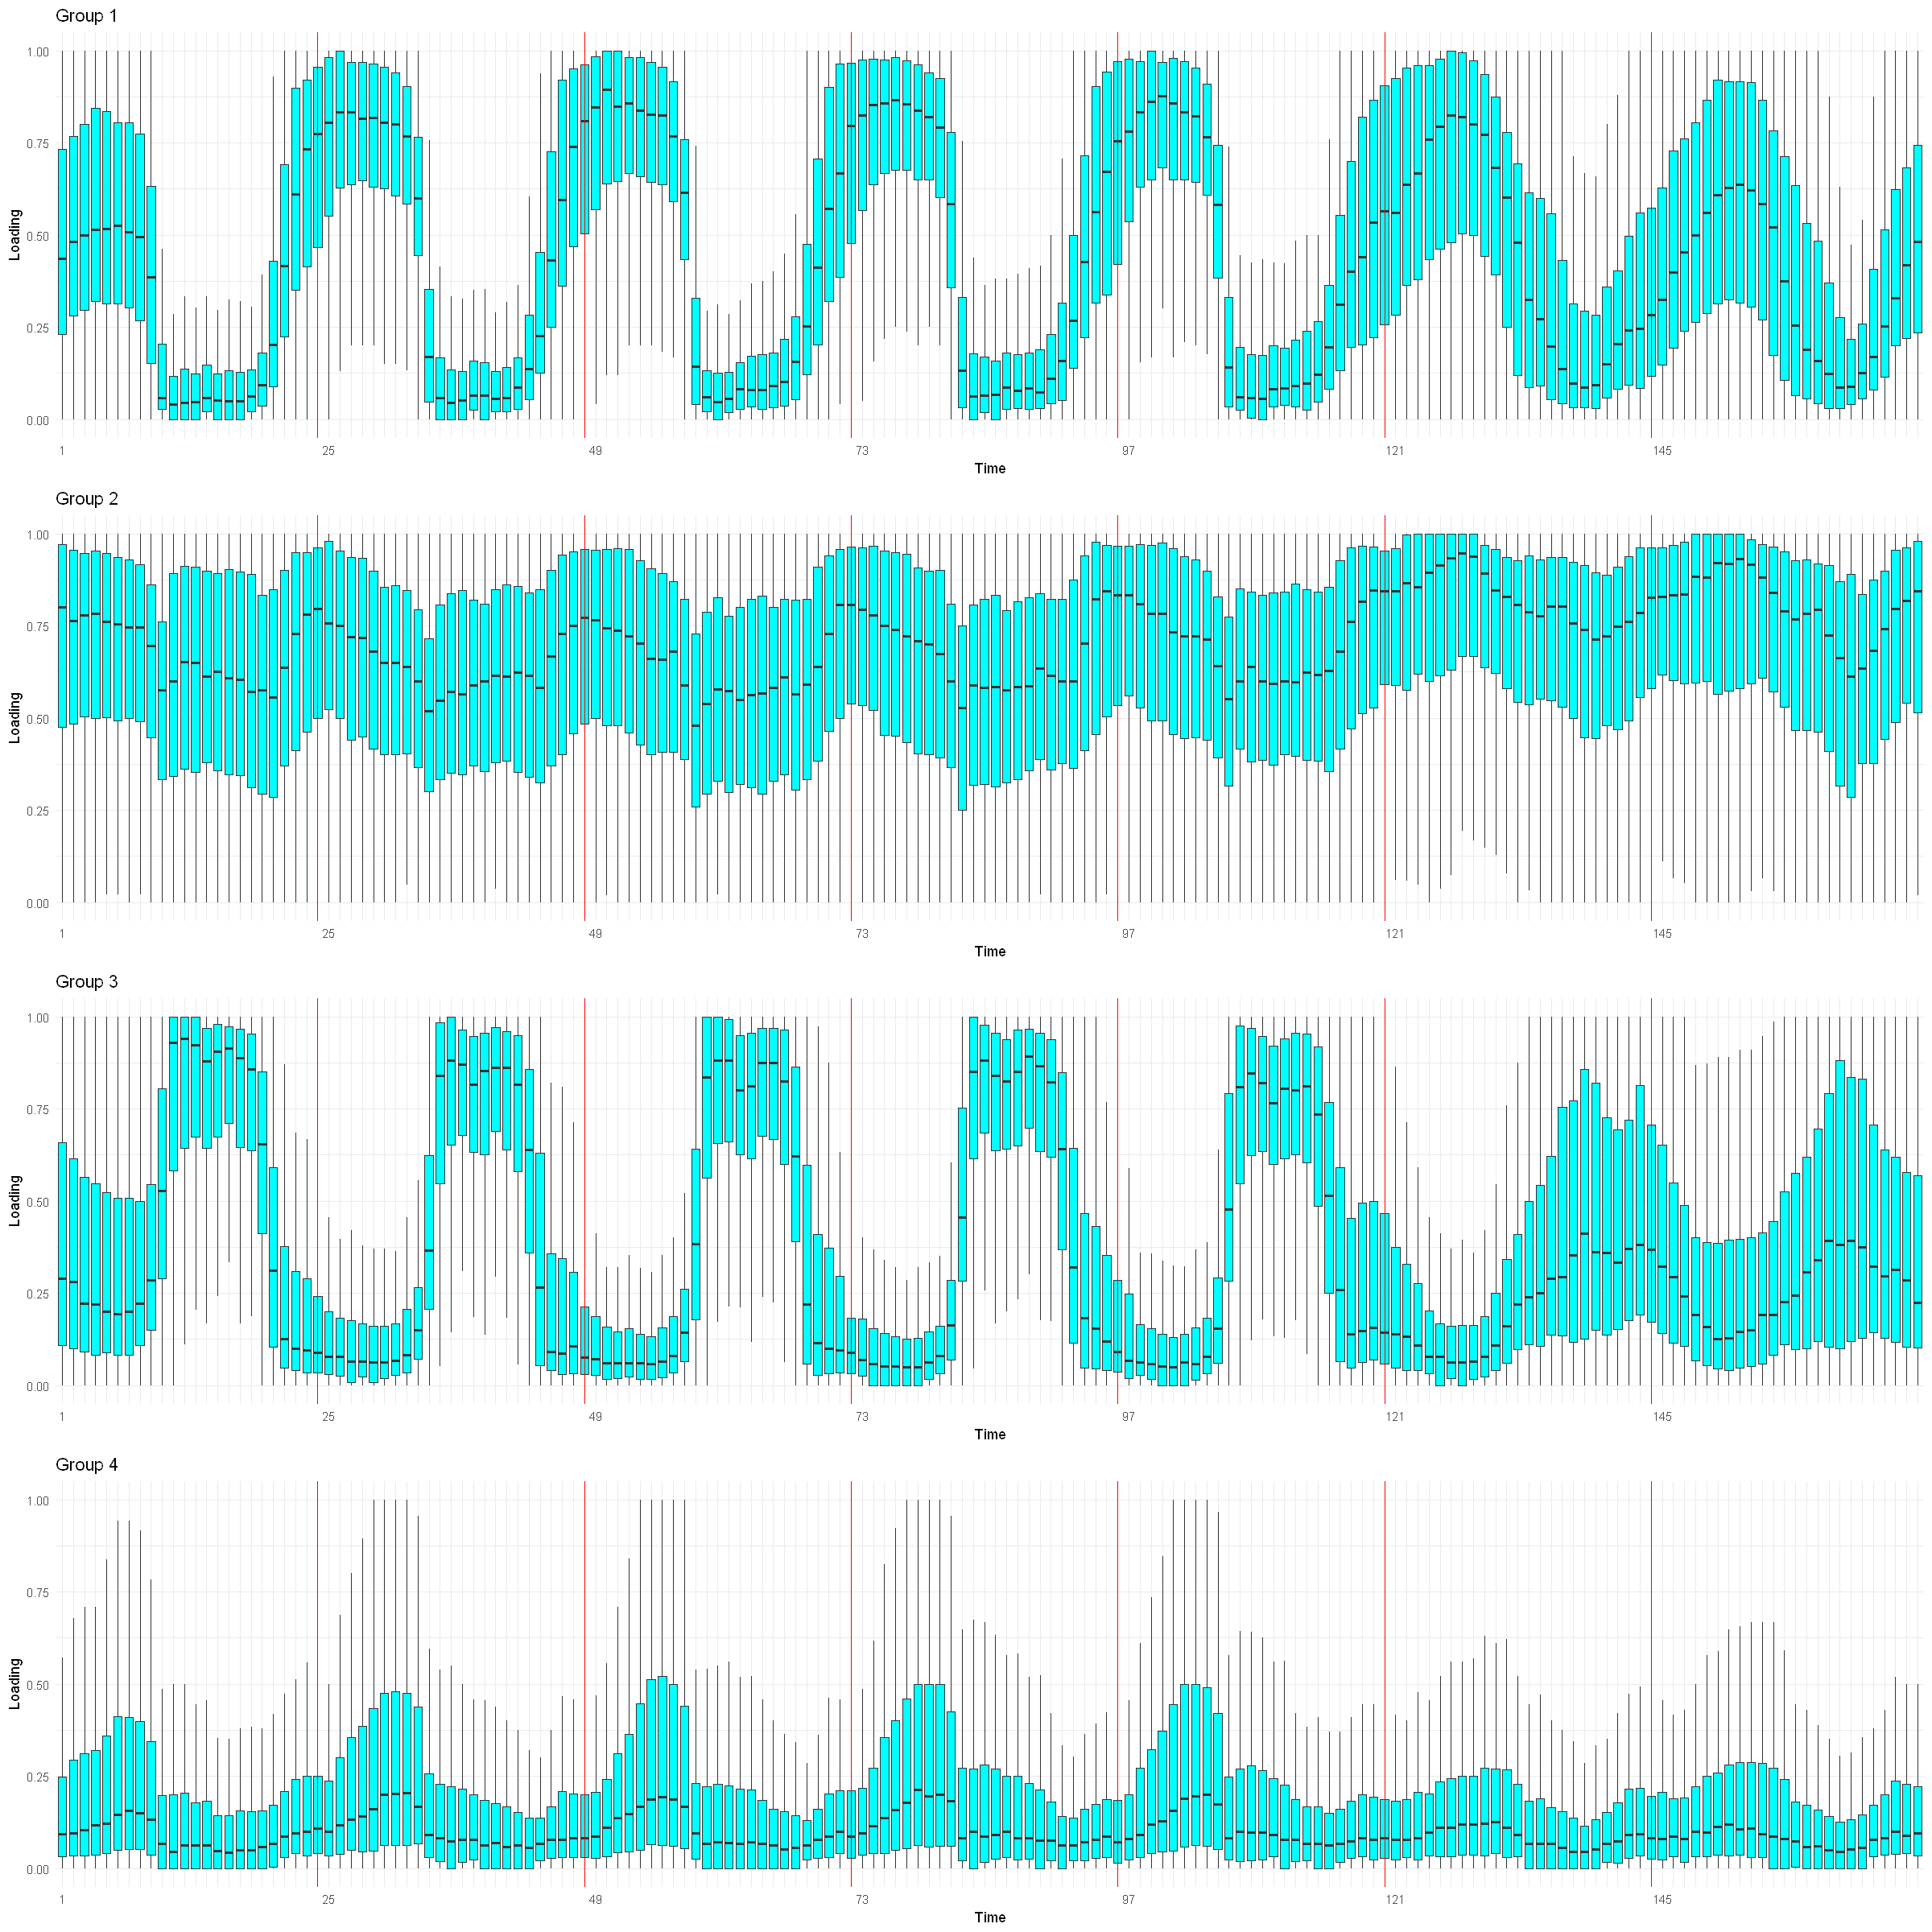

In [80]:
options(repr.plot.width = 20, repr.plot.height = 20)
plots <- list()

for (i in 1:4){
  cluster_indices <- which(resICL$classification == i)
  cluster_data <- data[cluster_indices, -c(1, 2, 3, 4)]
  df <- melt(cluster_data)

  labels <- as.character(1:ncol(loading))
  labels[-c(1, 25, 49, 73, 97, 121, 145)] <- ""  

#  mean_data <- aggregate(value ~ variable, data = df, FUN = mean)

  plots[[i]] <- ggplot(df, aes(x = variable, y = value)) +
    geom_boxplot(fill = "cyan", outlier.shape = NA) +
#    geom_jitter(width = 0.001, alpha = 0.5) +  

#    geom_line(data = mean_data, aes(group = 1), color = "blue", size = 2) +

    geom_vline(xintercept = c(24, 48, 72, 96, 120, 144), color = "red", linetype = "solid") +
    scale_x_discrete(labels = labels) +  
    labs(x = "Time", y = "Loading") +  
    theme_minimal() +
    ggtitle(paste("Group", i))
}

grid.arrange(grobs = plots, ncol = 1)

Les clusters générés par GMM présentent des caractéristiques similaires à ceux obtenus par K-means et CAH. Par conséquent, on peut dire qu'ils effectuent un bon clustering.

## Conclusion

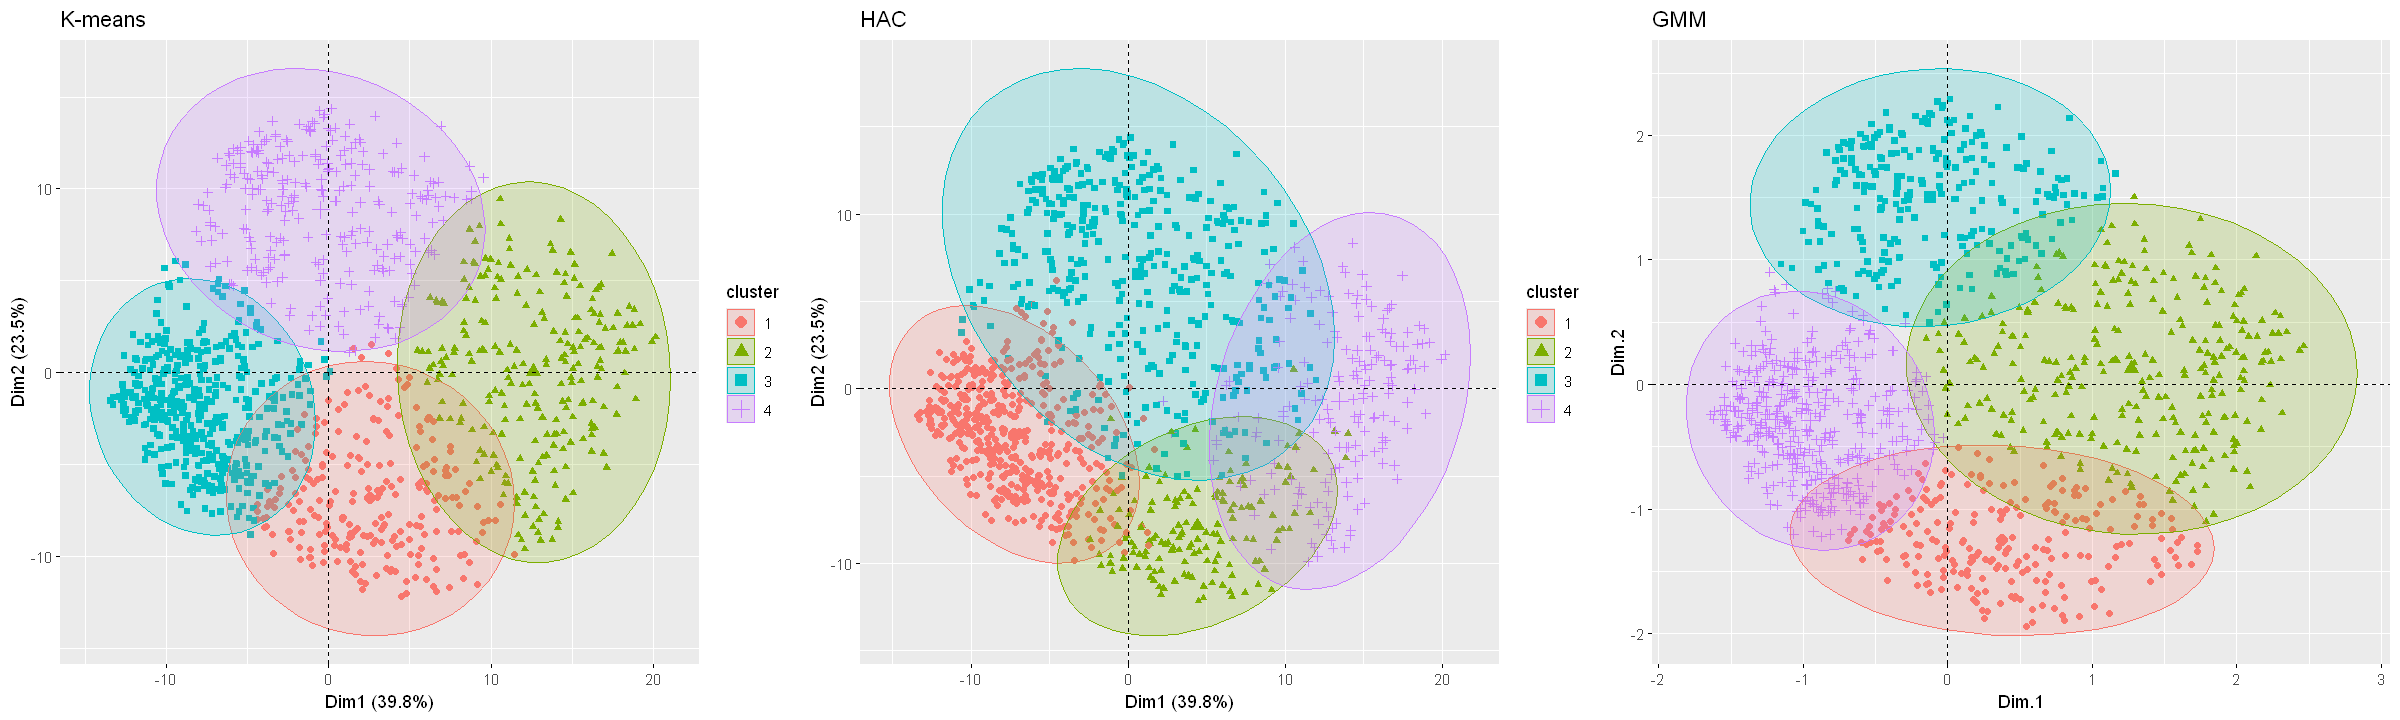

In [87]:
options(repr.plot.width = 20, repr.plot.height = 6)
p1 = fviz_cluster(reskmeans, data=data_scale[,-c(1,2,3,4)], ellipse.type="norm", labelsize=8, geom=c("point"))+geom_hline(yintercept = 0, linetype = "dashed", color = "black") +geom_vline(xintercept = 0, linetype = "dashed", color = "black")+ggtitle("K-means")
p2 = fviz_cluster(list(data = data[,-c(1,2,3,4)], cluster = res_hclust_ward), ellipse.type = "norm", labelsize = 8, geom = c("point")) +
    geom_hline(yintercept = 0, linetype = "dashed", color = "black") +
    geom_vline(xintercept = 0, linetype = "dashed", color = "black") +
    ggtitle("HAC")
p3 = fviz_cluster(resICL, data=data_scale[,-c(1,2,3,4)], ellipse.type="norm", geom="point") +
    geom_hline(yintercept = 0, linetype = "dashed", color = "black") +
    geom_vline(xintercept = 0, linetype = "dashed", color = "black") +
    ggtitle("GMM") + theme(legend.position = "none")

grid.arrange(p1, p2, p3, ncol = 3)

Les méthodes de cluster produisent toutes des clusters avec des caractéristiques clairement différentes. Les résultats de clustering des trois méthodes sont similaires et fonctionnent bien. Comme on peut le voir dans le plan dim1-dim2, quatre clusters sont clairement distingués selon les positions : à gauche et à droite de l'axe verticau (dim 2), en haut et en bas de l'axe horizontal (dim 1).

- Les points à gauche de l'axe verticau correspondent aux stations avec une "loading" faible, tandis que ceux à droite correspondent à l'inverse.
- Les points au-dessus de l'axe horizontal correspondent aux stations avec une "loading" élevée pendant la journée et faible la nuit, tandis que ceux en dessous correspondent à l'inverse. De plus, ils montrent une variabilité élevée au fil du temps.
  
Conclusion : Le premier composant principal contient des informations sur la hauteur  "loading" des stations. Le deuxième composant principal contient des informations sur la variabilité et la période pendant laquelle la "loading" des stations est élevée ou faible.